In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import pickle

import numpy as np
import torch
from PIL import Image
from geomloss import SamplesLoss
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm

from vectran.renderers.cairo import render as cairo_render
from vectran.util.evaluation_utils import vector_image_from_patches

from vecopt.aligner import (
    StatefulBatchAligner,
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
)
from vecopt.aligner_utils import LossComposition, store_render_difference
from vecopt.crossing_model import CrossingRefinerFull

DEVICE = 'cuda:0'

from vecopt.contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
renderer = Renderer((64, 64), linecaps='butt', device=DEVICE, dtype=torch.float32)

In [2]:
def strip_confidence_grads(state):
    if state['current_line_batch'].grad is not None:
        state['current_line_batch'].grad.data[:, :, -1] = 0.
        
        
def compose(*fns):
    def composition(state):
        result = None
        for fn in fns:
            result = fn(state)
        return result    
            
    return composition


def coords_only_grads(n_steps=200):
    def fn(state):
        if state['current_step'] < n_steps:
            state['current_line_batch'].grad.data[:, :, -2] = 0.
    return fn


def reduced_width_lr(multiplier=0.2):
    def fn(state):
        state['current_line_batch'].grad.data[:, :, -2] *= multiplier
    return fn


def not_too_thin(state):
    return torch.sum(torch.relu(1. - state['current_line_batch'][:, :, -2]))


def perceptual_bce(model, n_convolutions=2, weight=1.0):
    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    def fn(state):
        render = model.apply_convolutions(state['render'].unsqueeze(1), n_convolutions)
        raster = model.apply_convolutions(state['raster'].unsqueeze(1), n_convolutions)
        result = weight * bce(render, raster).mean(dim=(1, 2, 3)).sum()
        return result
    
    return fn


def accumulate_renders(state):
    if 'renders' not in state:
        state['renders'] = []
    state['renders'].append(state['render'][0].detach().cpu().numpy())

In [3]:
model = CrossingRefinerFull().to(DEVICE)
model.load_state_dict(torch.load('best_crossings_mult.pt'))
_ = model.train(False)

In [4]:
def qbezier_to_cbezier(qbezier):
    p0 = qbezier[..., :2]
    qp1 = qbezier[..., 2:4]
    qp2 = qbezier[..., 4:6]
    rest = qbezier[..., 6:]
    p1 = (qp1 * 2 + p0) / 3
    p2 = (qp1 * 2 + qp2) / 3
    return torch.cat([p0, p1, p2, qp2, rest], axis=-1)

In [18]:
with open('/home/apankov/optimization_vectorization/datasets'
          '/results/abc/our_curves/intermediate_output/'
          '00050000_99fd5beca7714bc586260b6a_step_000.pickle', 'rb') as handle:
    sample = pickle.load(handle)
    
sample['patches_vector'] = qbezier_to_cbezier(sample['patches_vector'])

In [19]:
output_vector_image = vector_image_from_patches(
    primitives=sample['patches_vector'],
    patch_offsets=sample['patches_offsets'],
    image_size=sample['cleaned_image_shape'],
    control_points_n=4,
    patch_size=[64, 64],
    pixel_center_coodinates_are_integer=False,
    min_width=.3,
    min_confidence=.5,
    min_length=1.7)

# output_vector_image.adjust_view()
output_vector_image.save('inference/1_before.svg')

In [16]:
sample.keys()

dict_keys(['patches_rgb', 'patches_vector', 'patches_offsets', 'cleaned_image_shape', 'options', 'image_name'])

In [17]:
sample['cleaned_image_shape']

(2240, 2656)

In [7]:
Image.fromarray(output_vector_image.render(cairo_render)).save('source___.png')

100%|██████████| 500/500 [02:14<00:00,  3.73it/s]


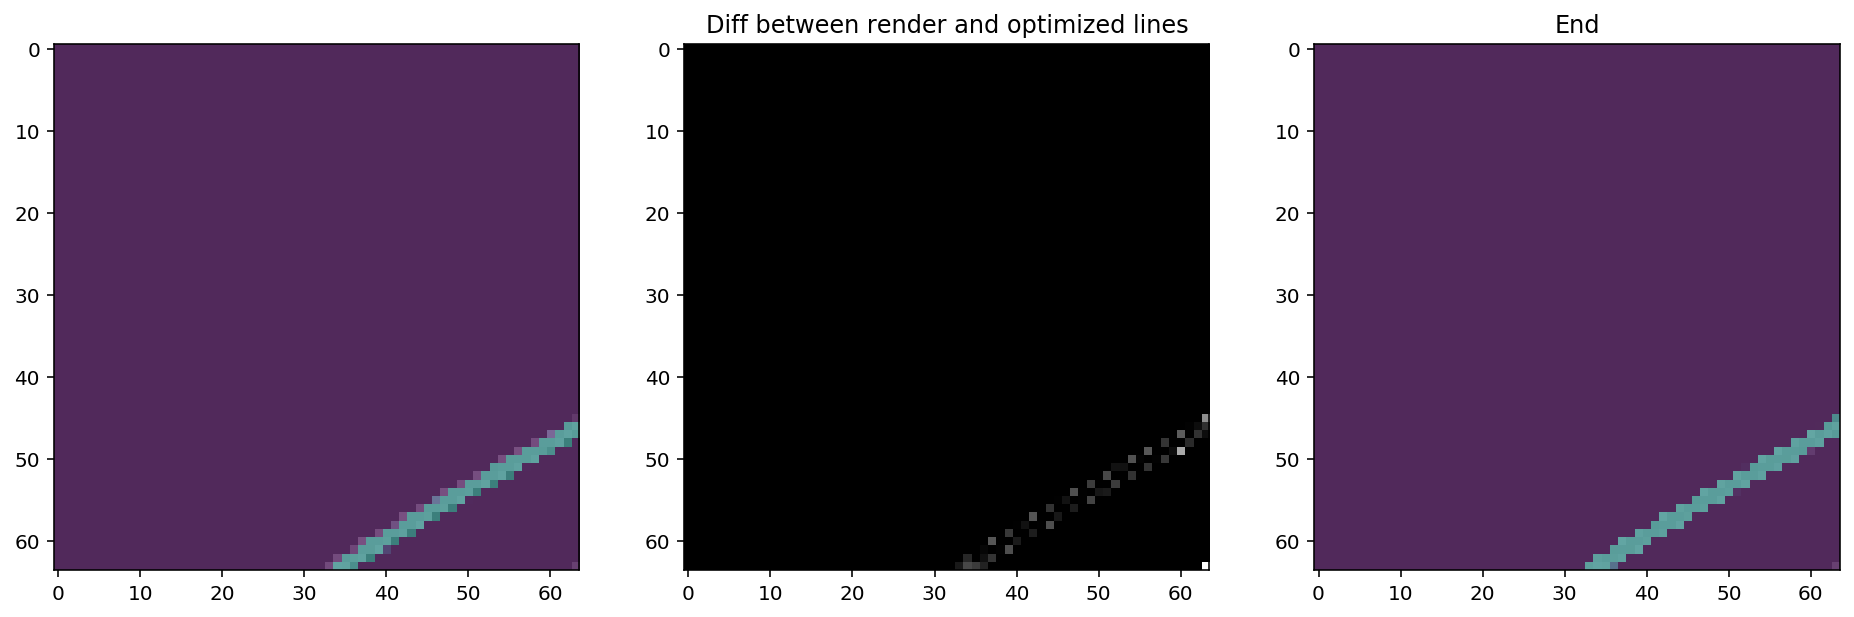

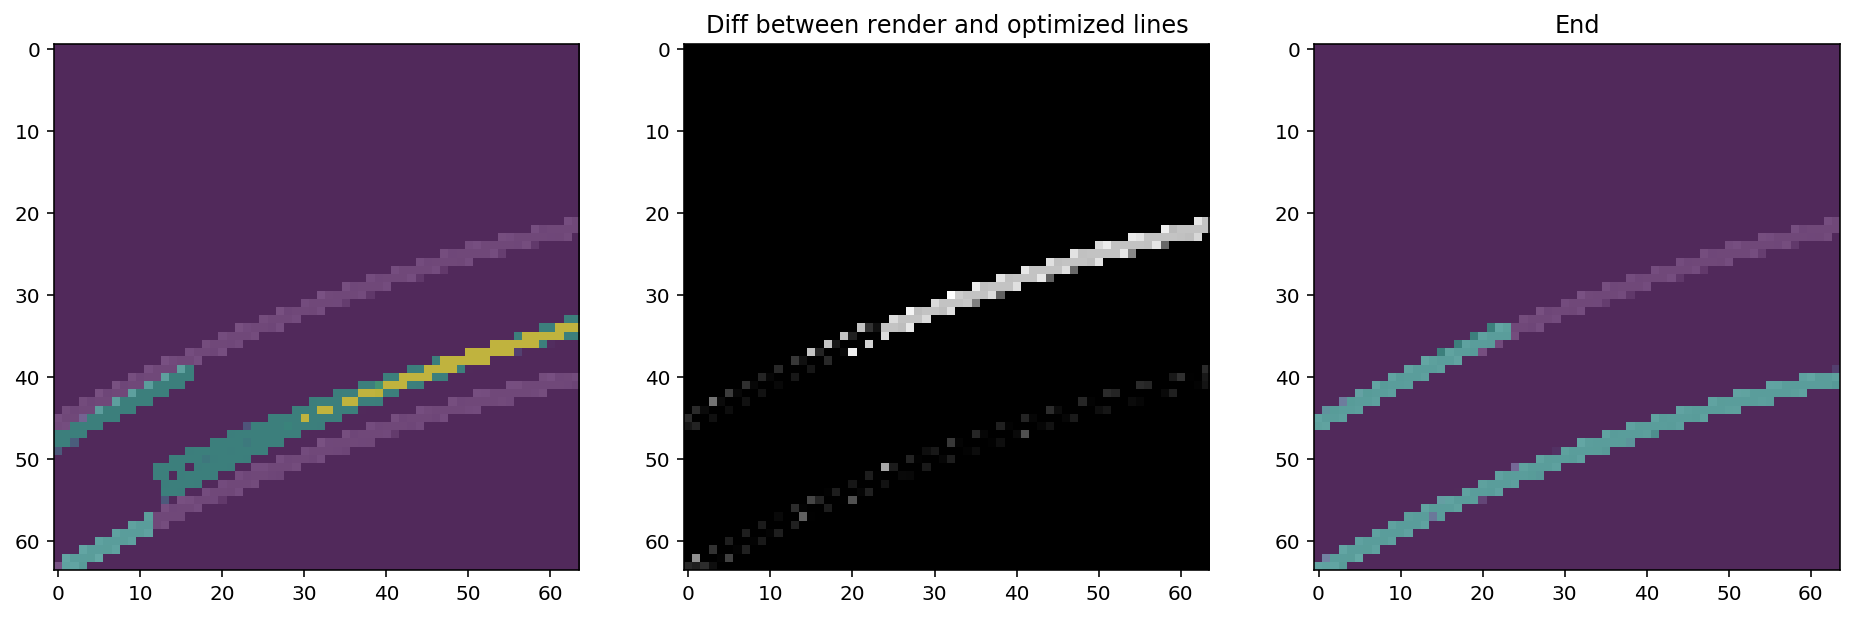

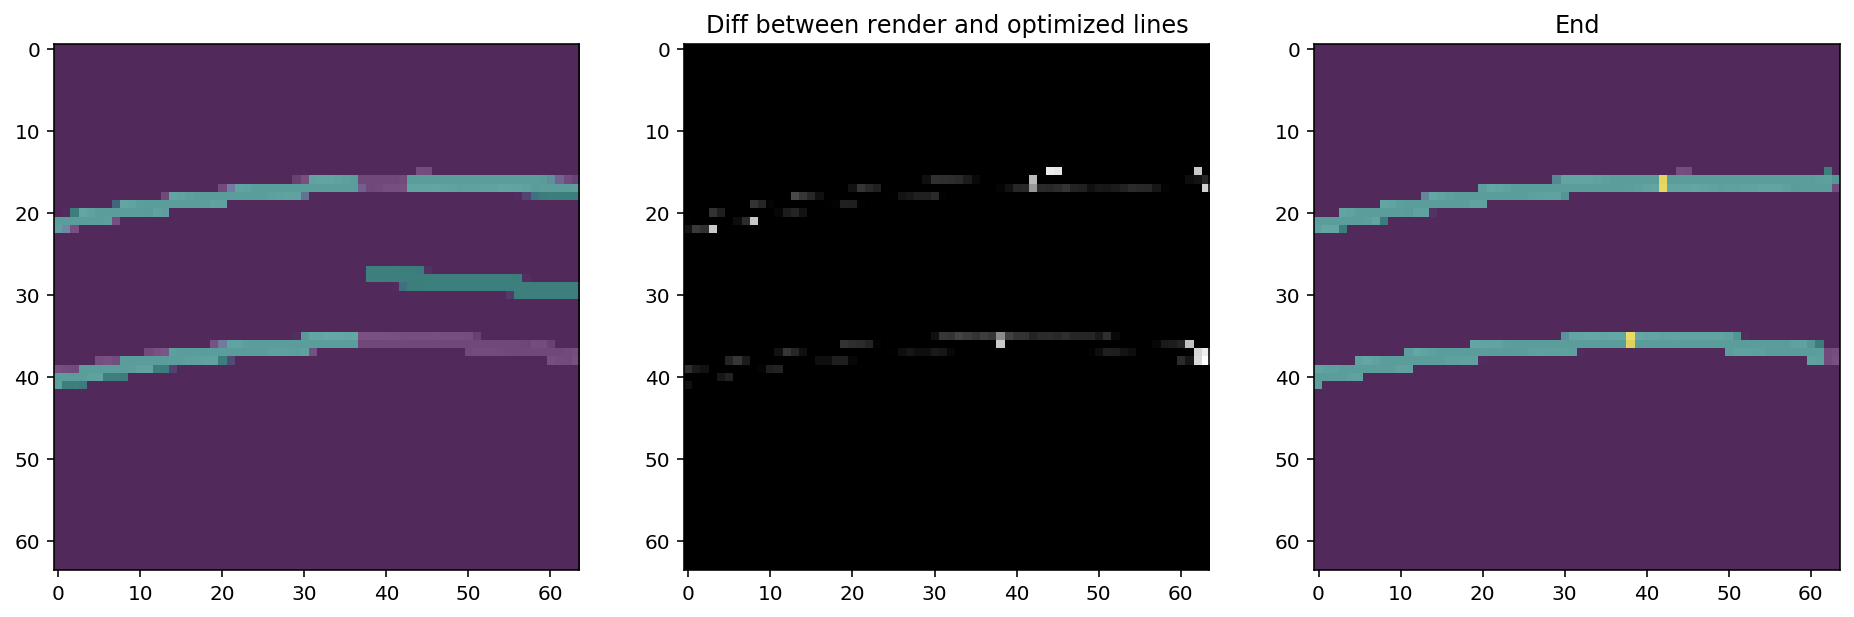

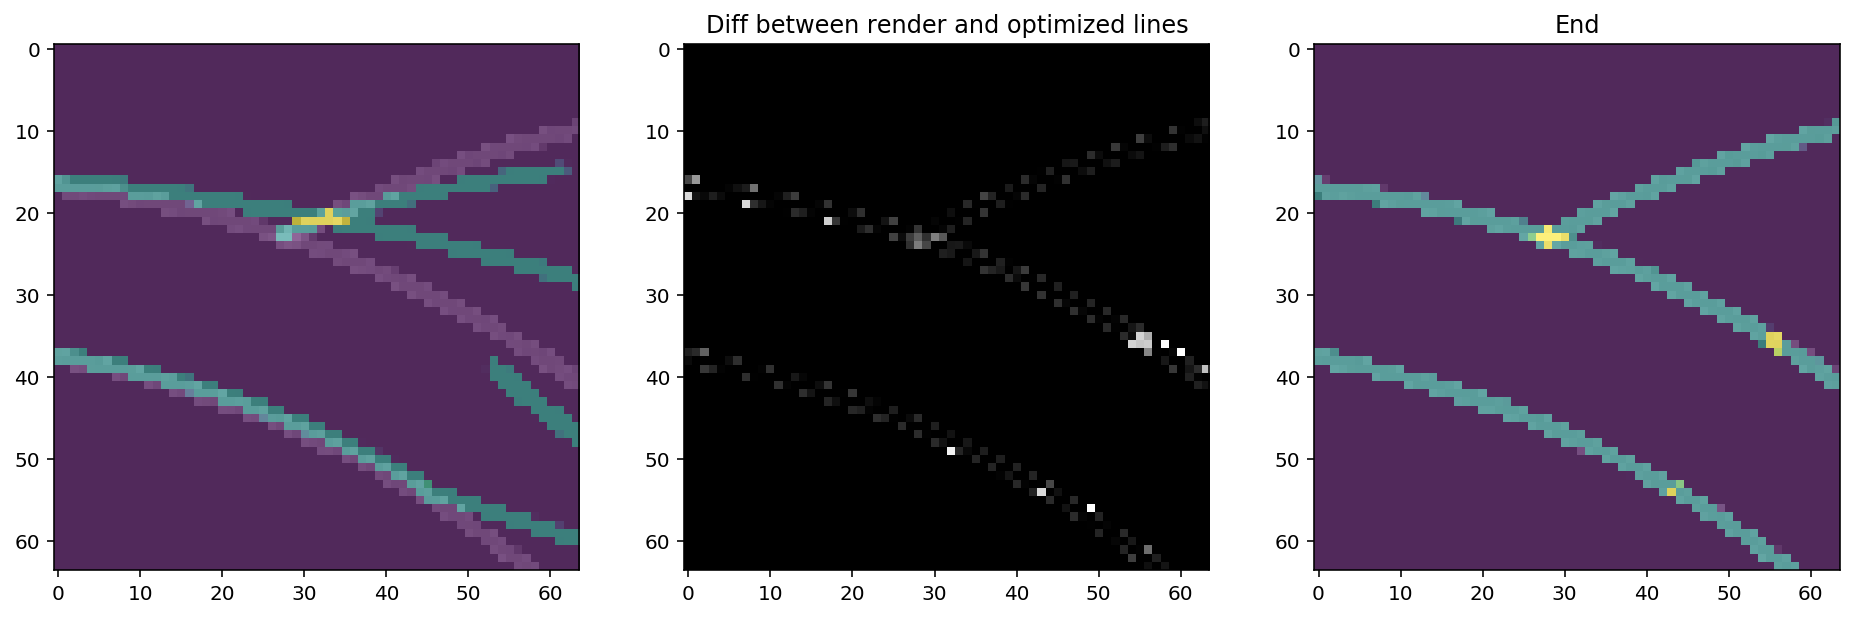

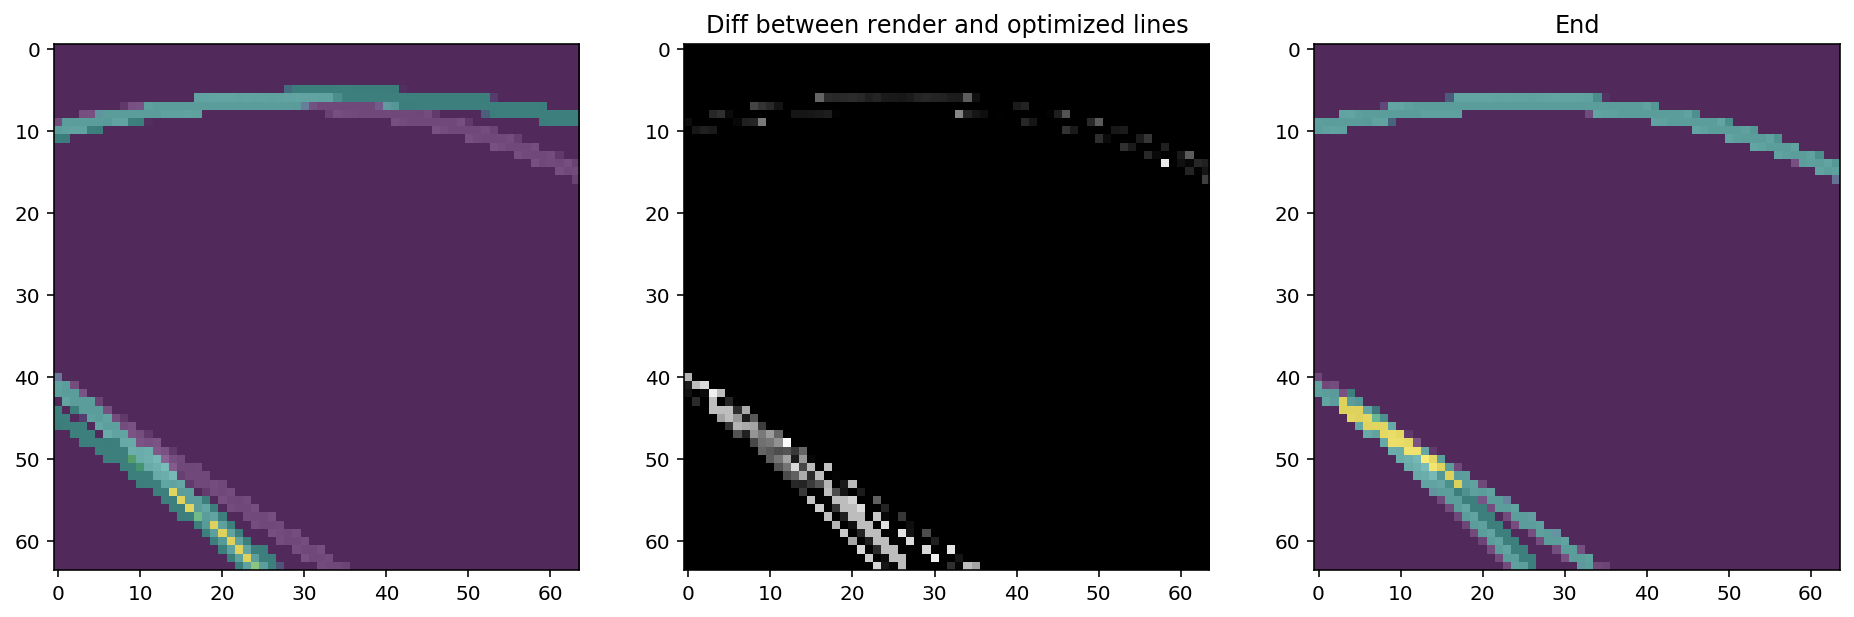

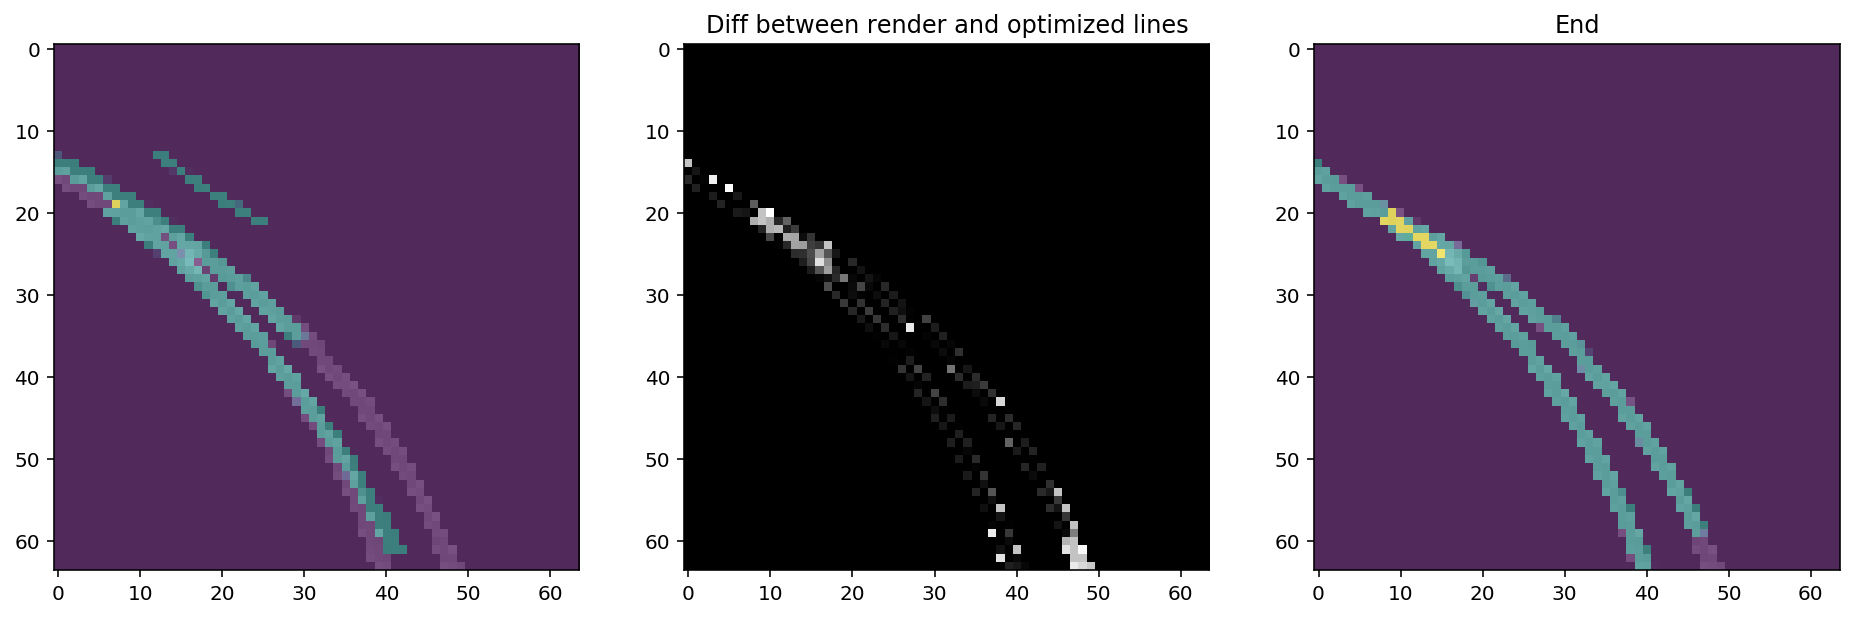

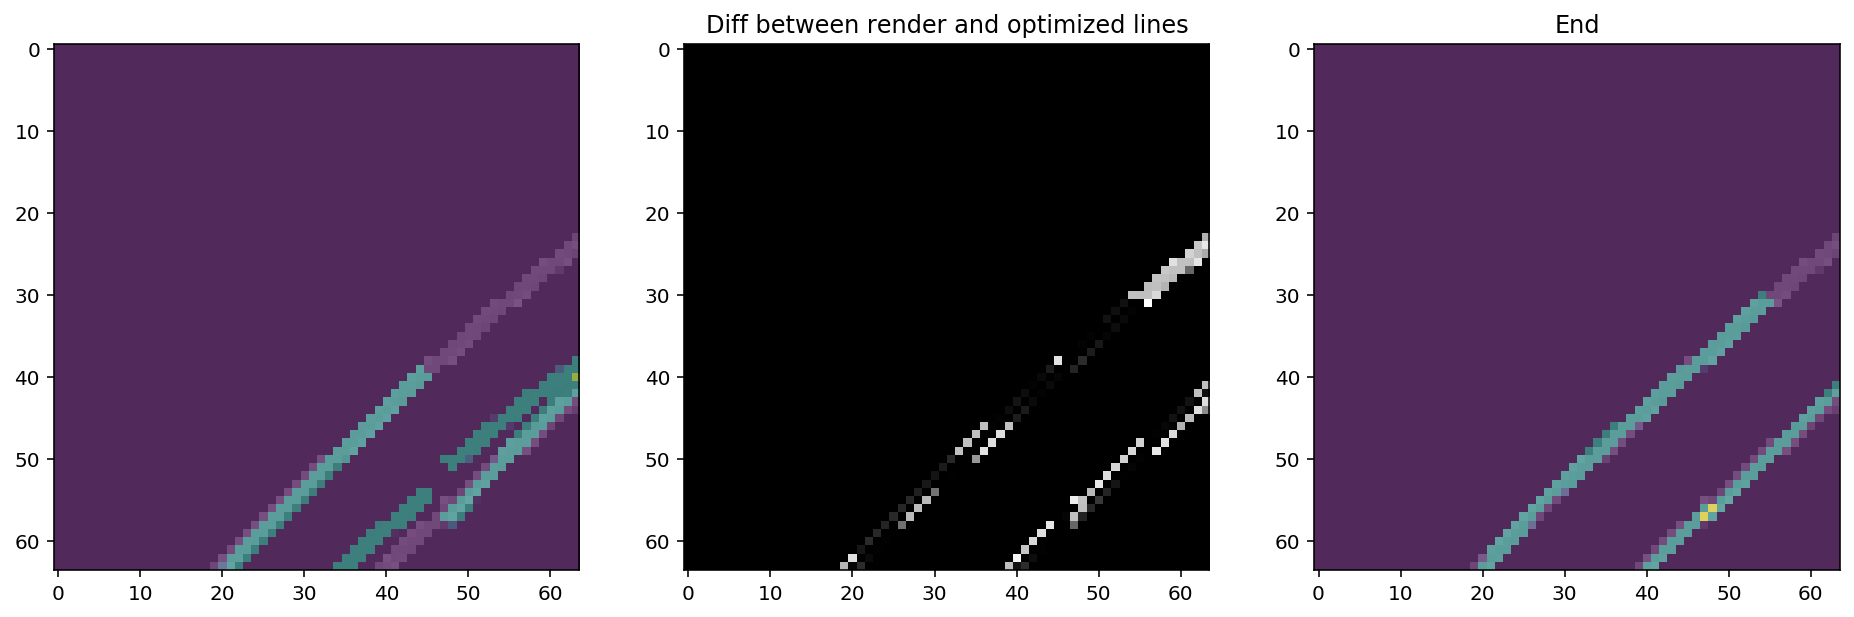

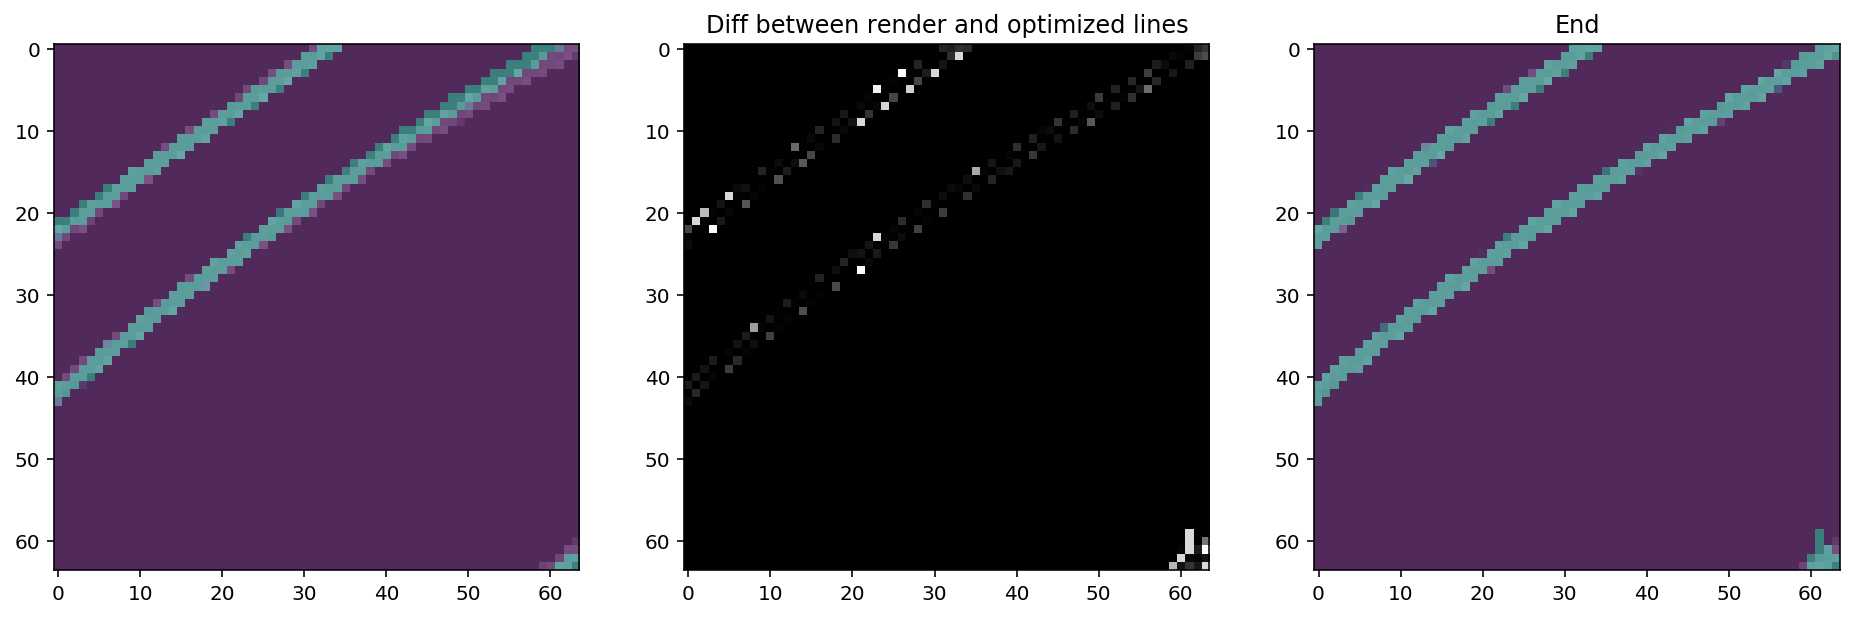

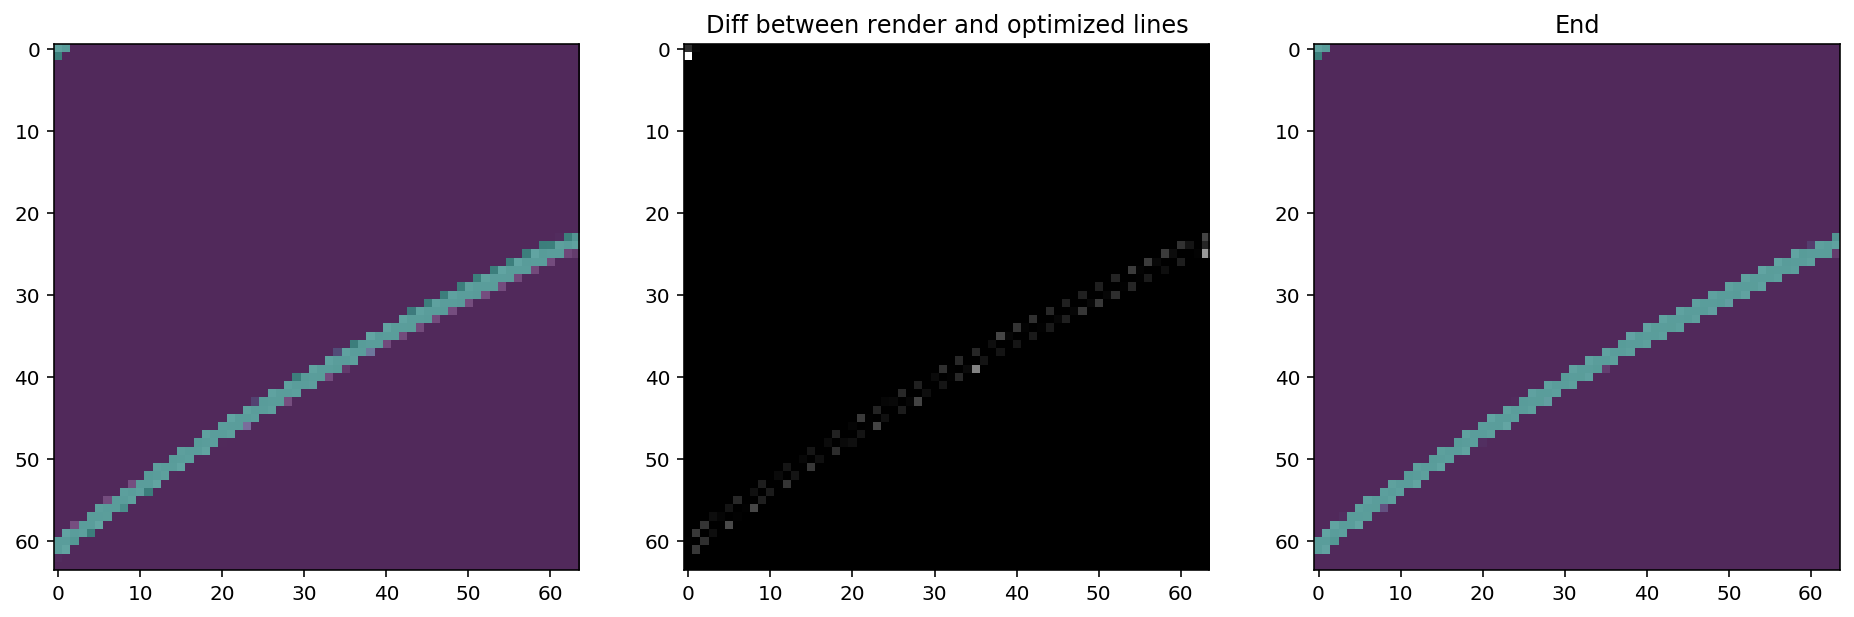

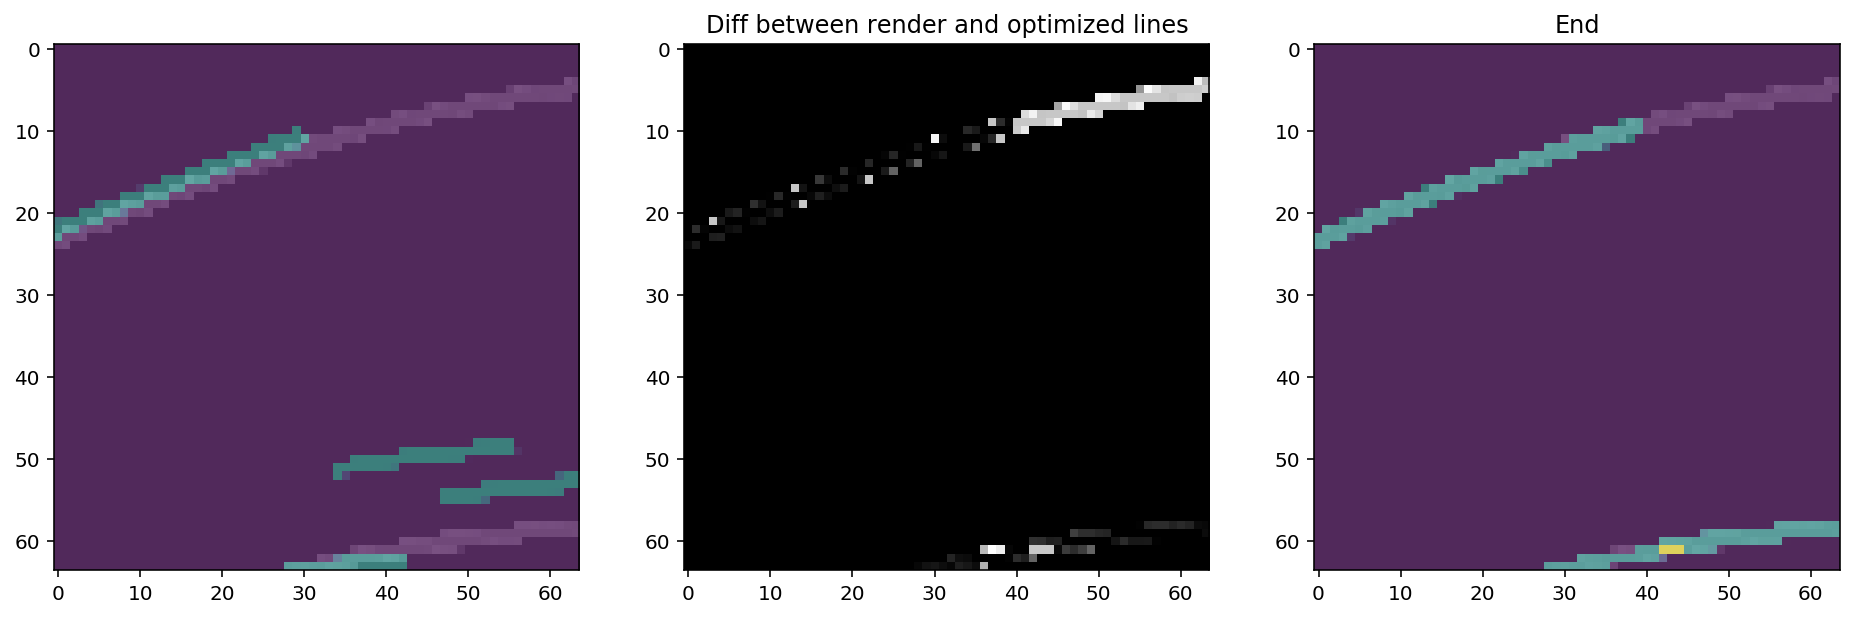

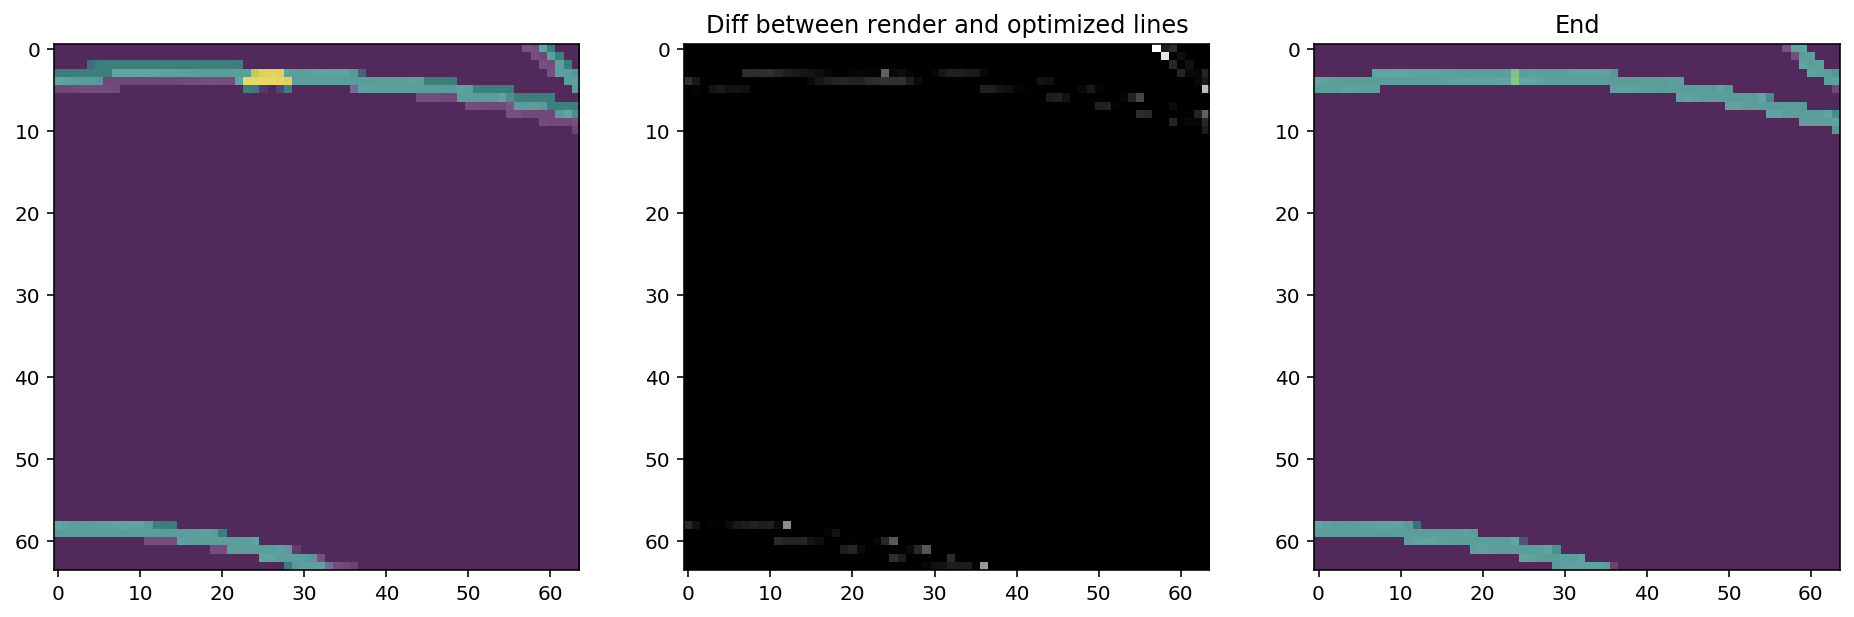

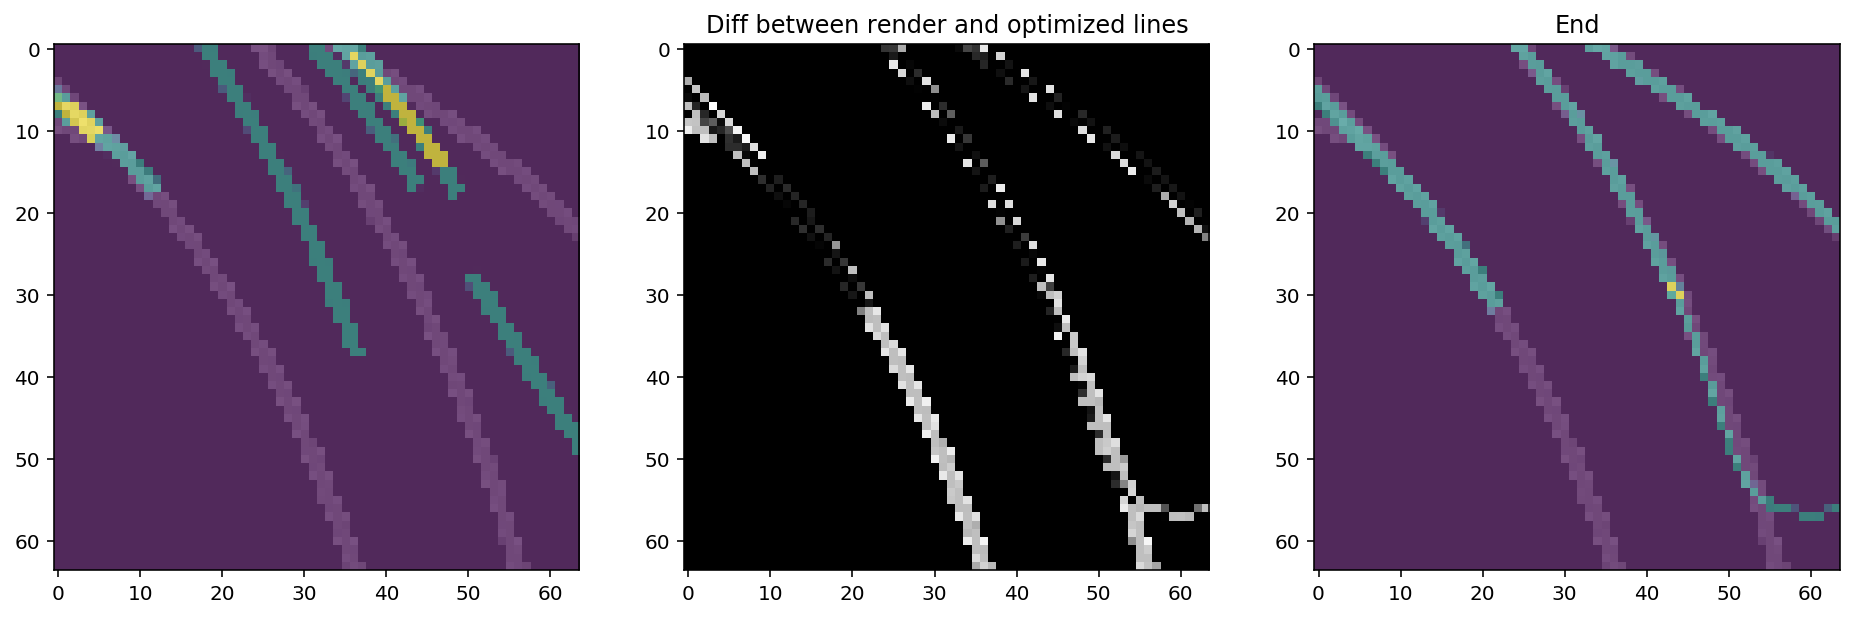

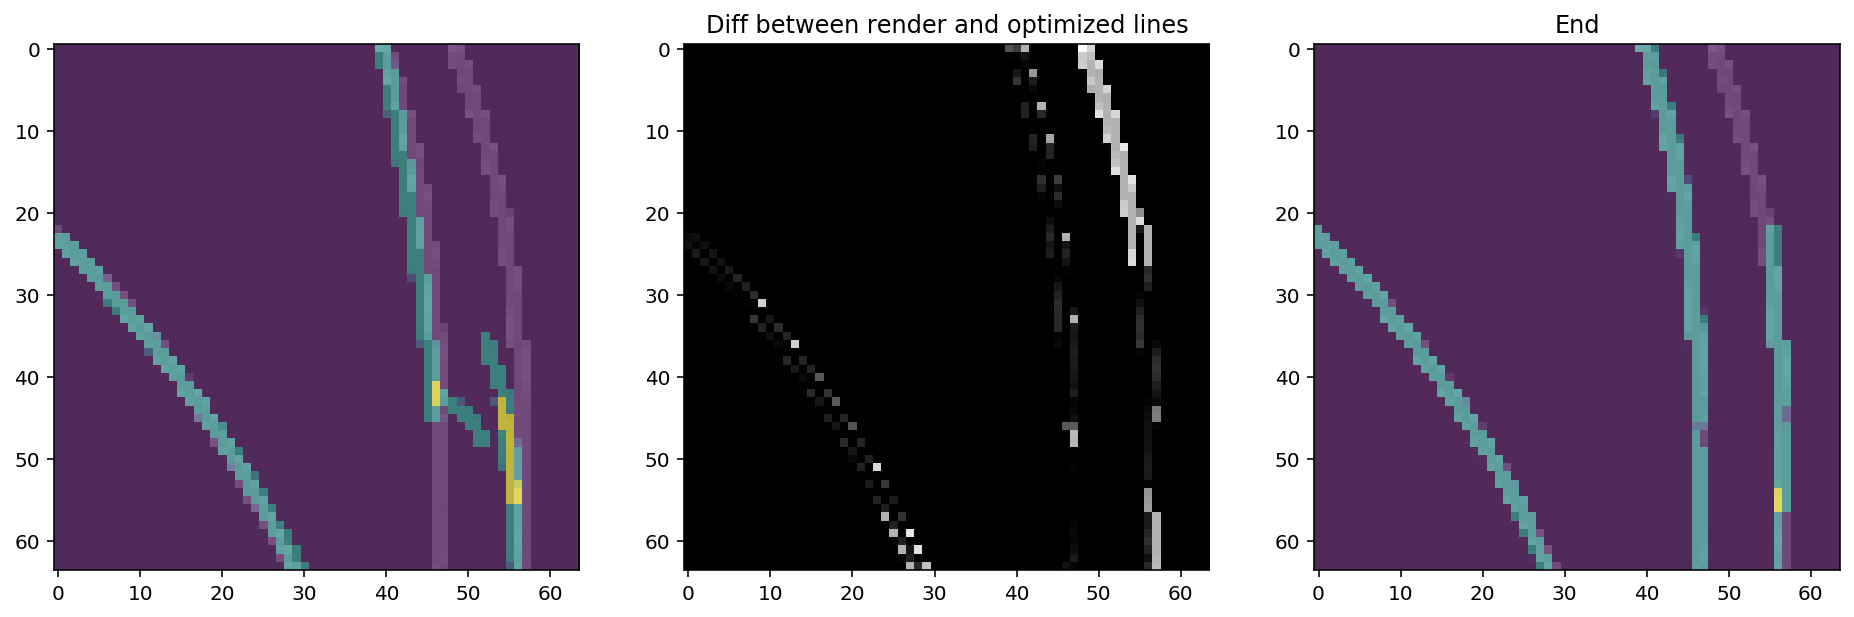

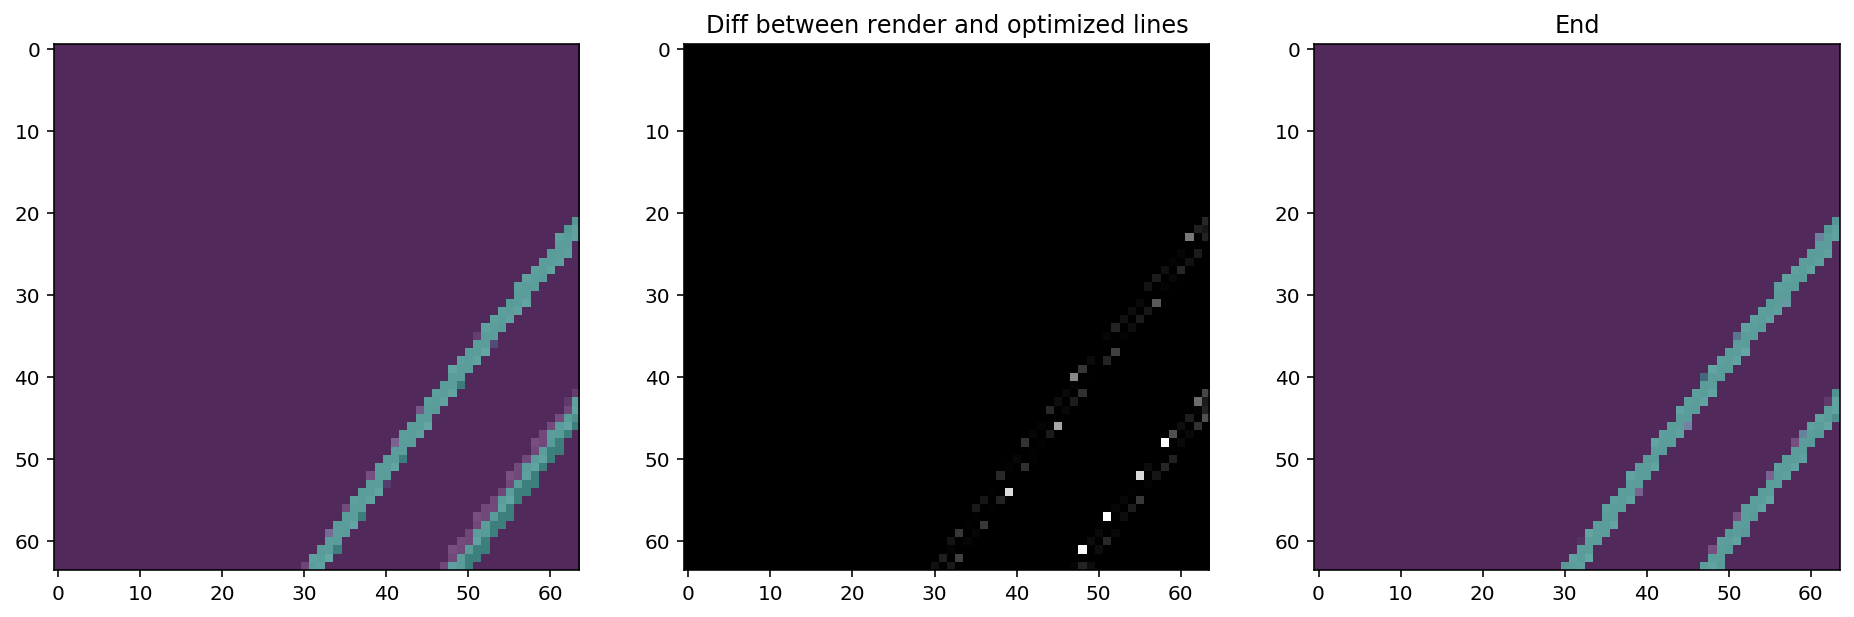

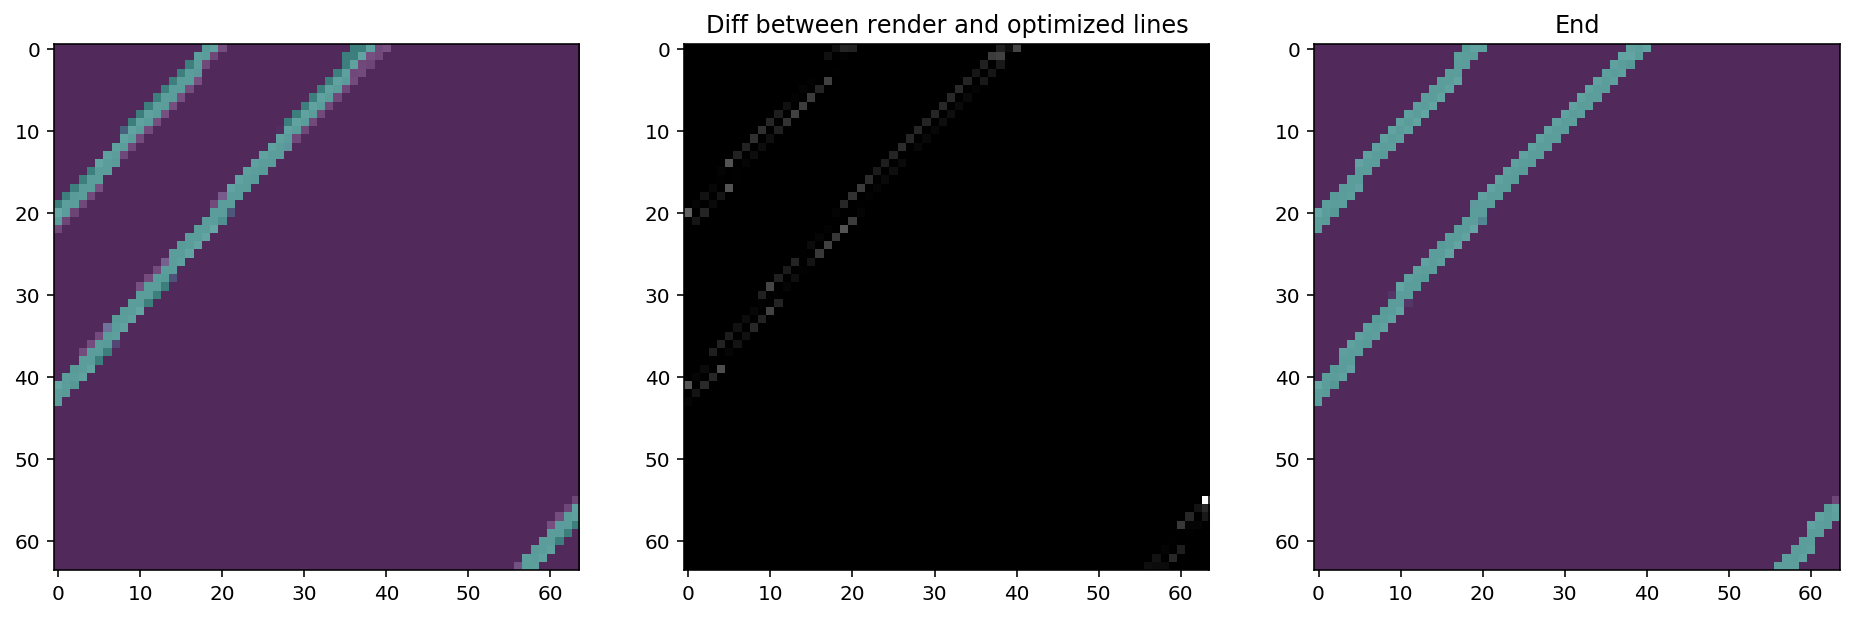

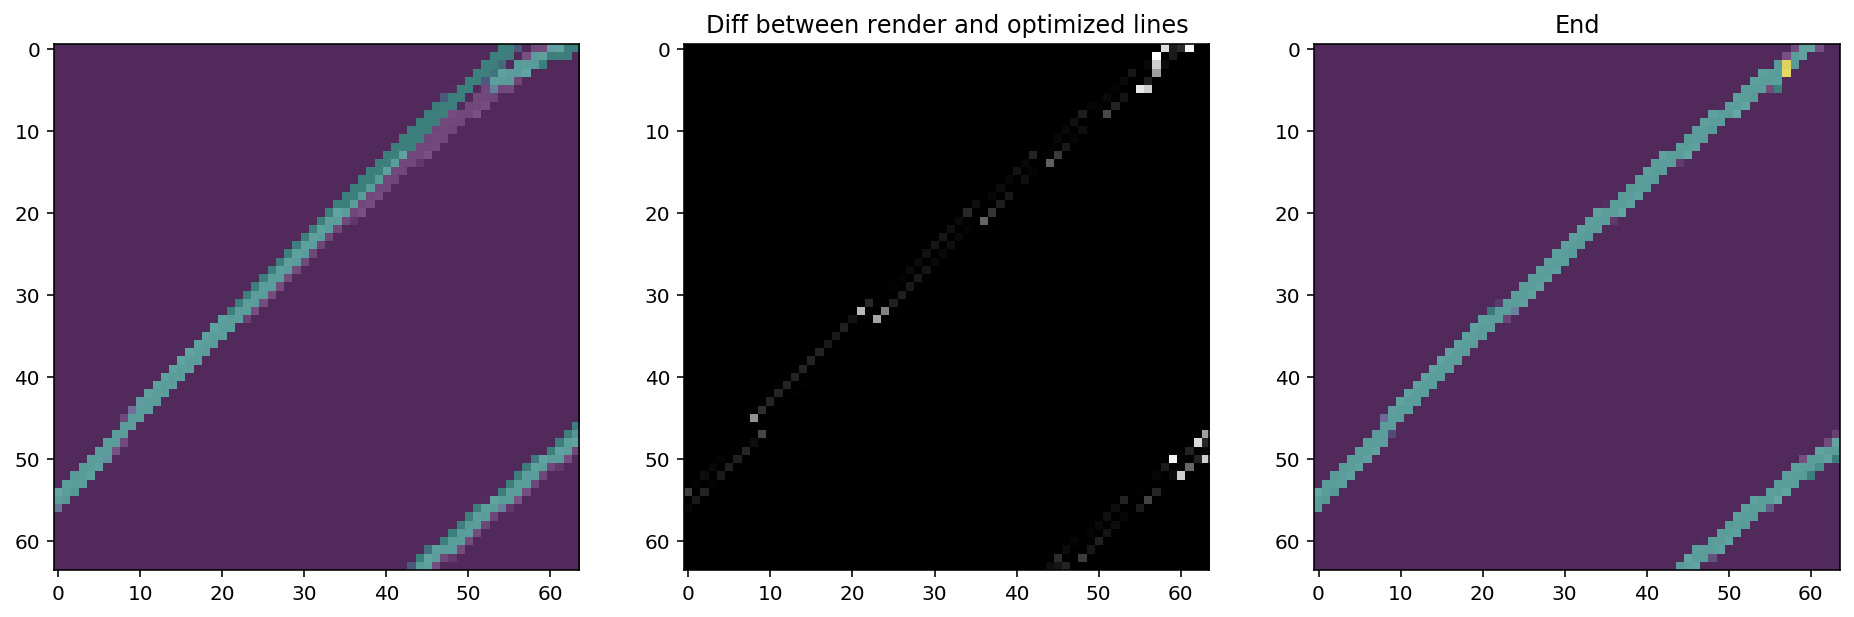

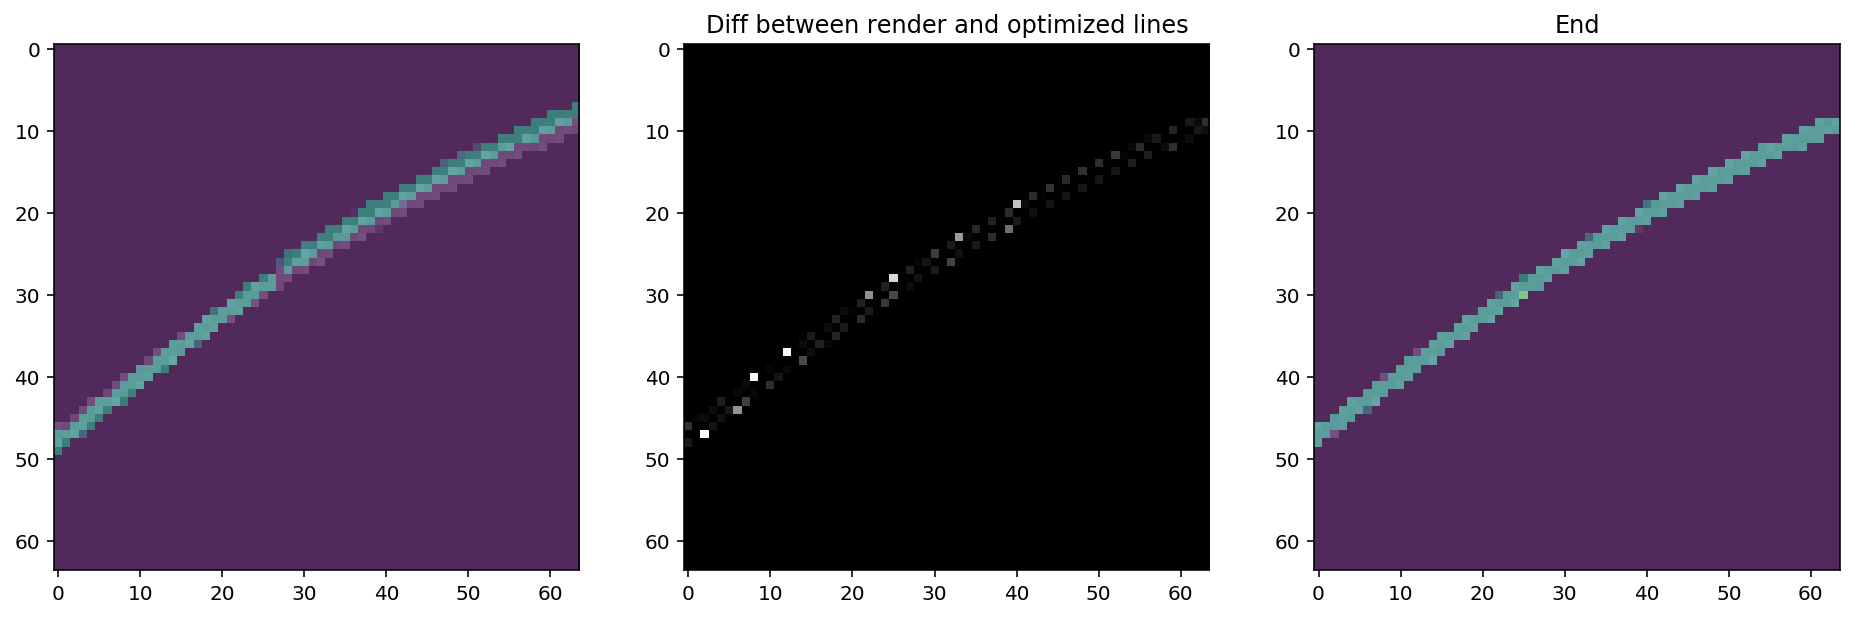

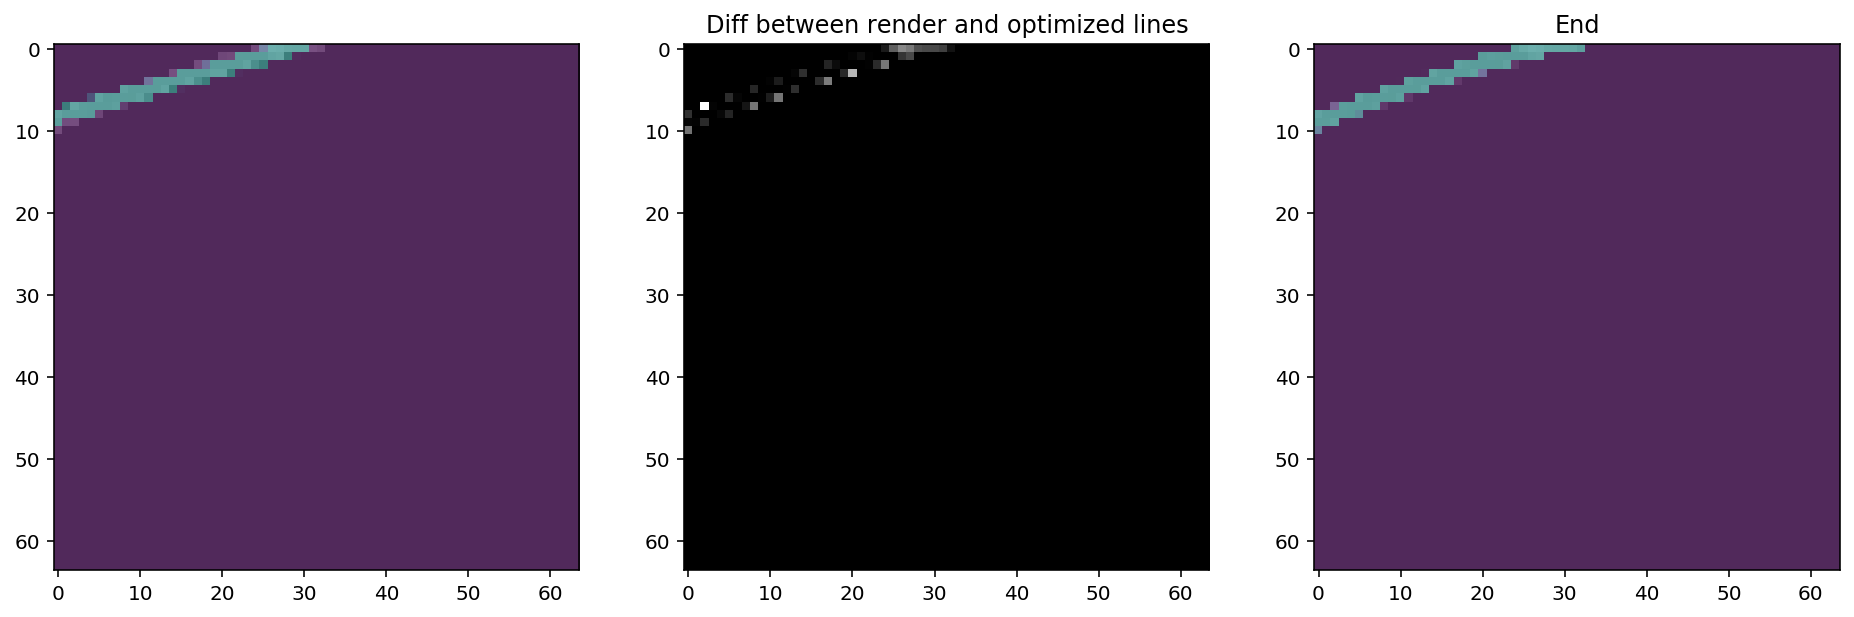

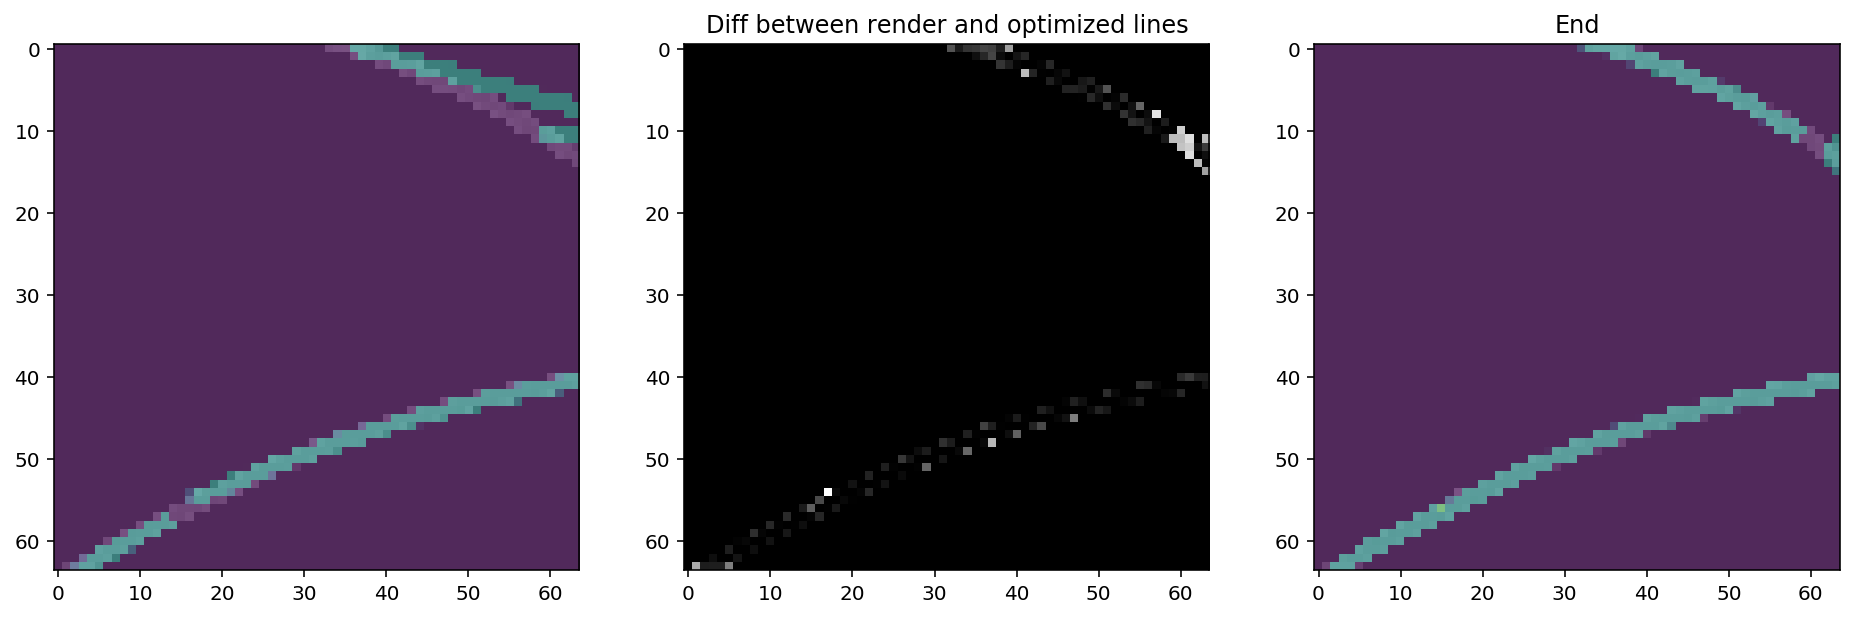

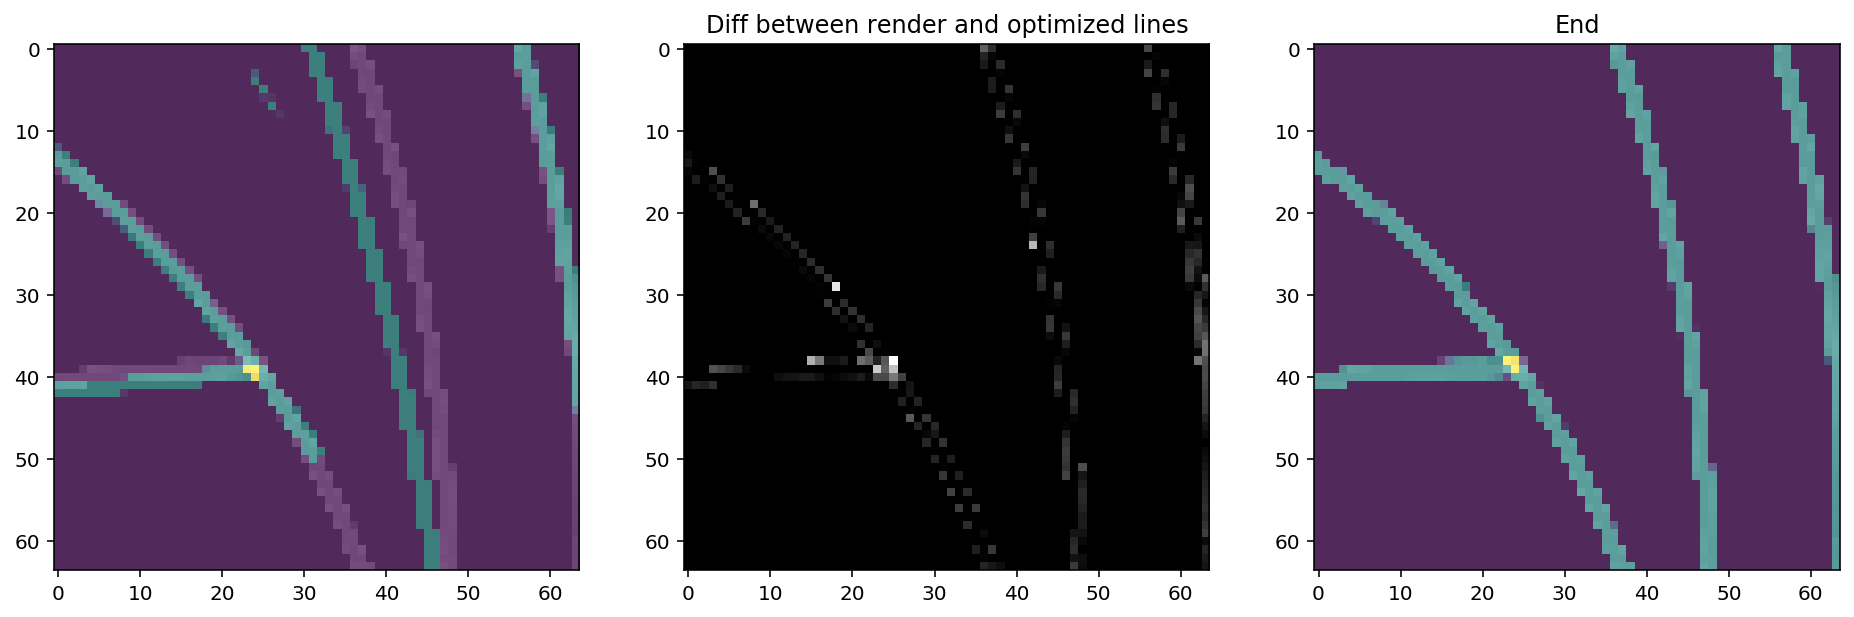

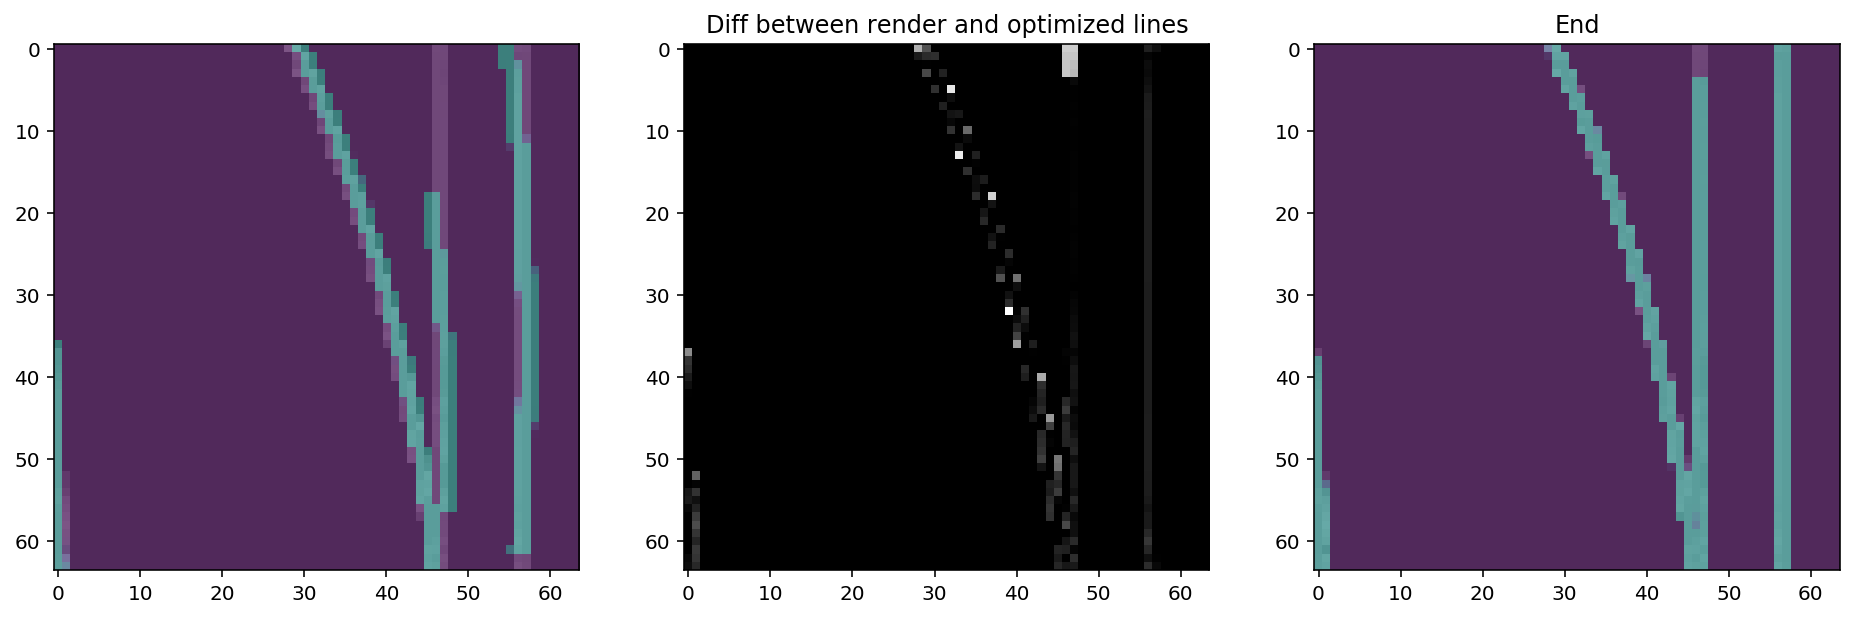

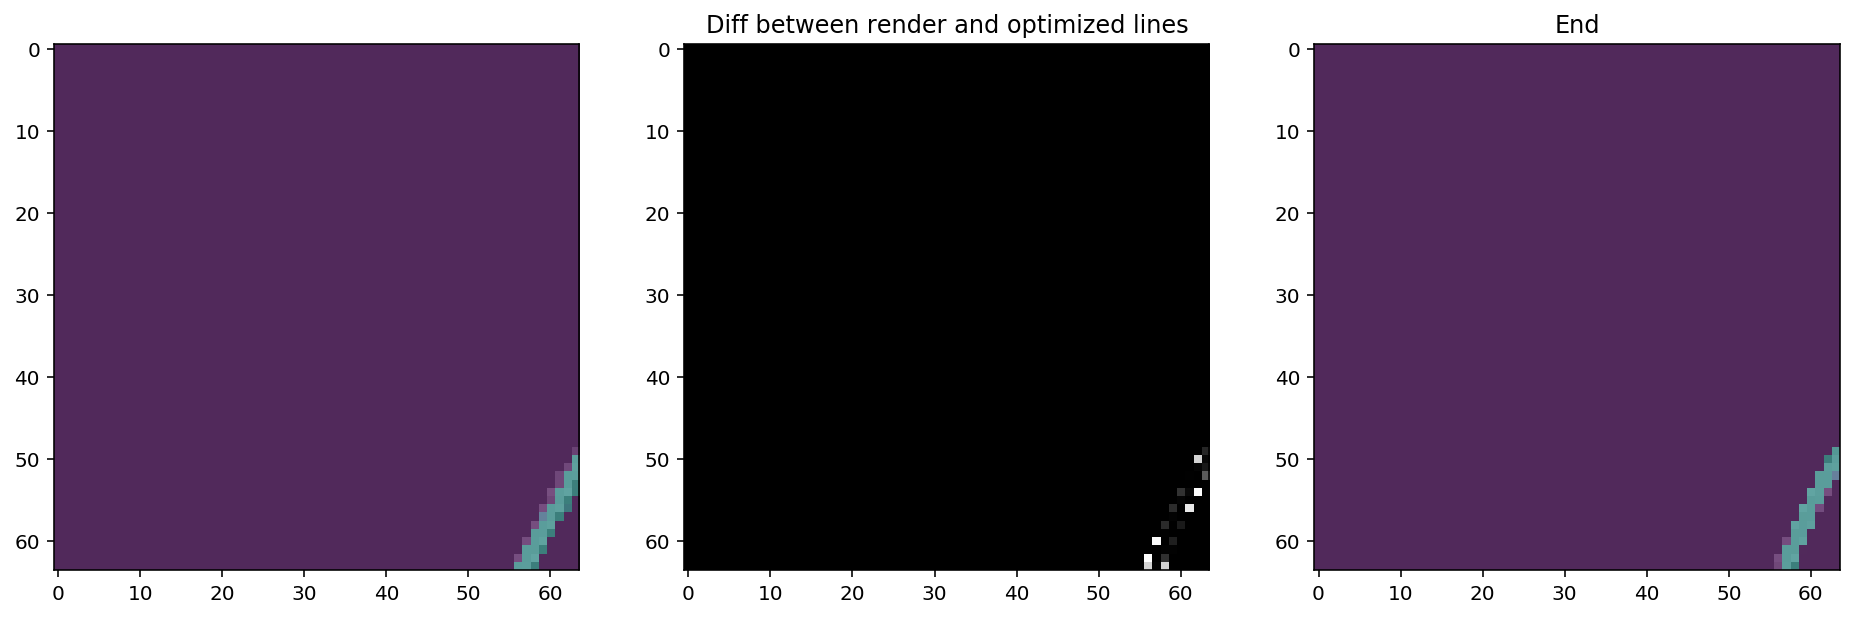

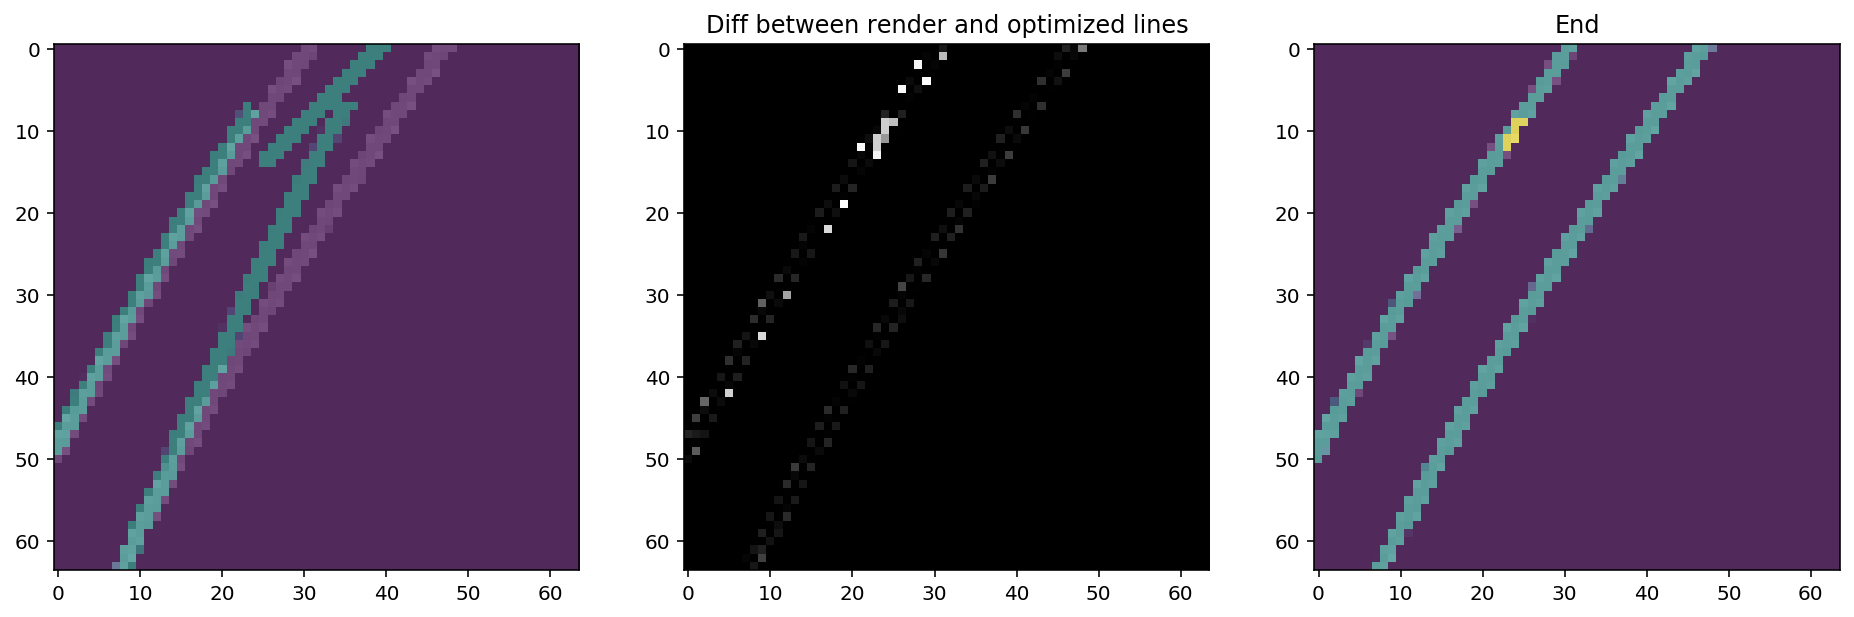

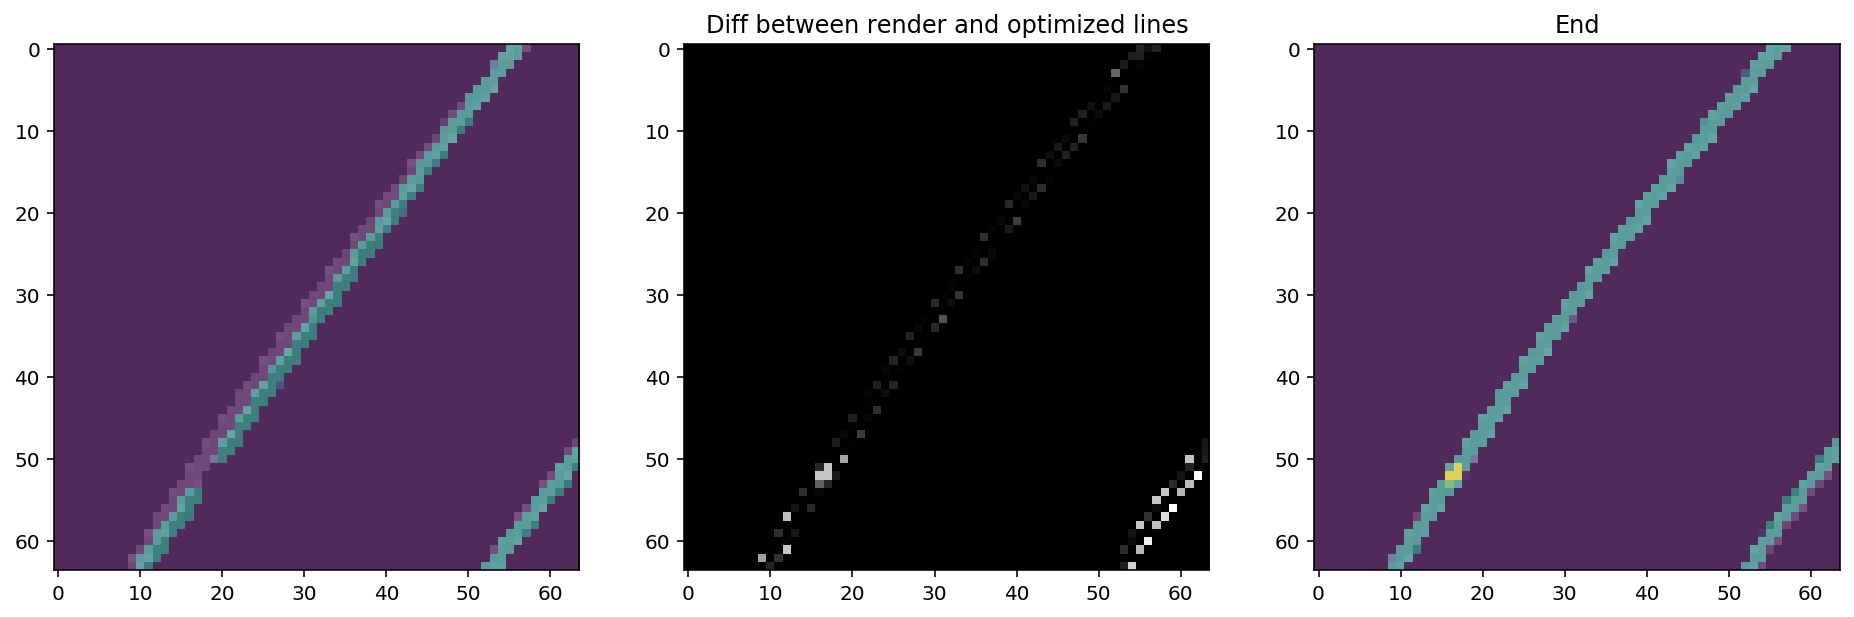

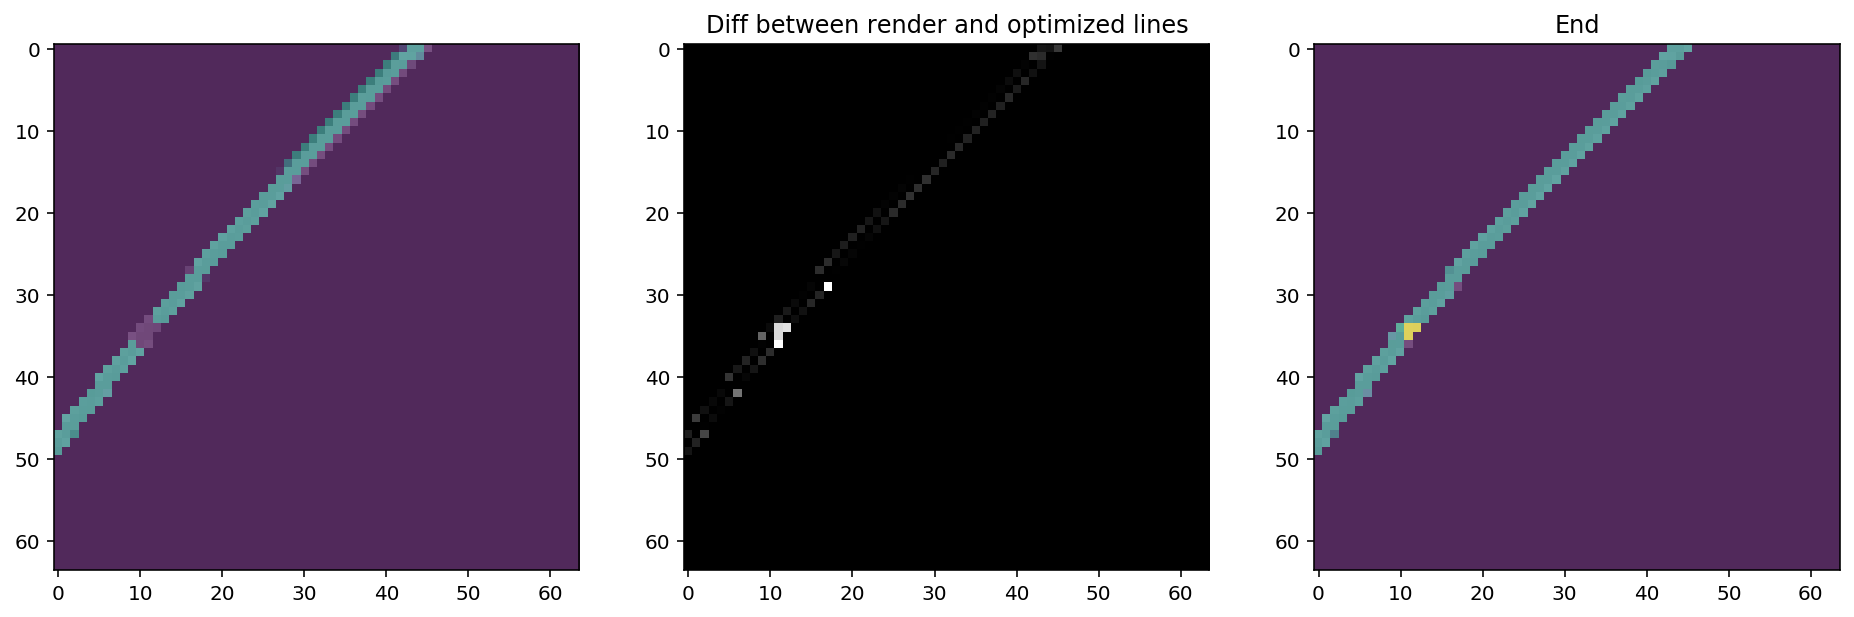

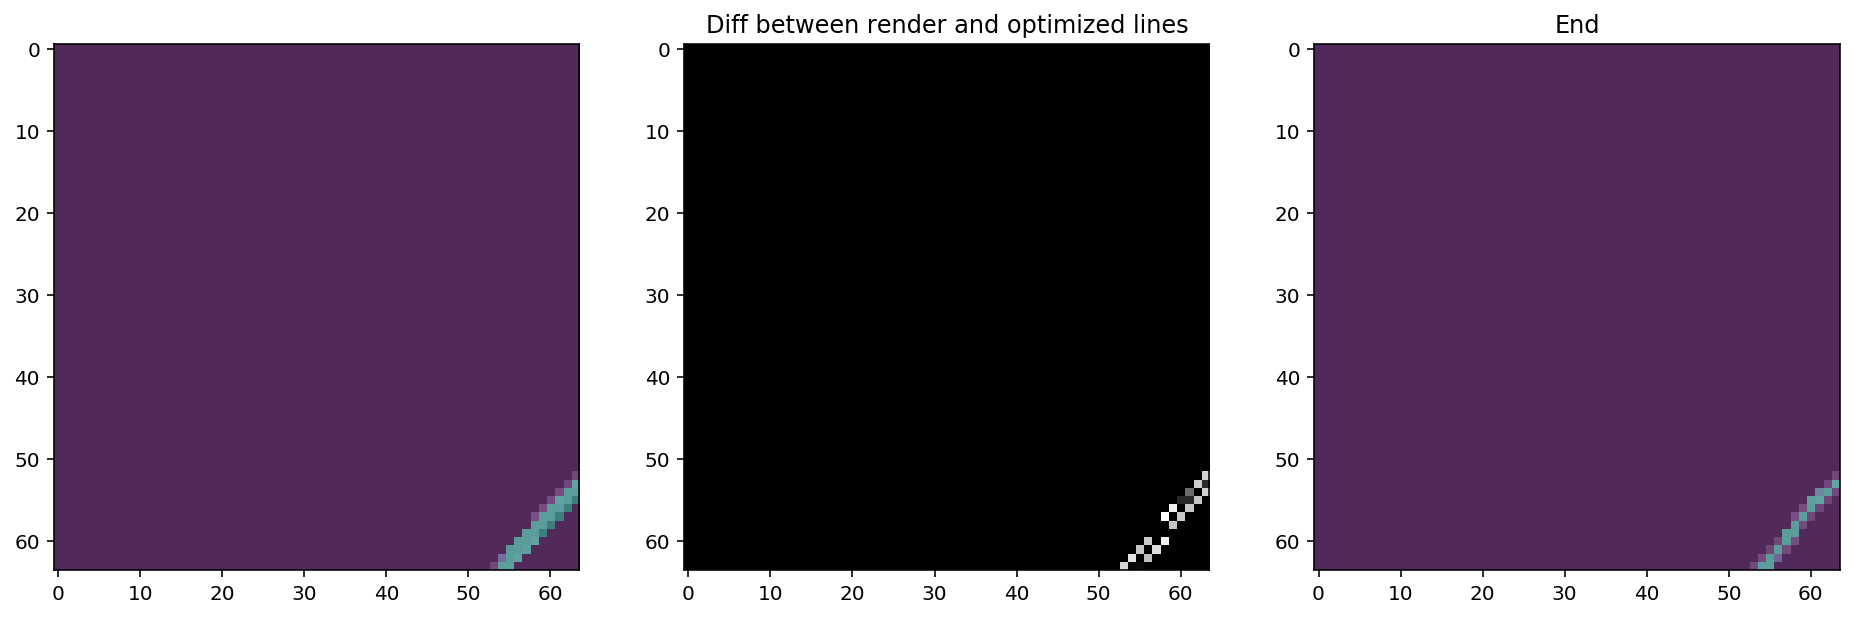

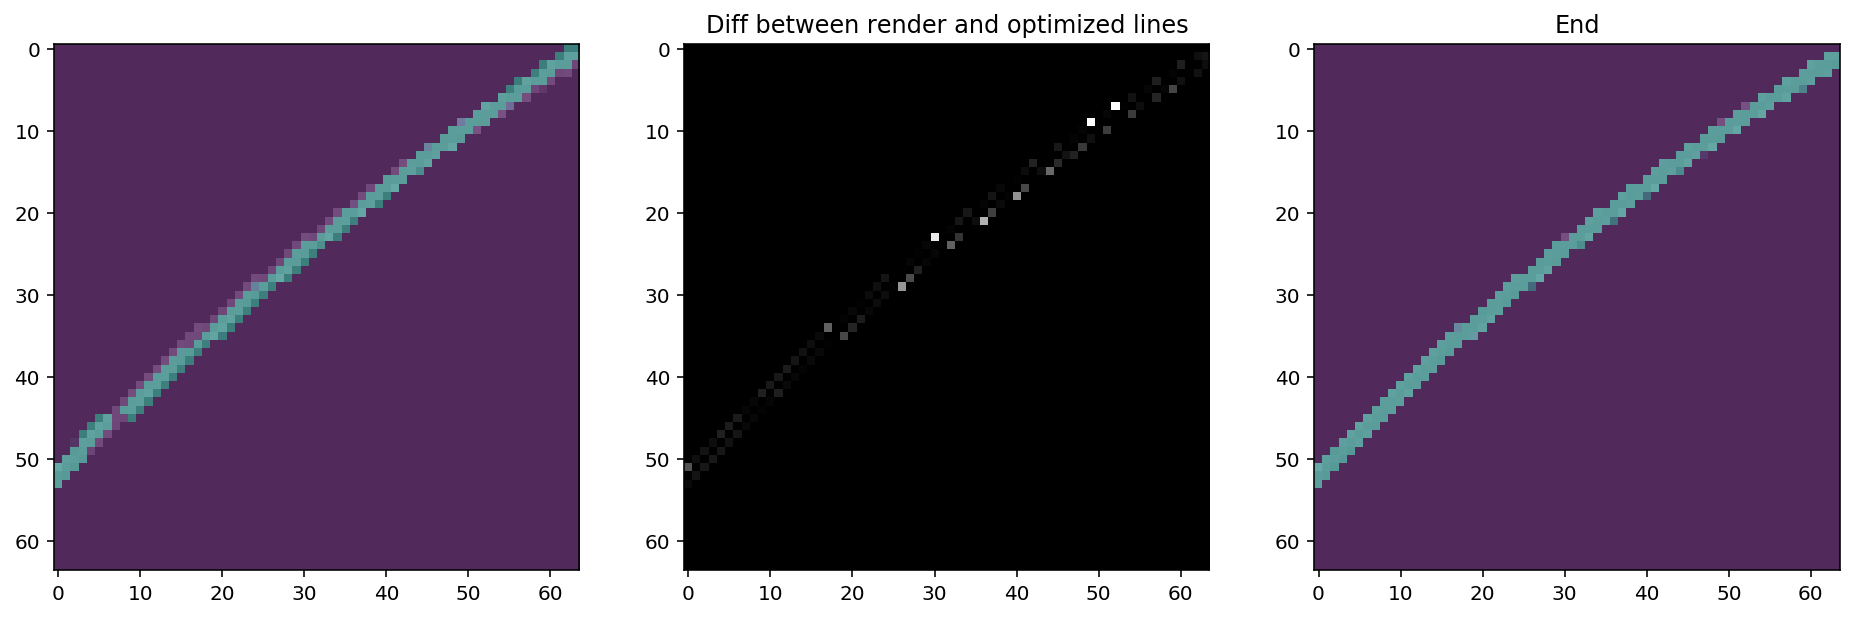

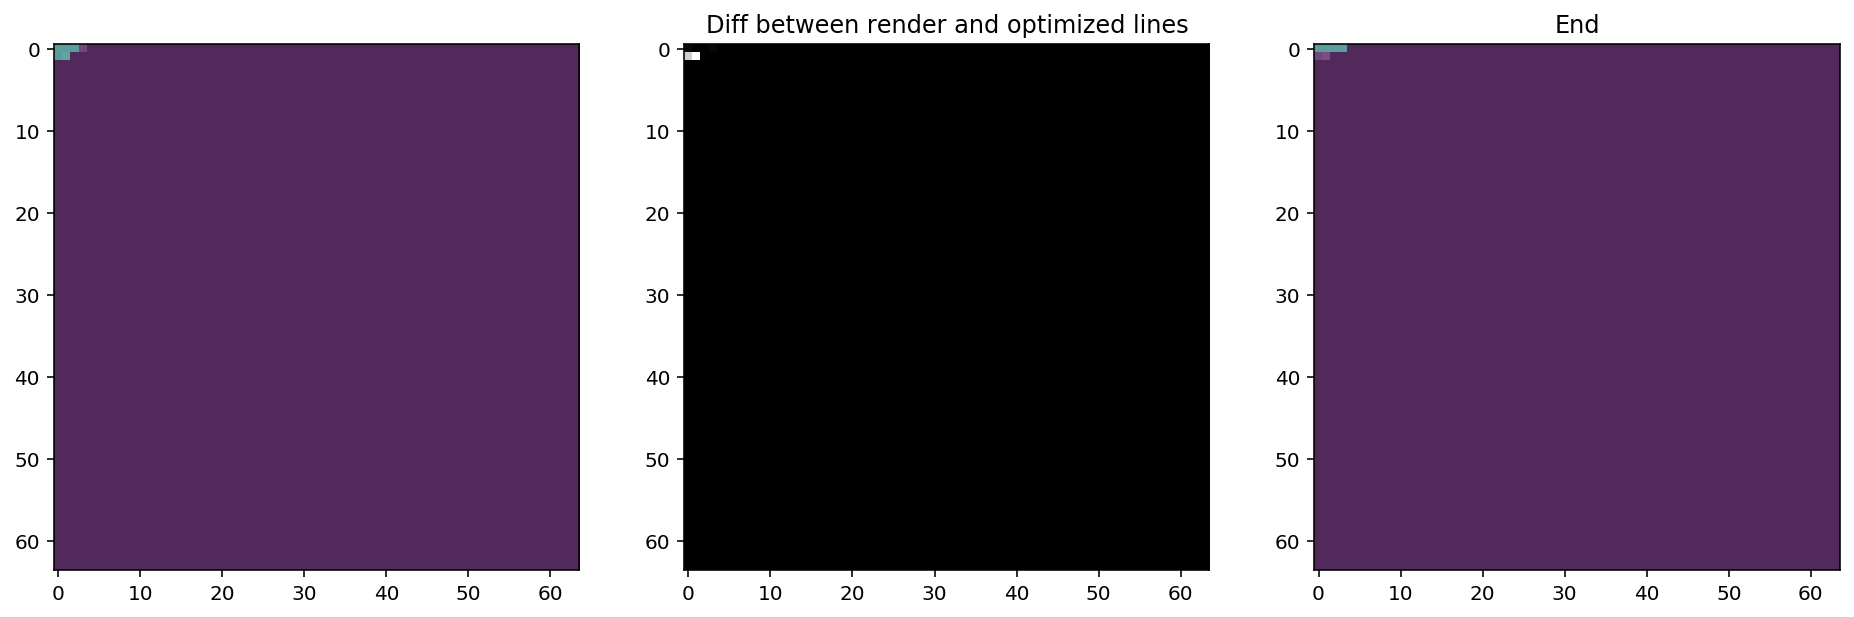

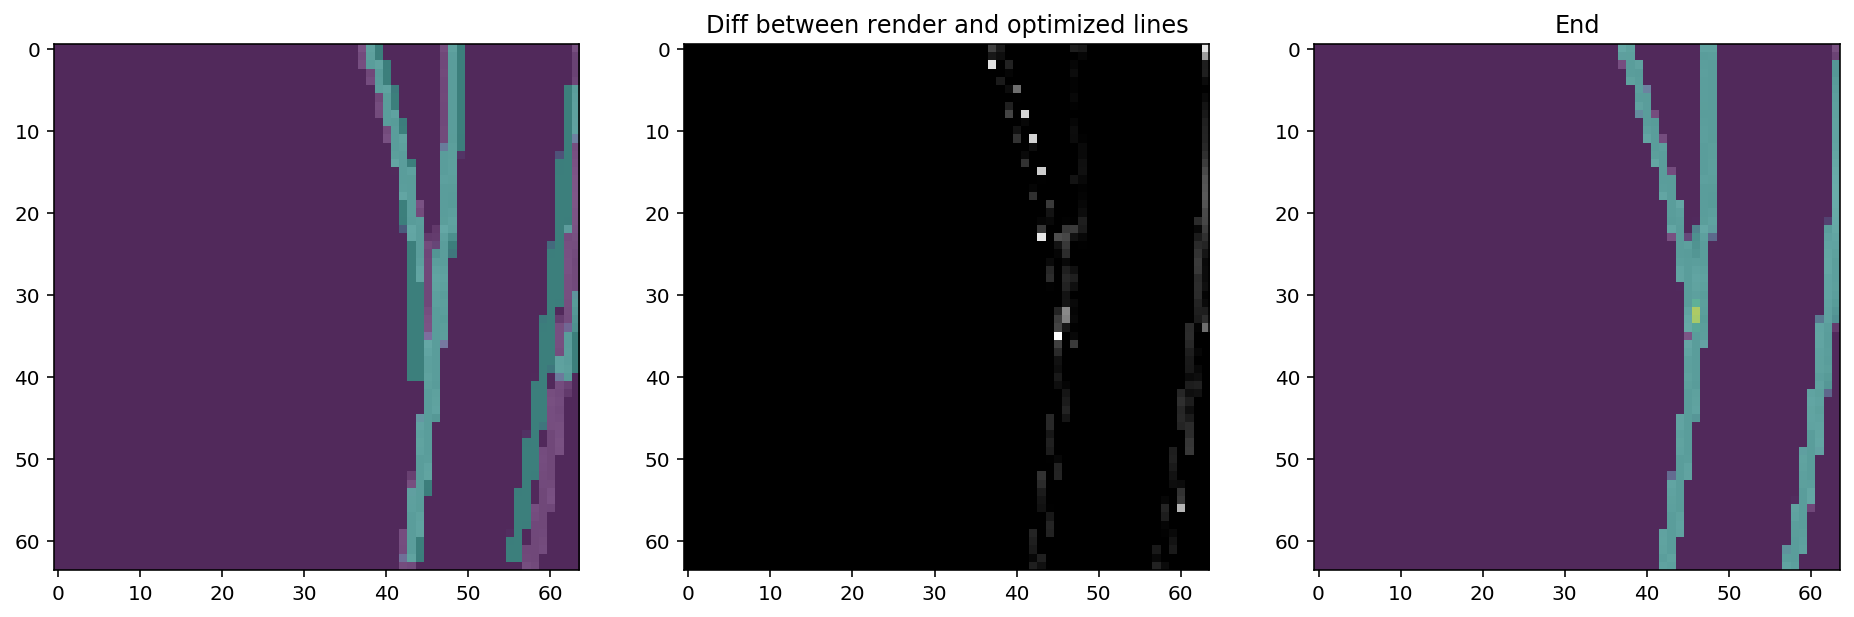

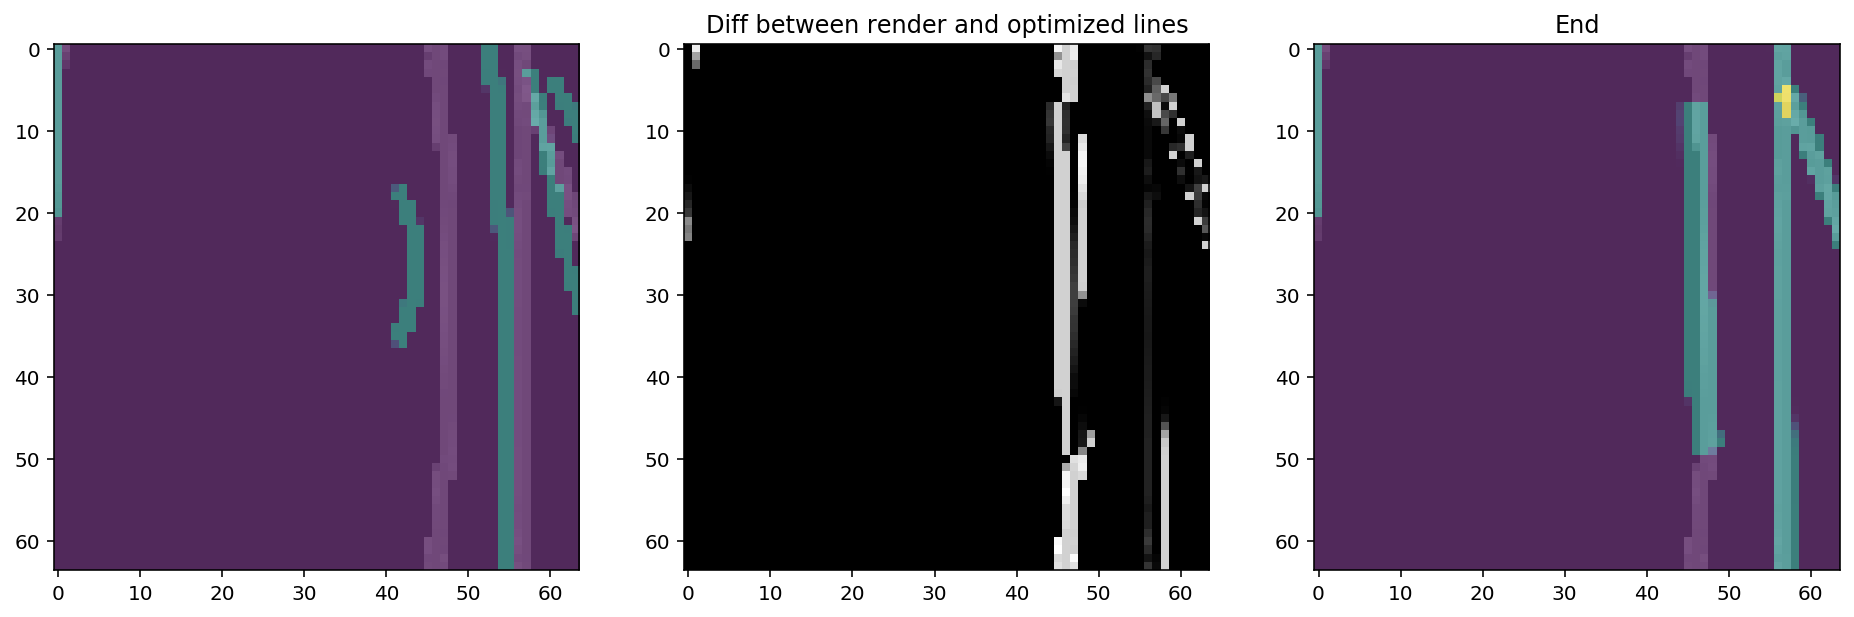

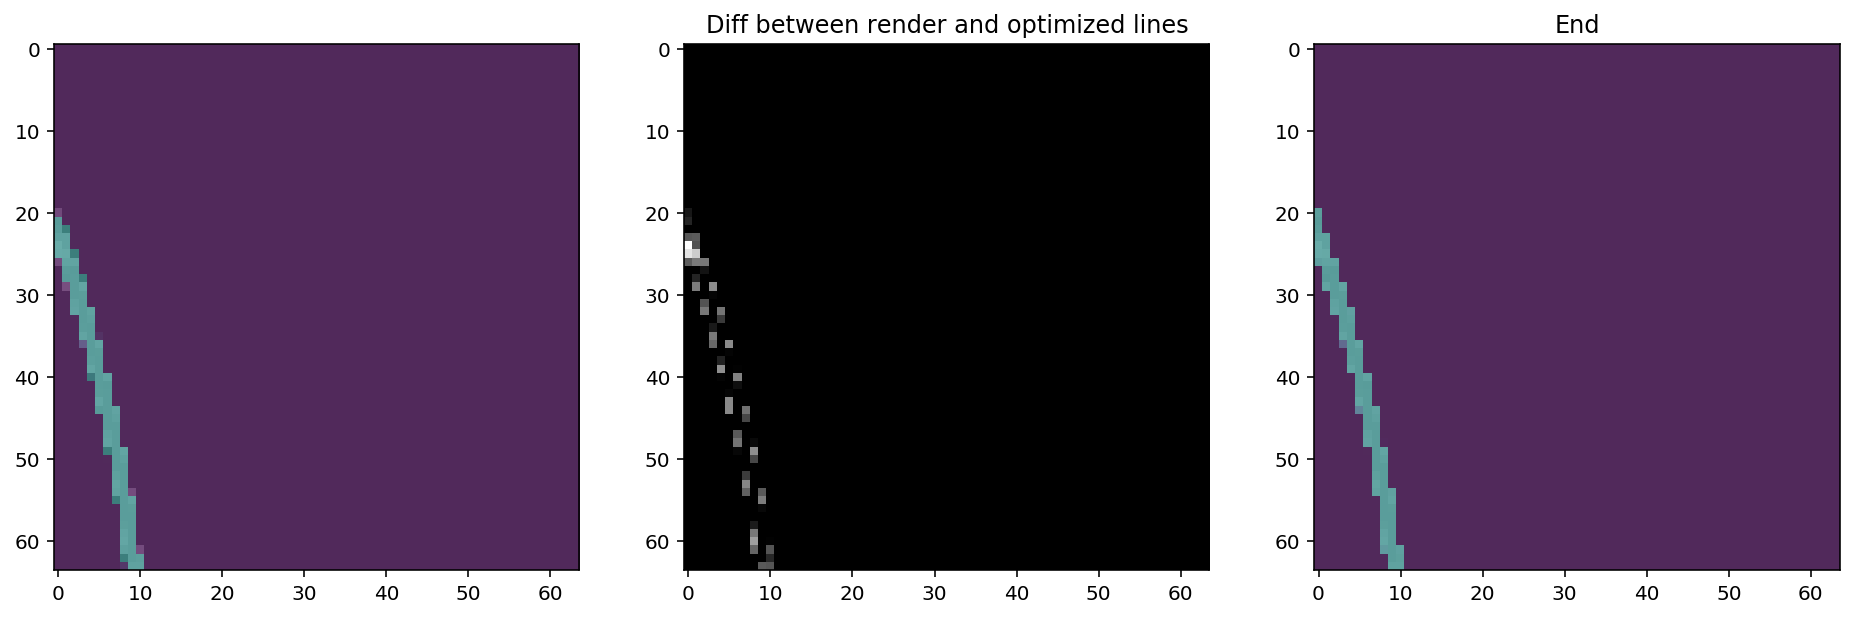

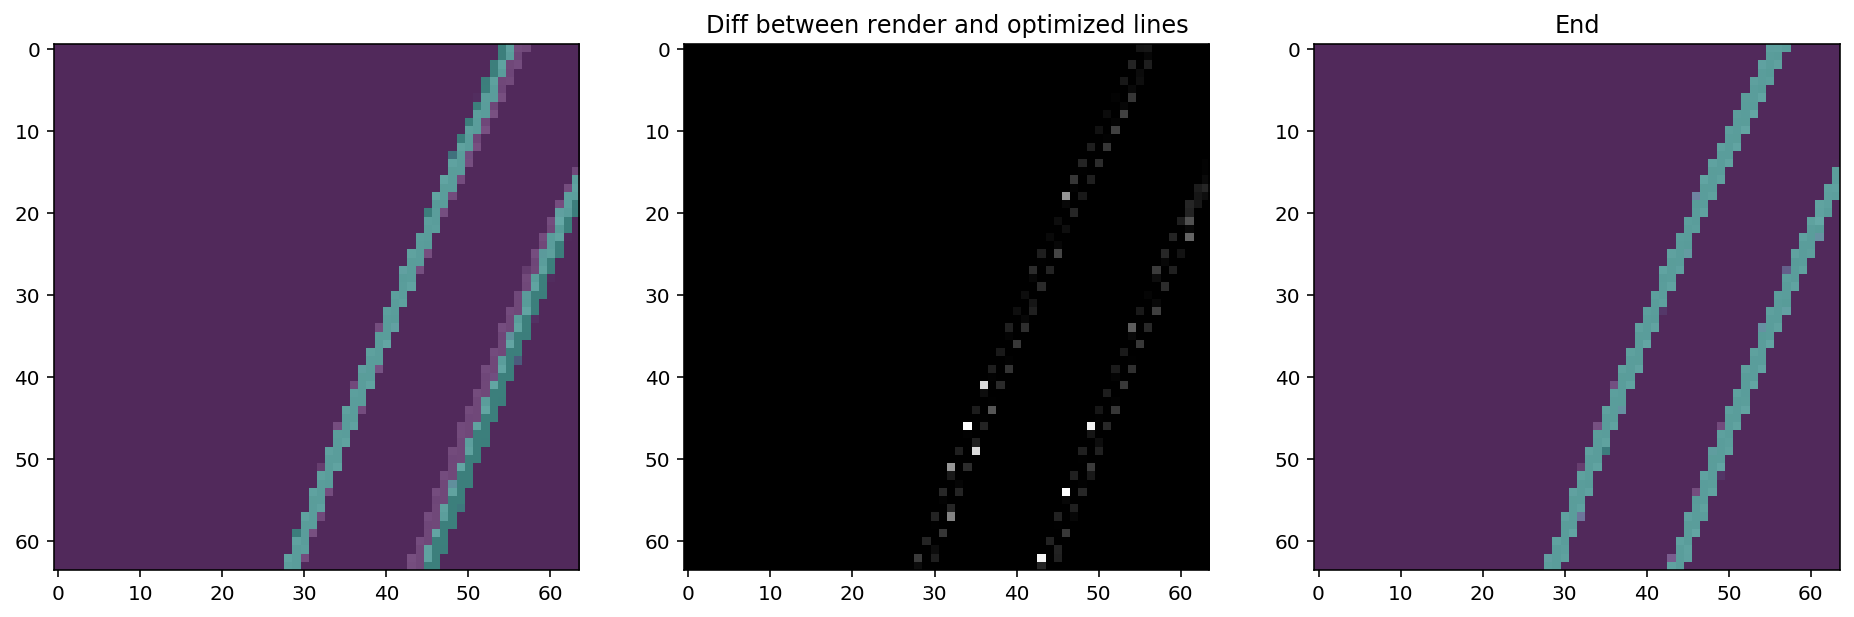

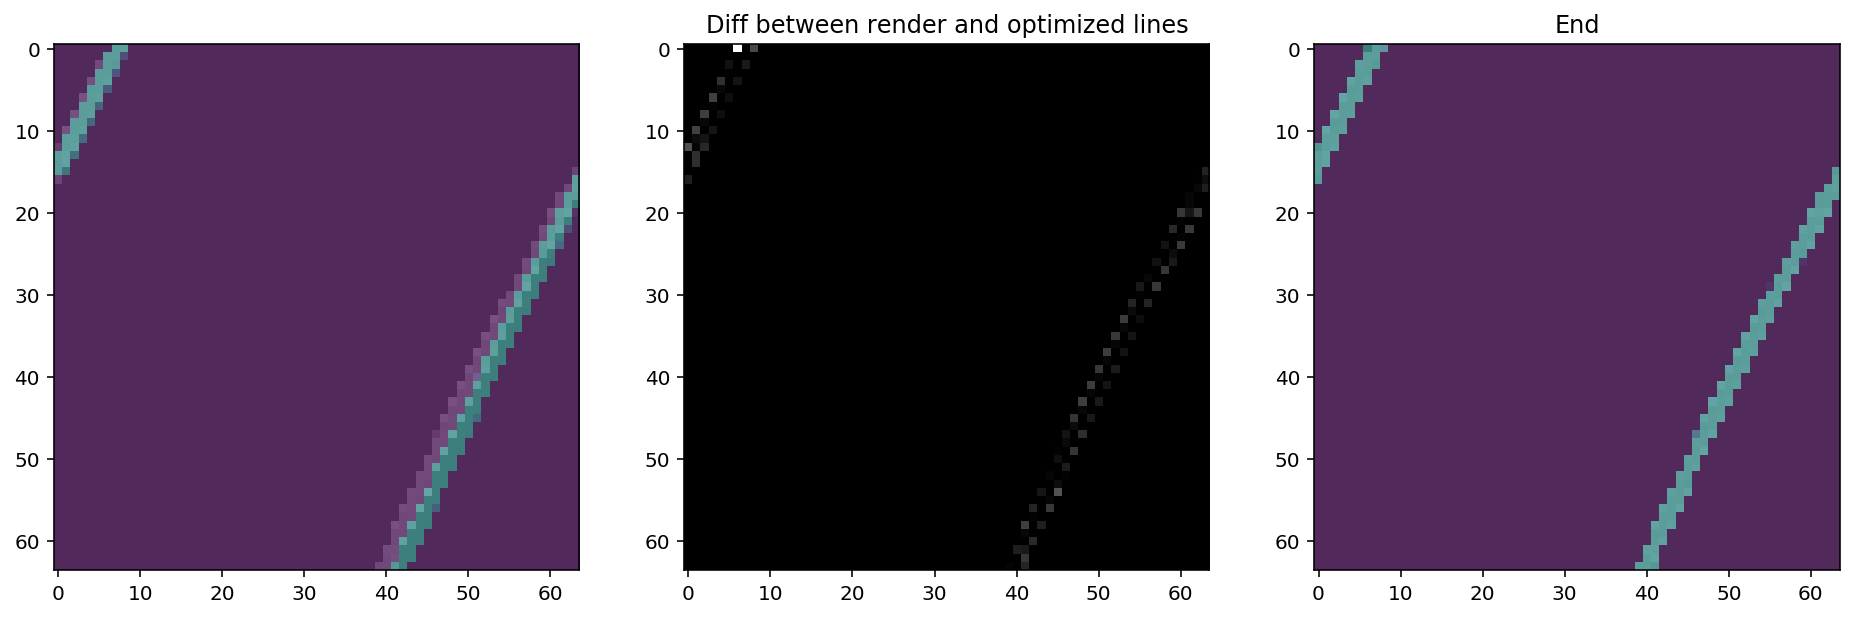

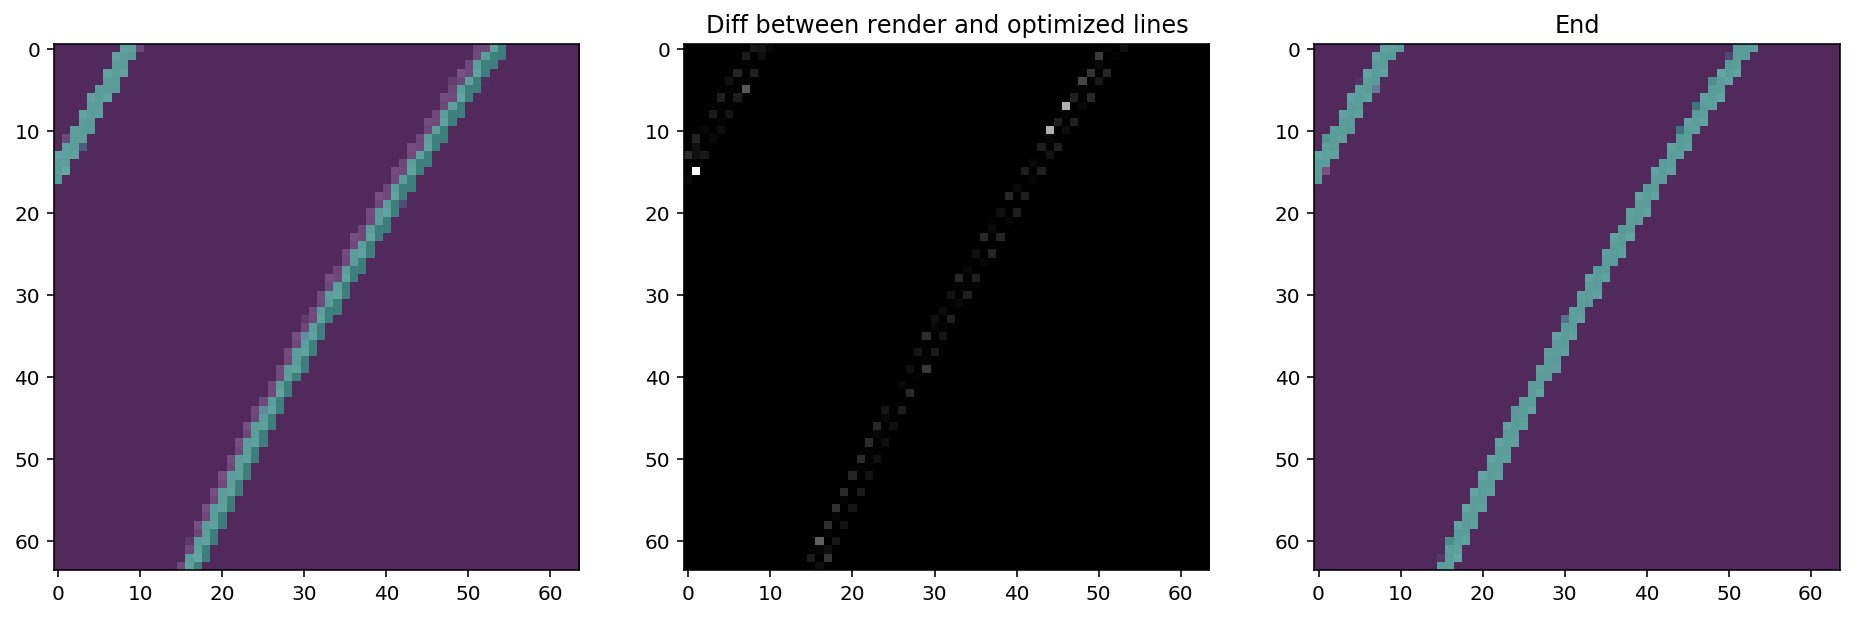

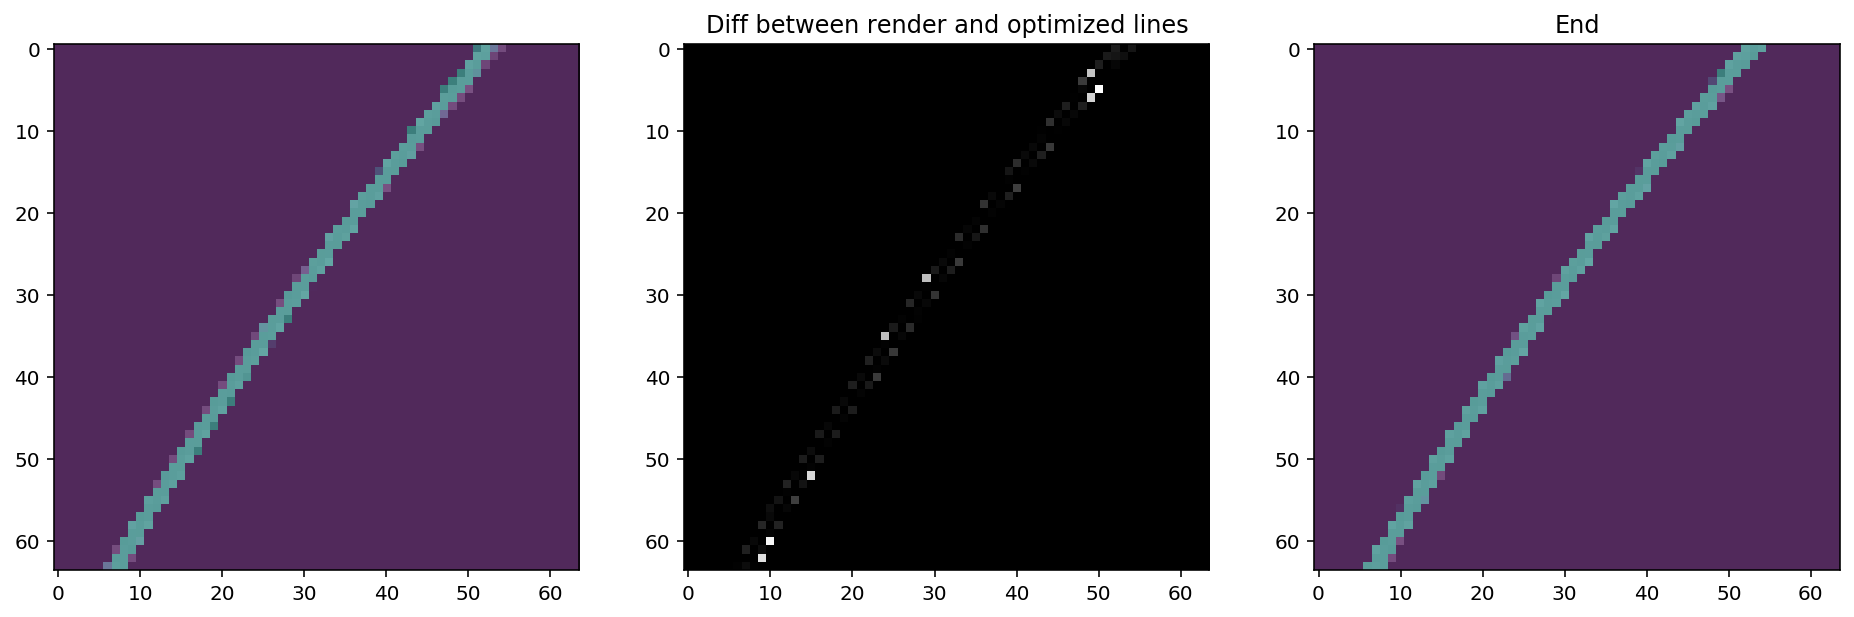

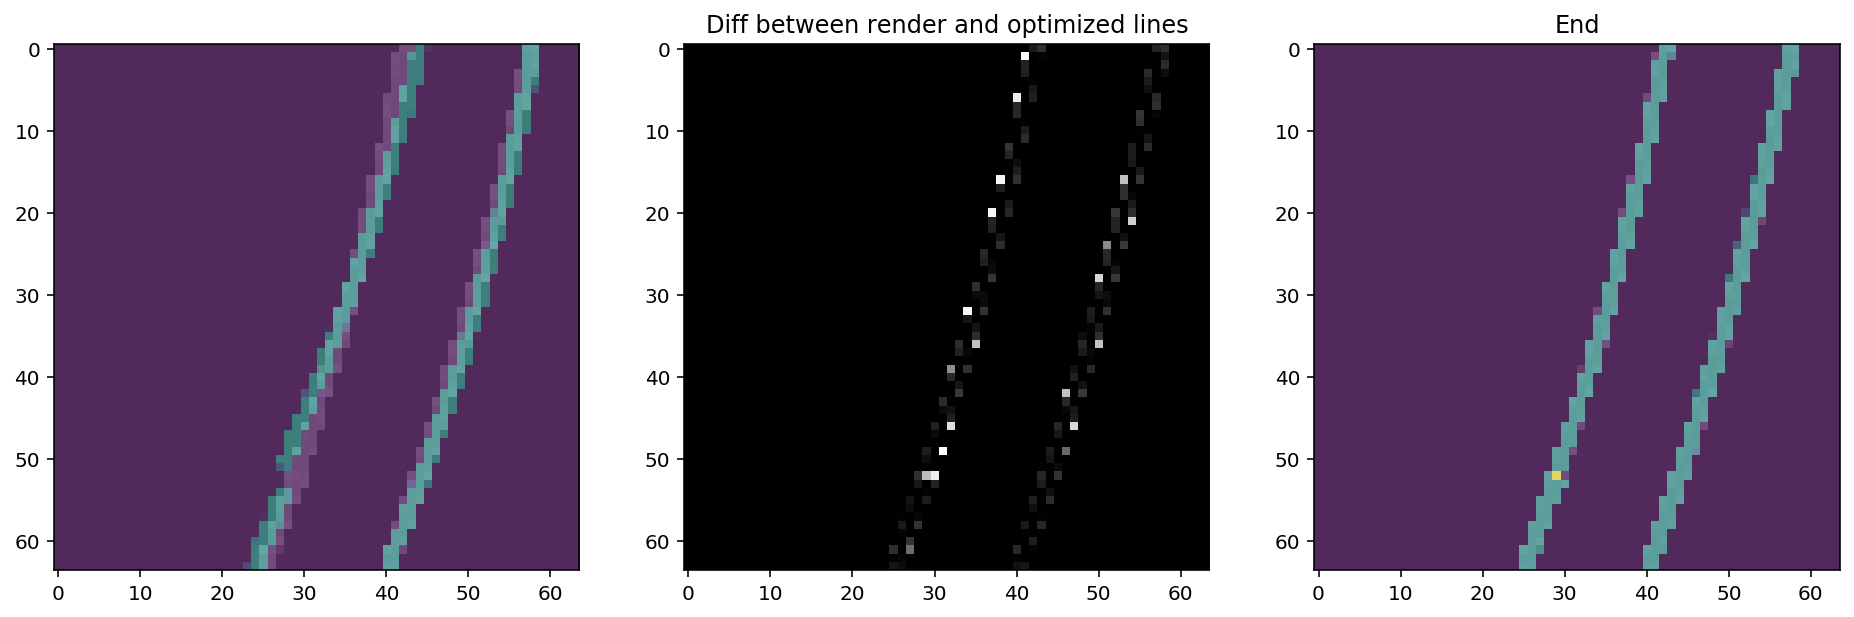

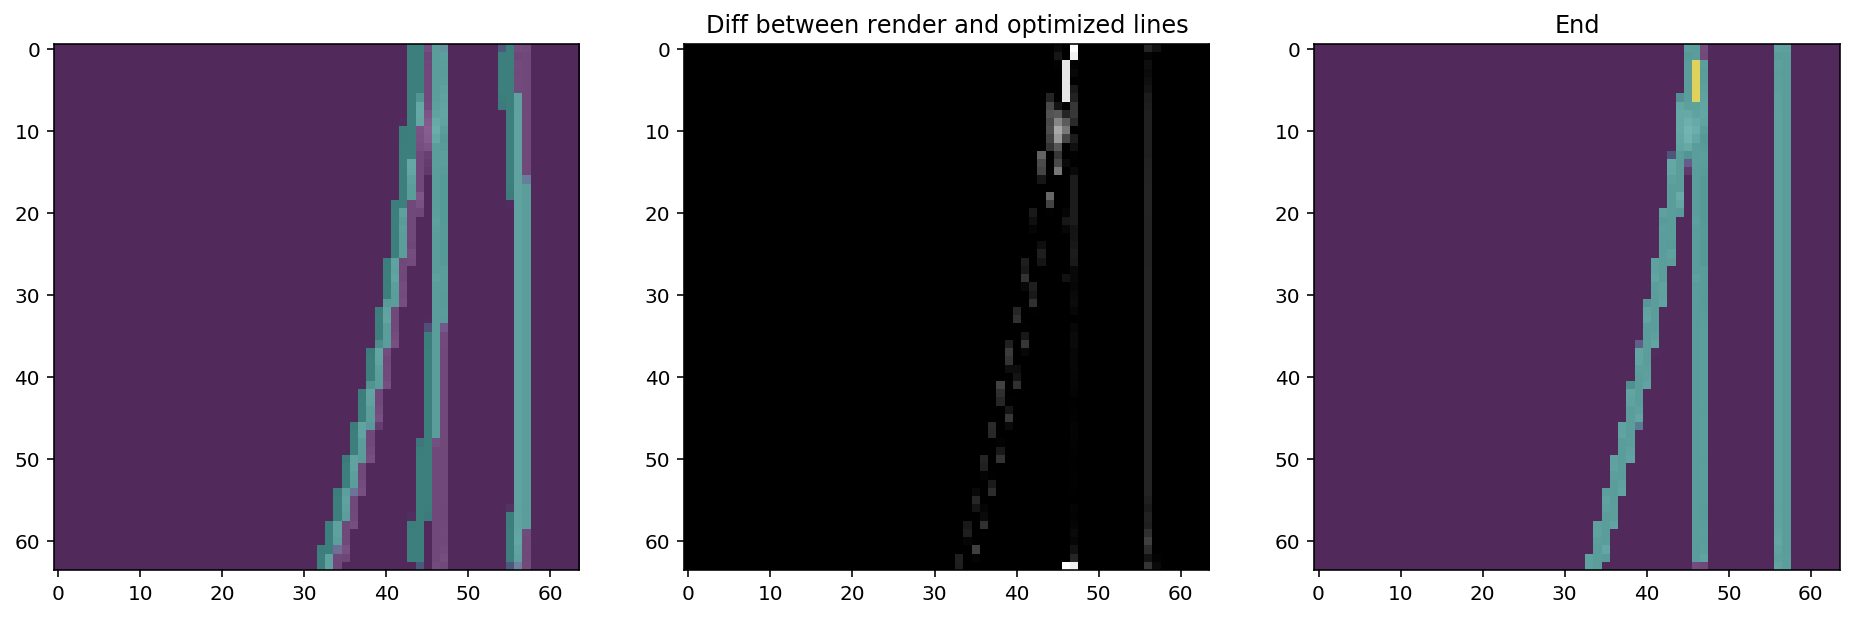

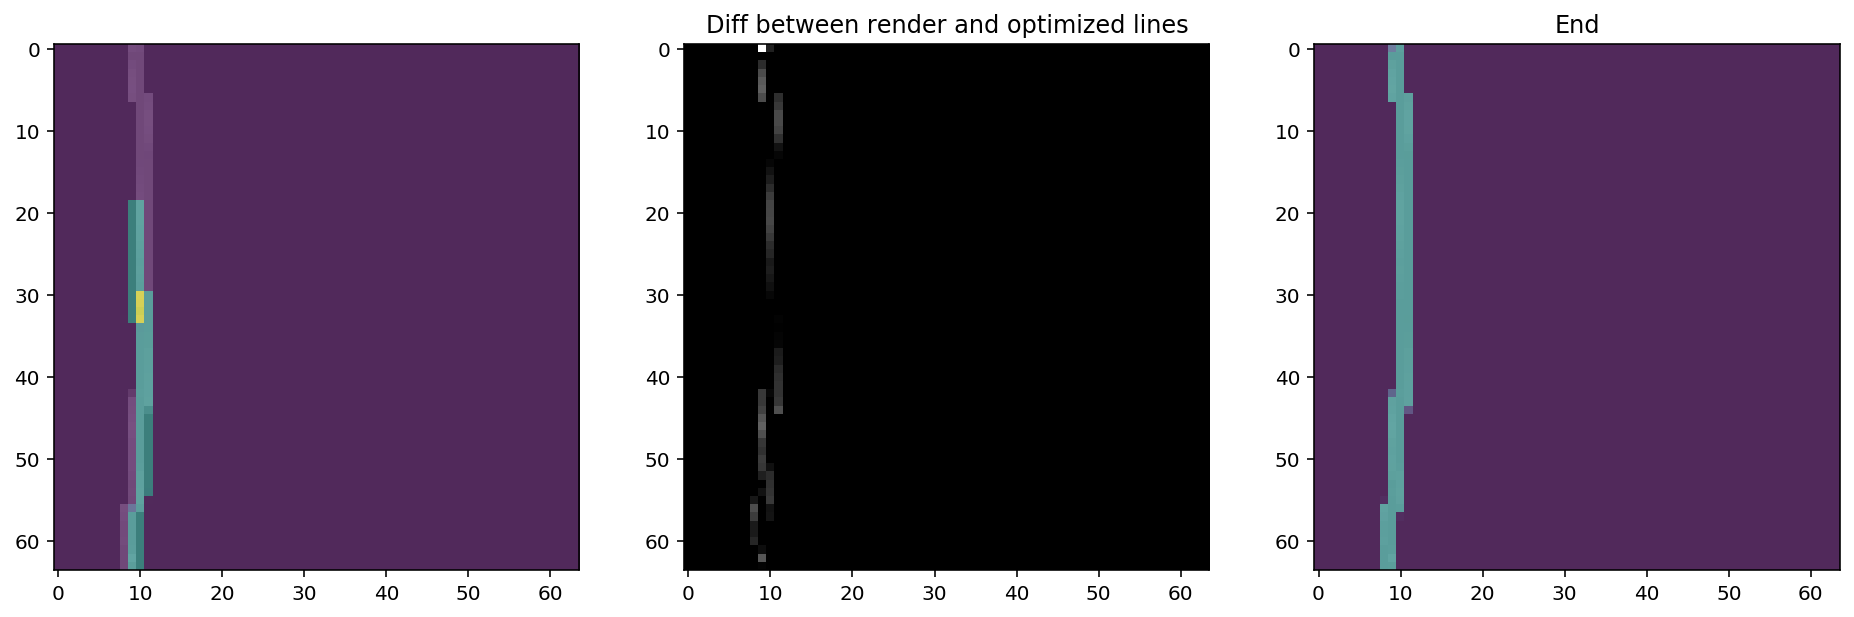

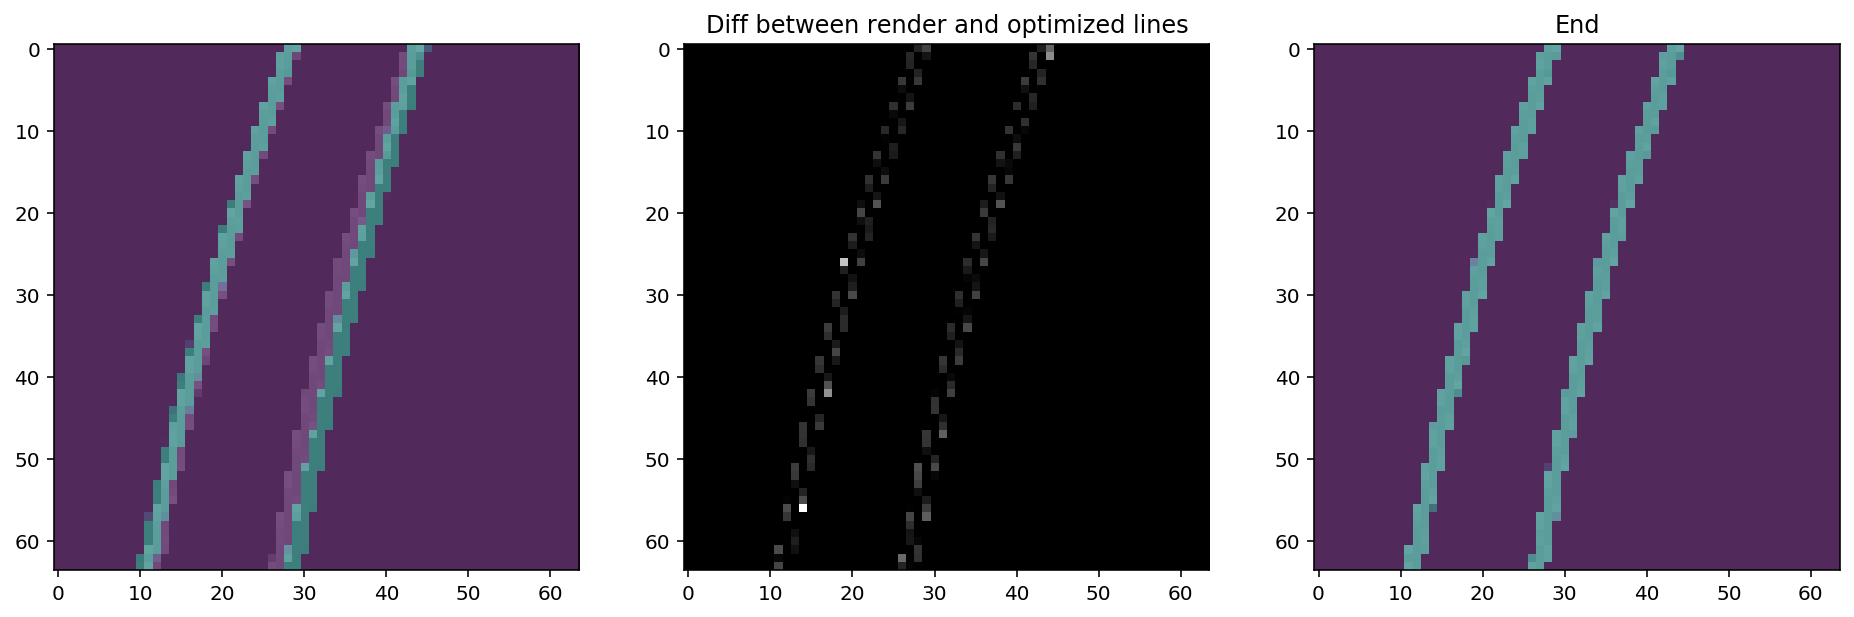

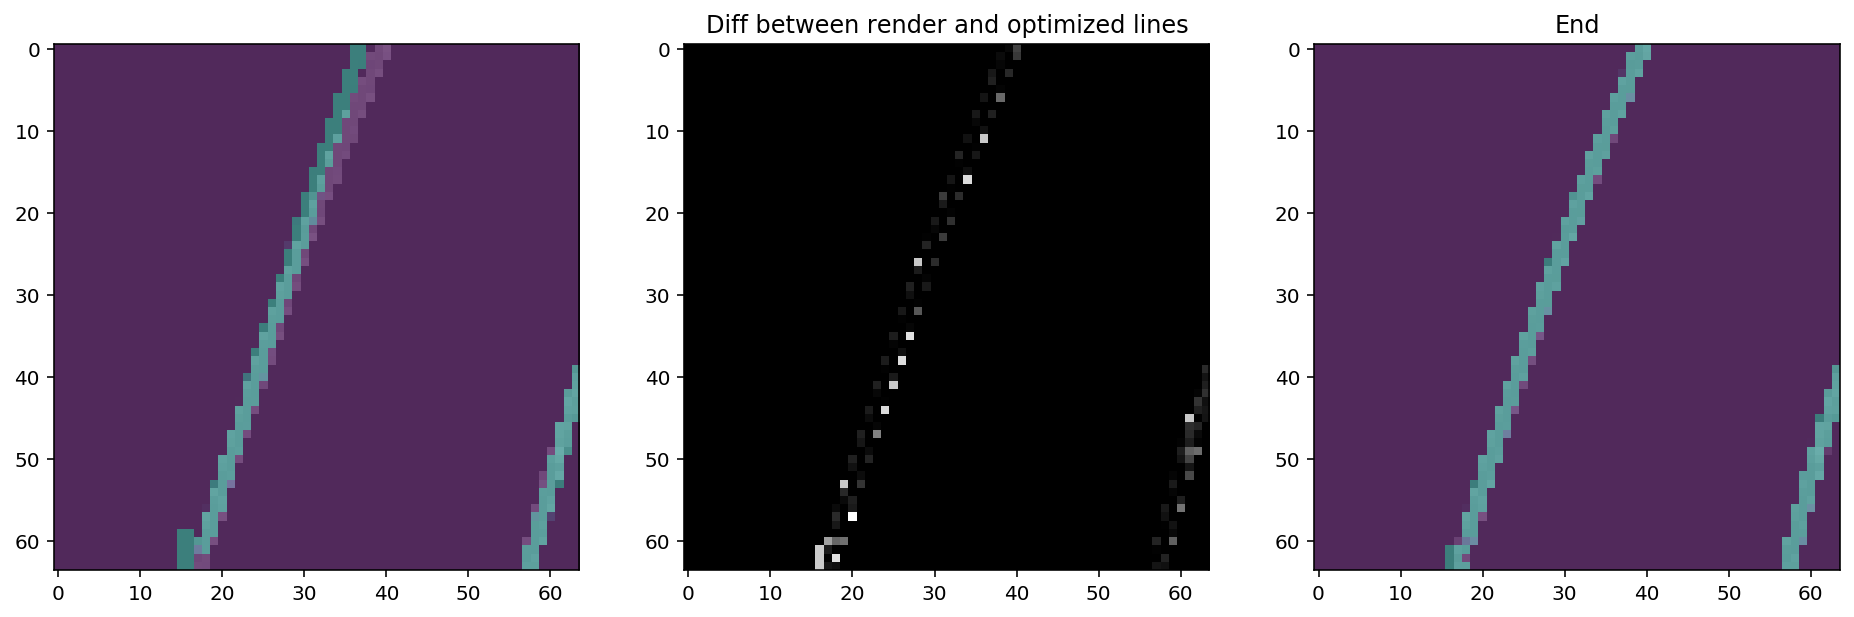

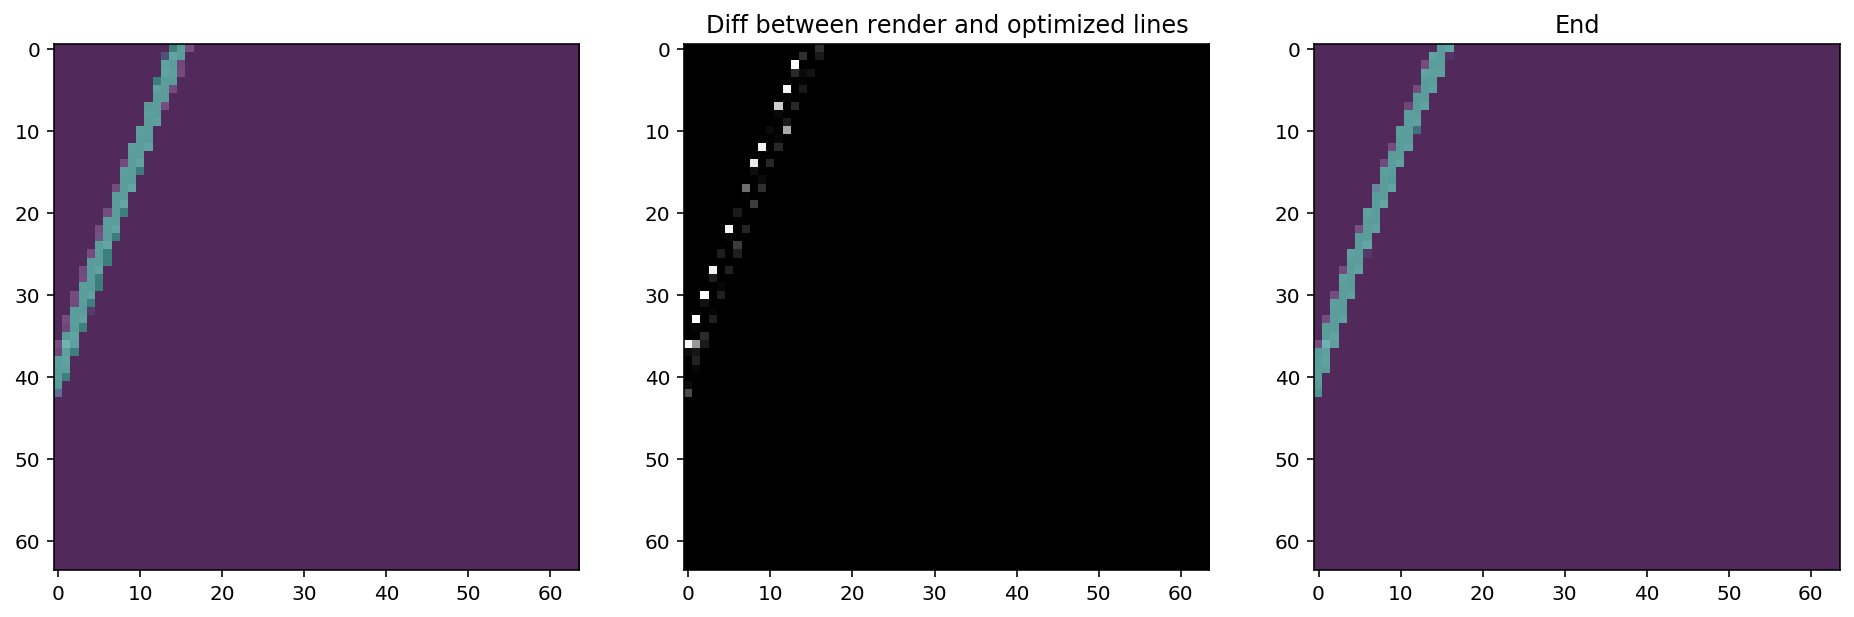

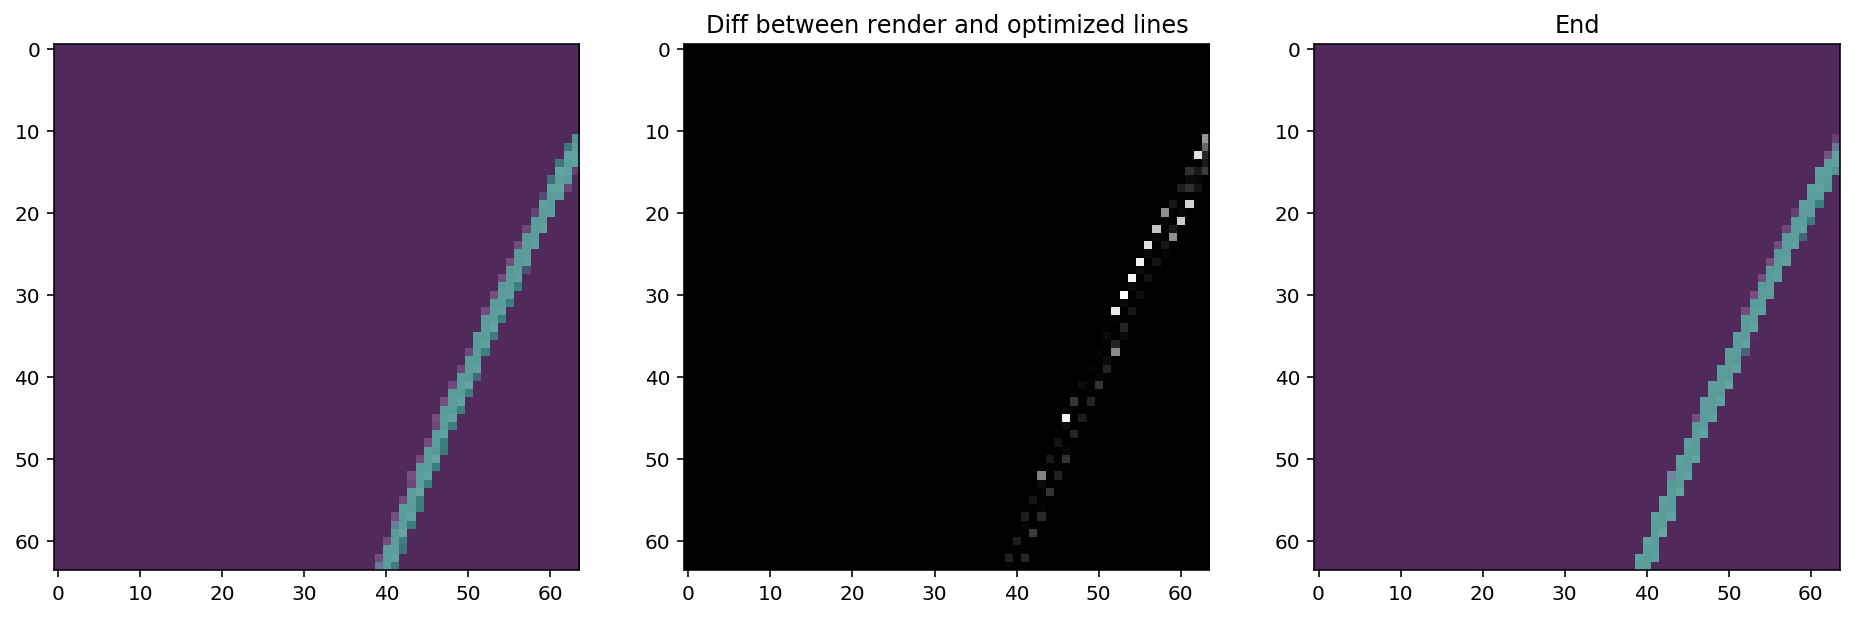

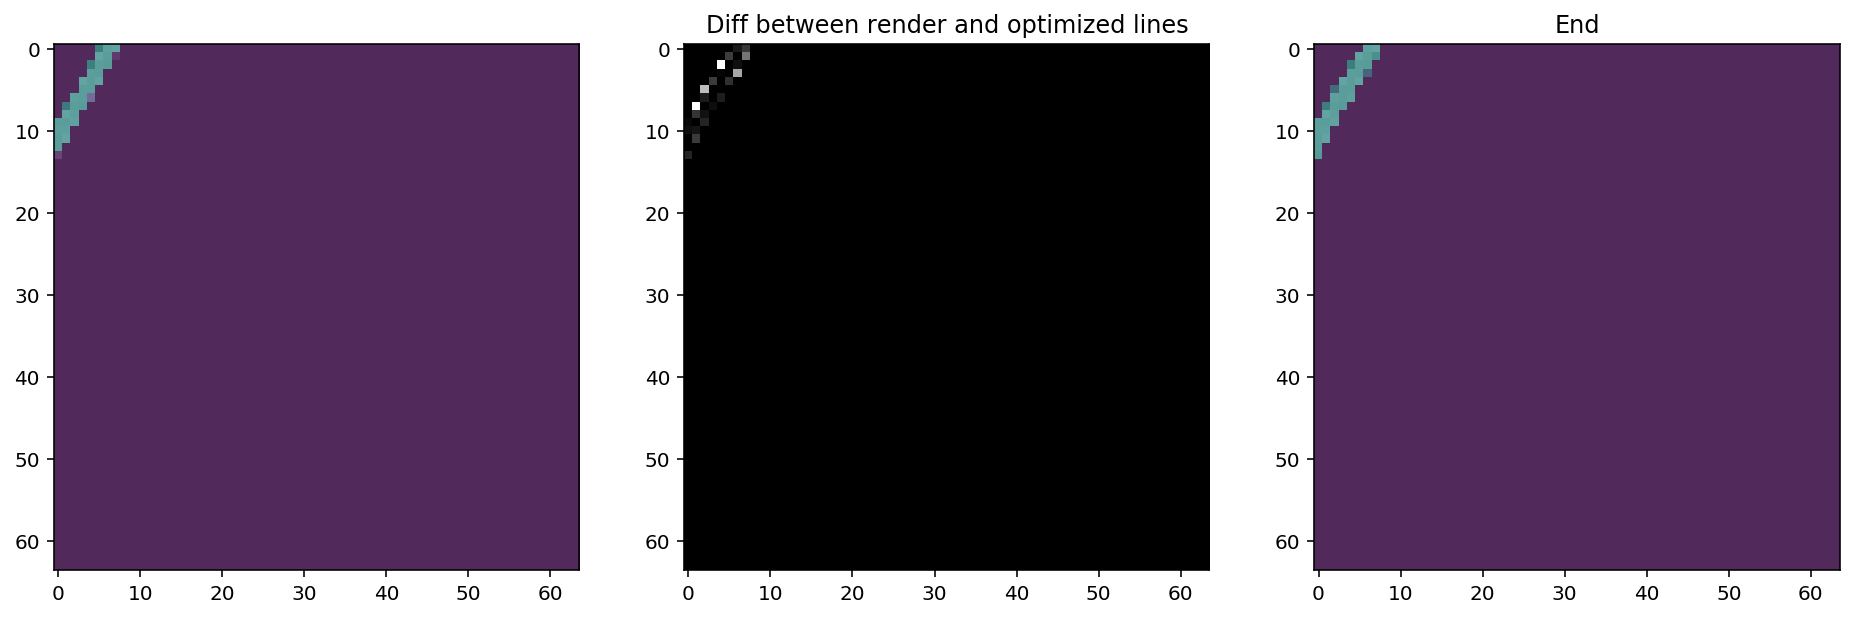

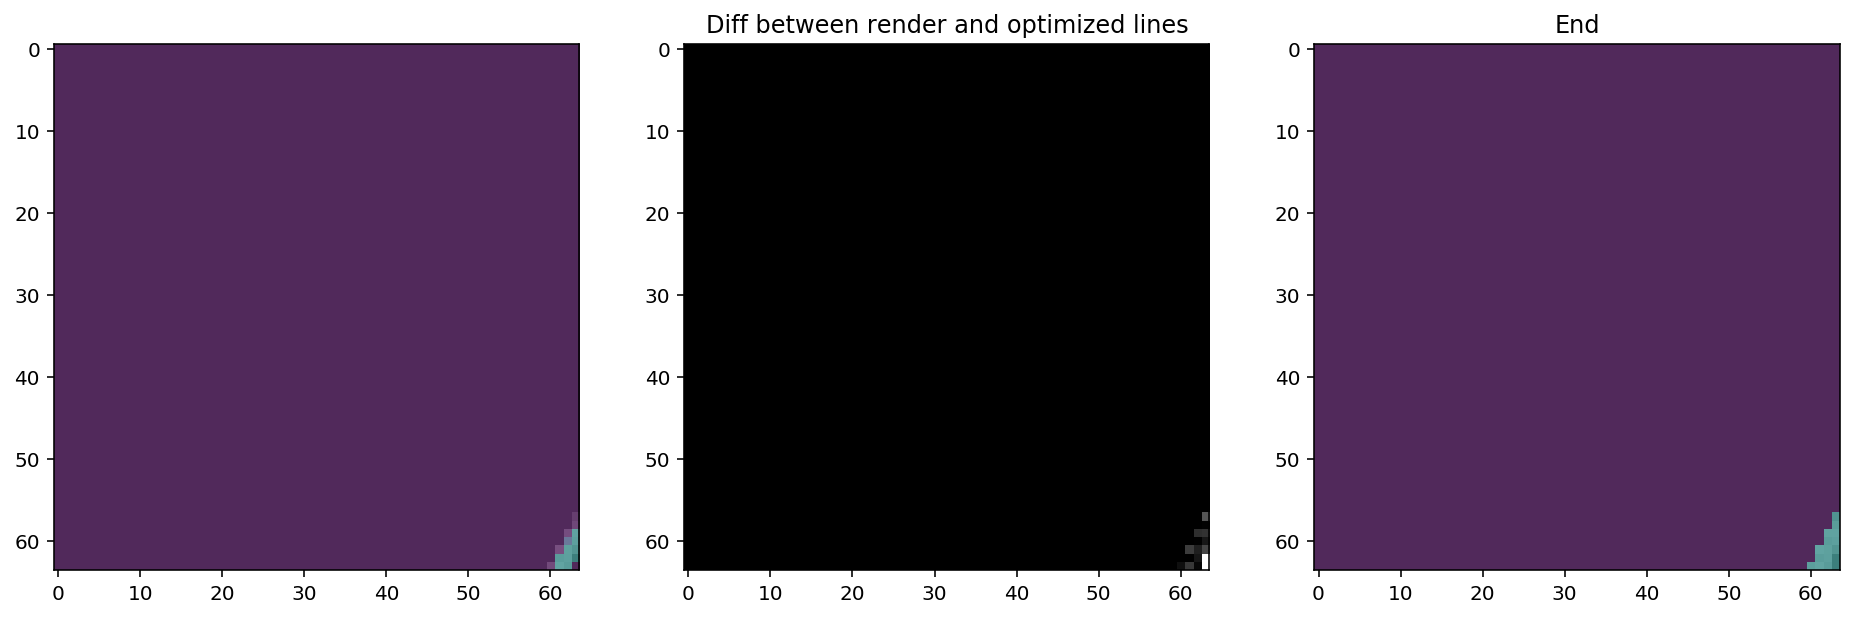

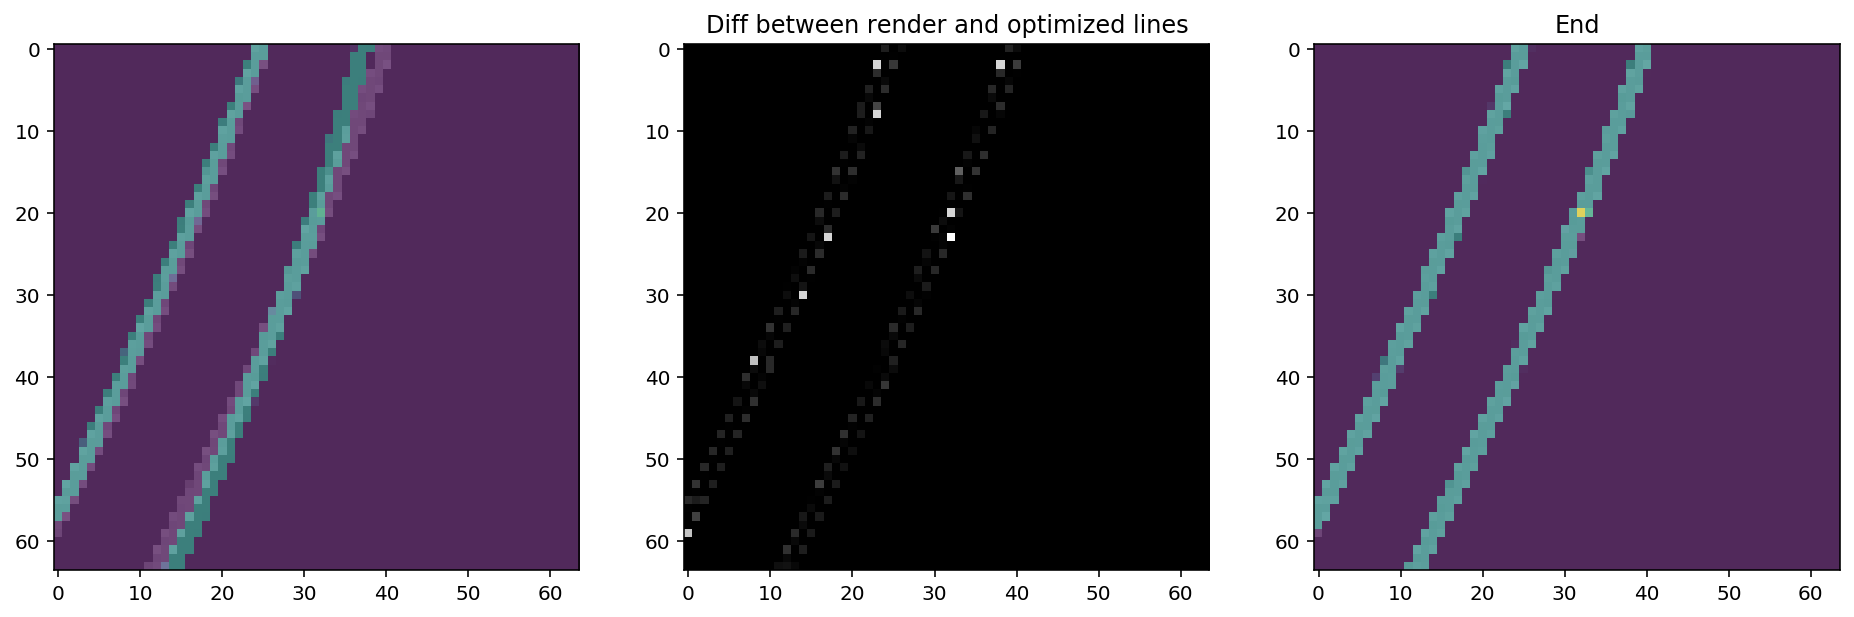

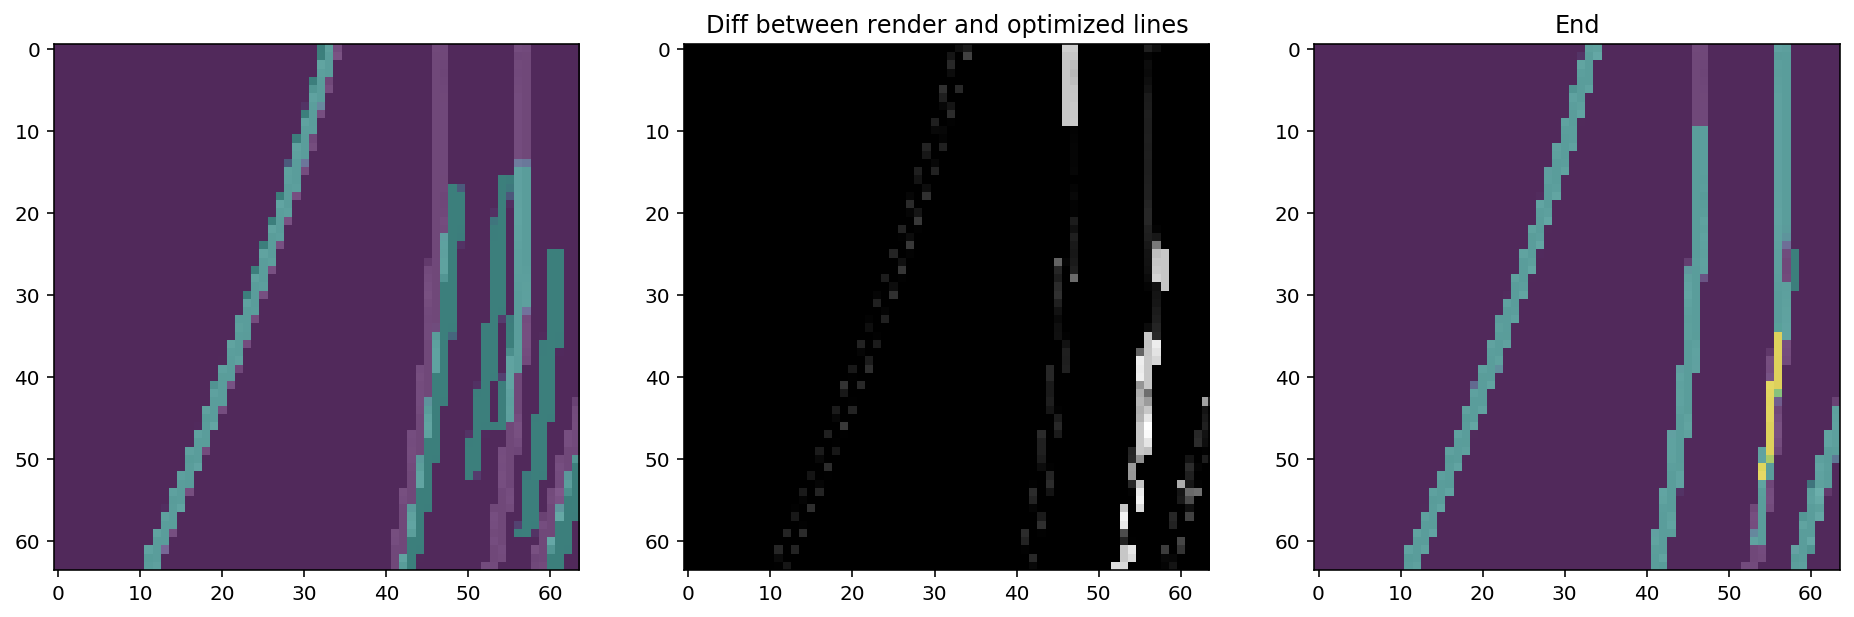

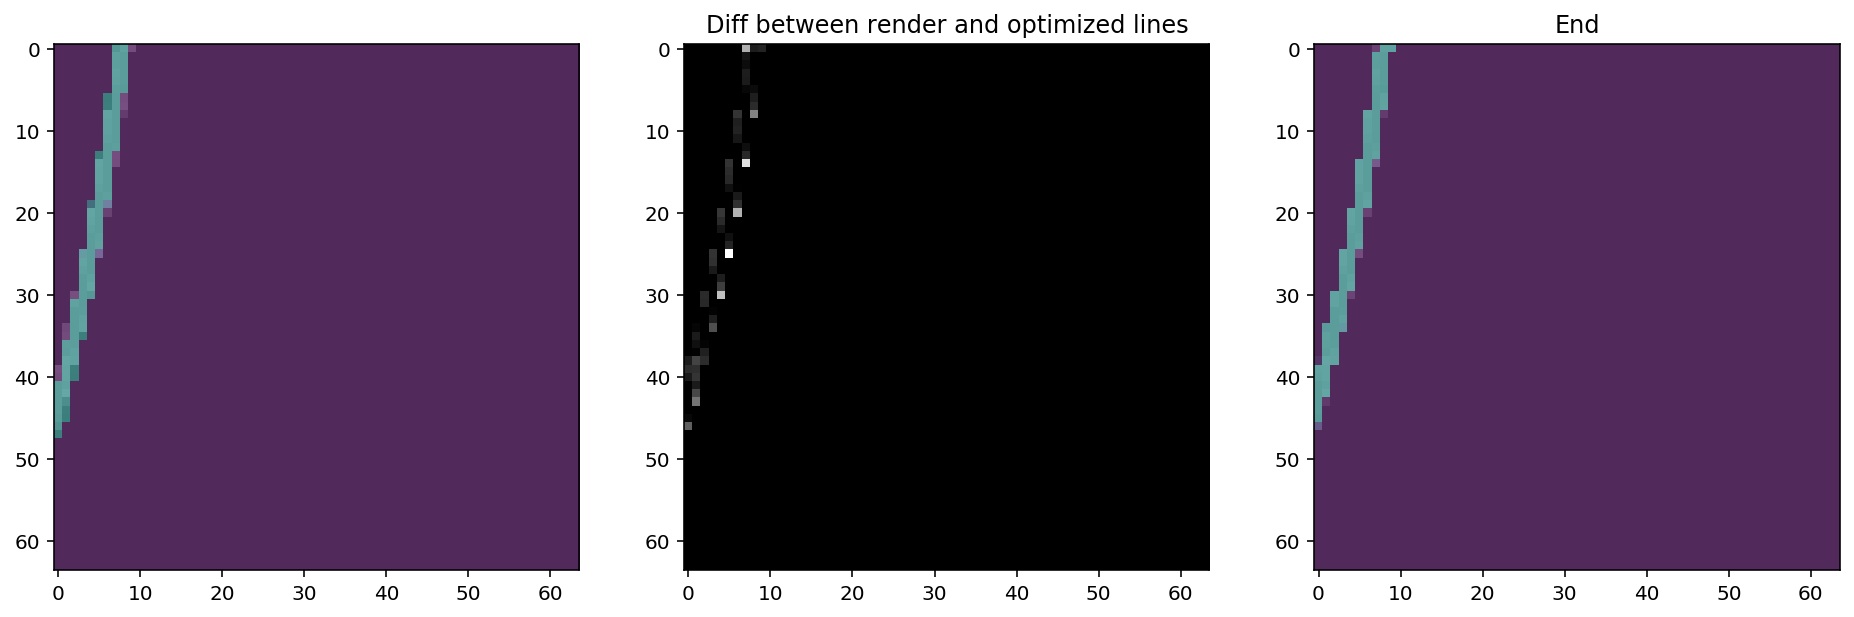

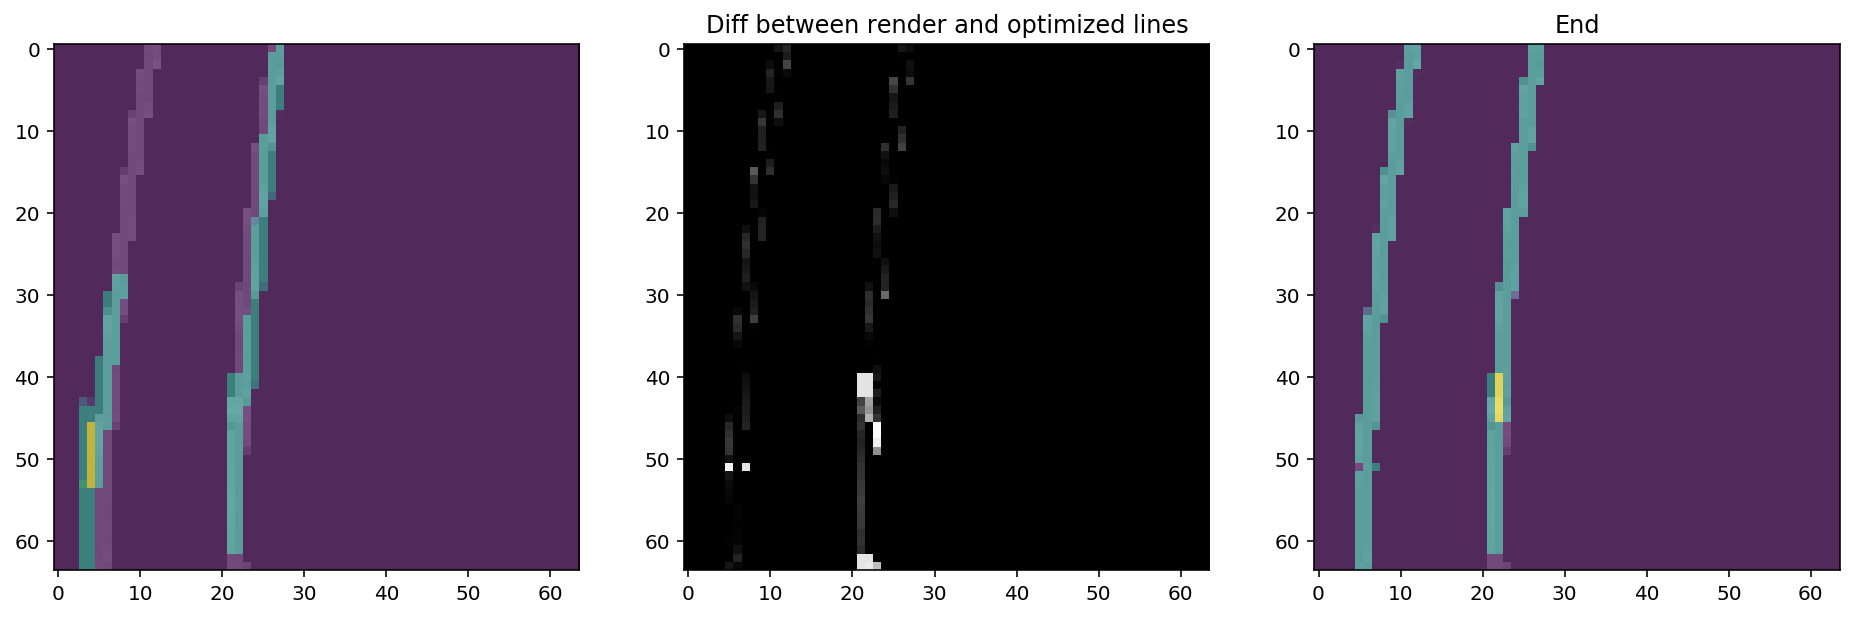

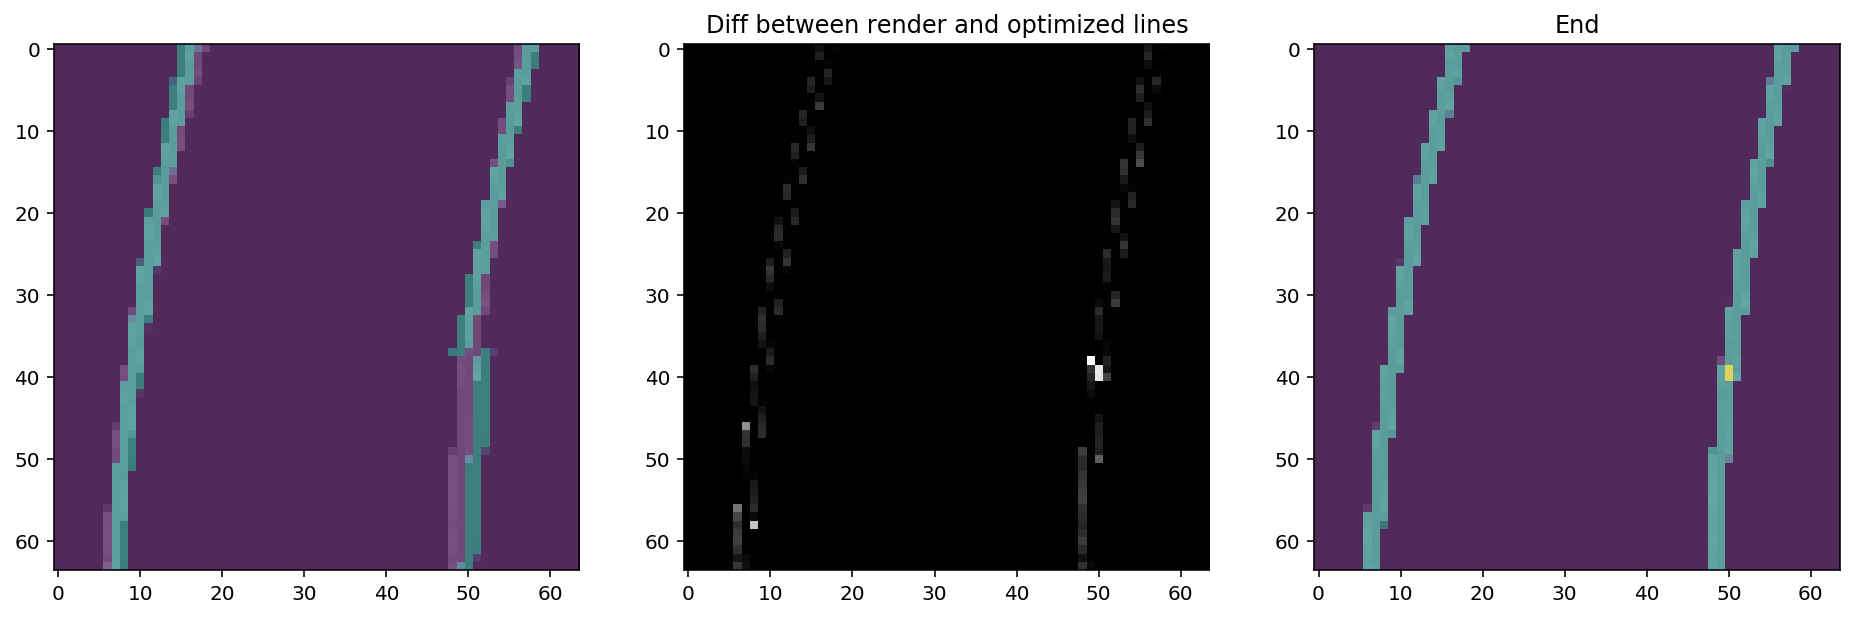

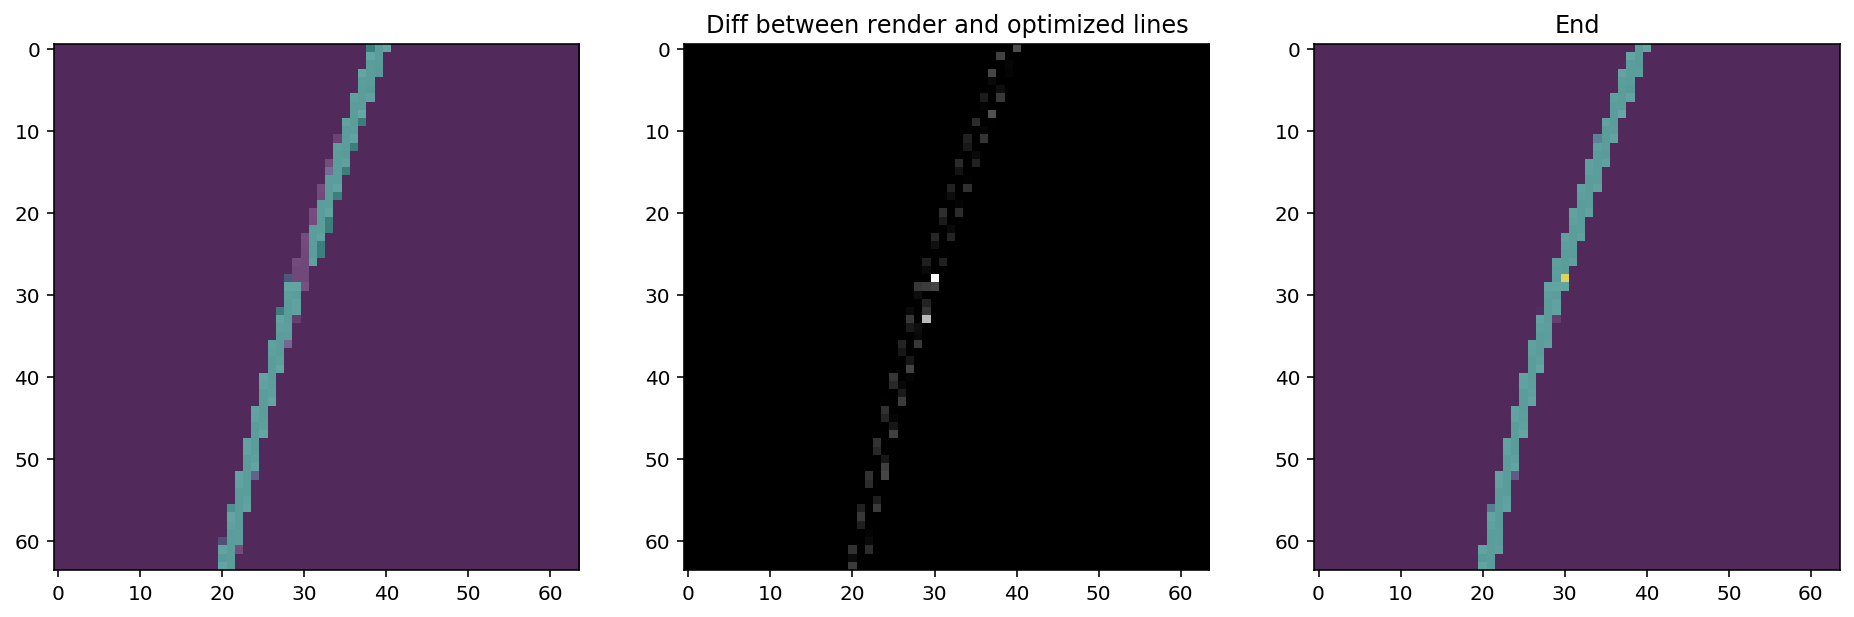

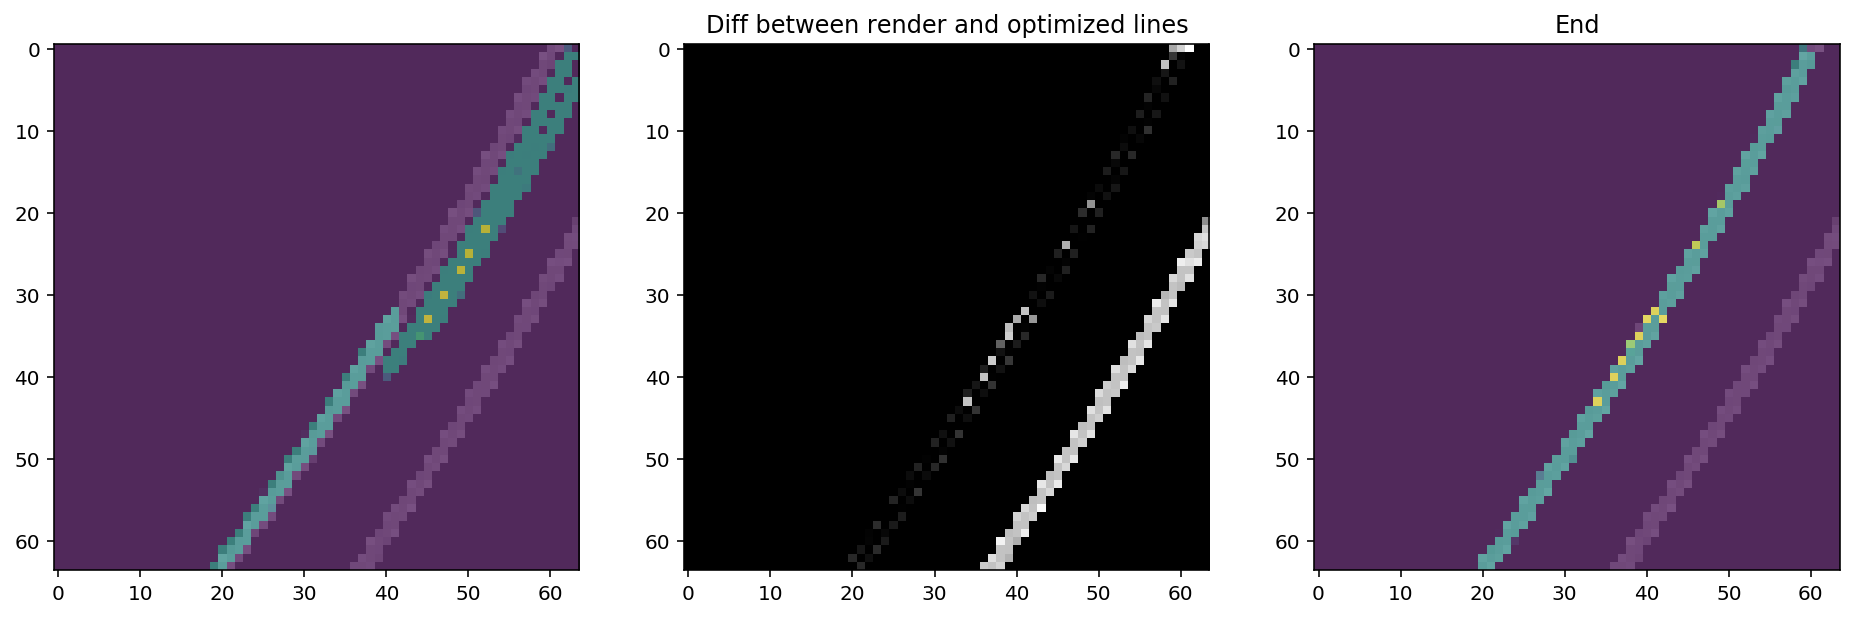

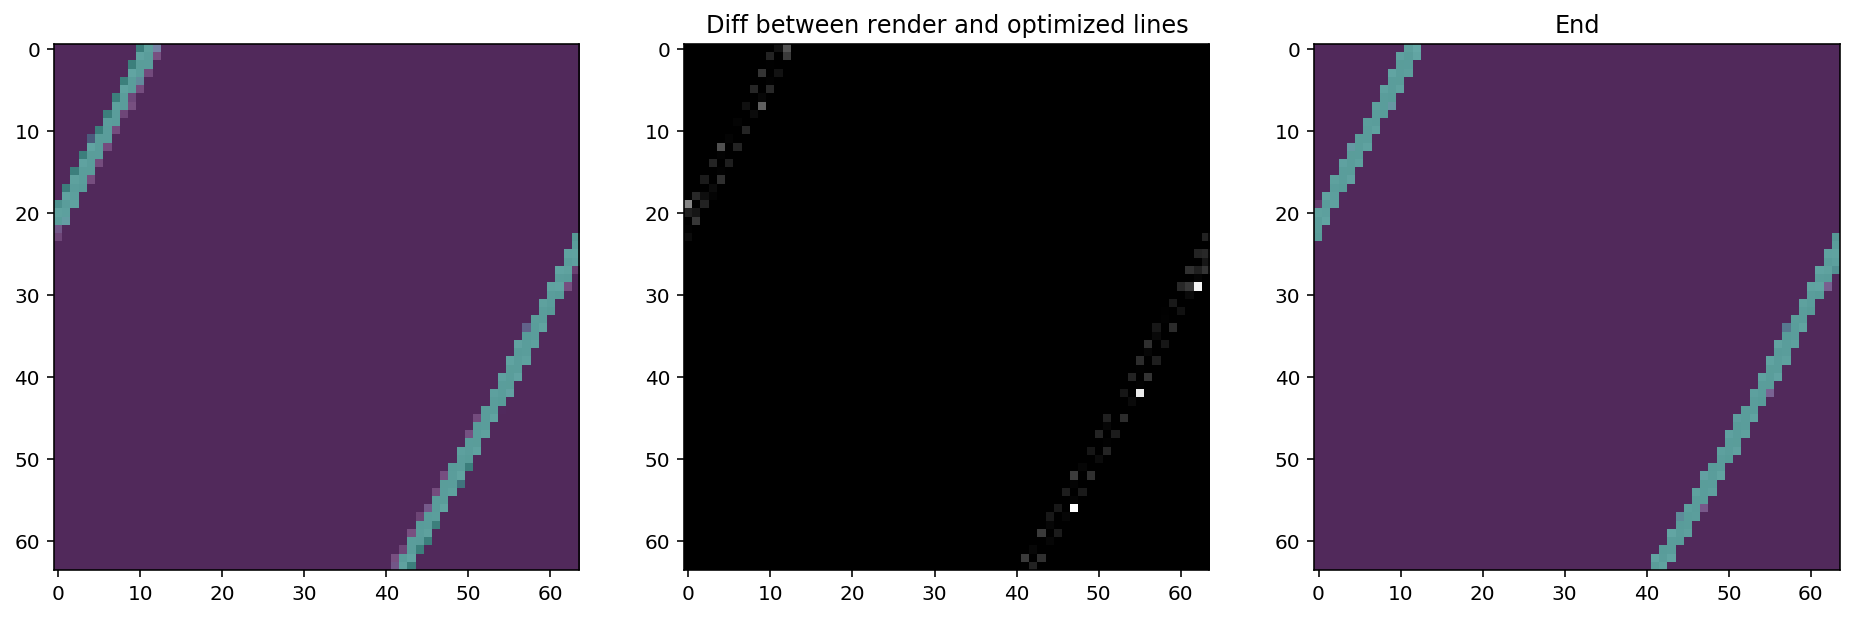

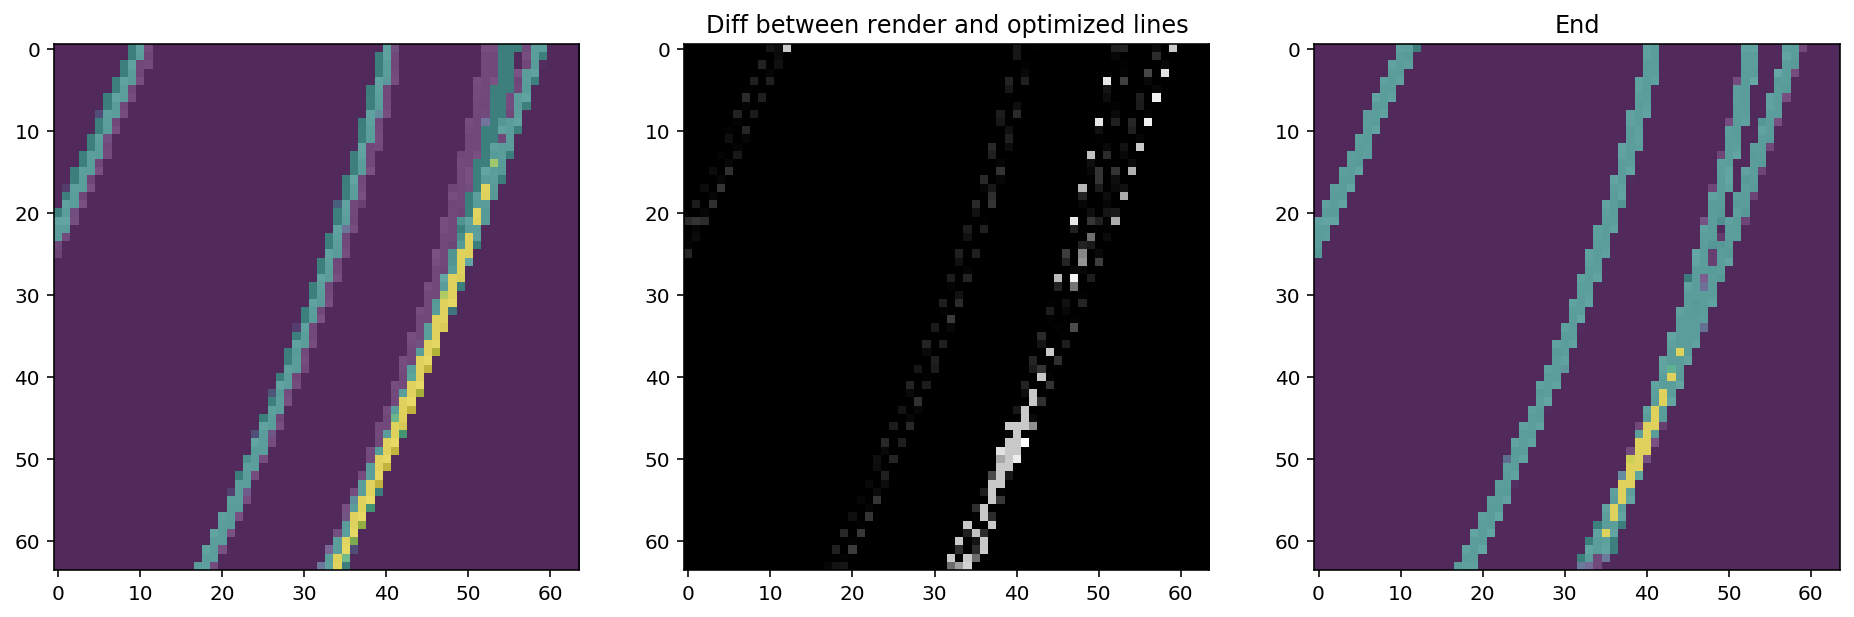

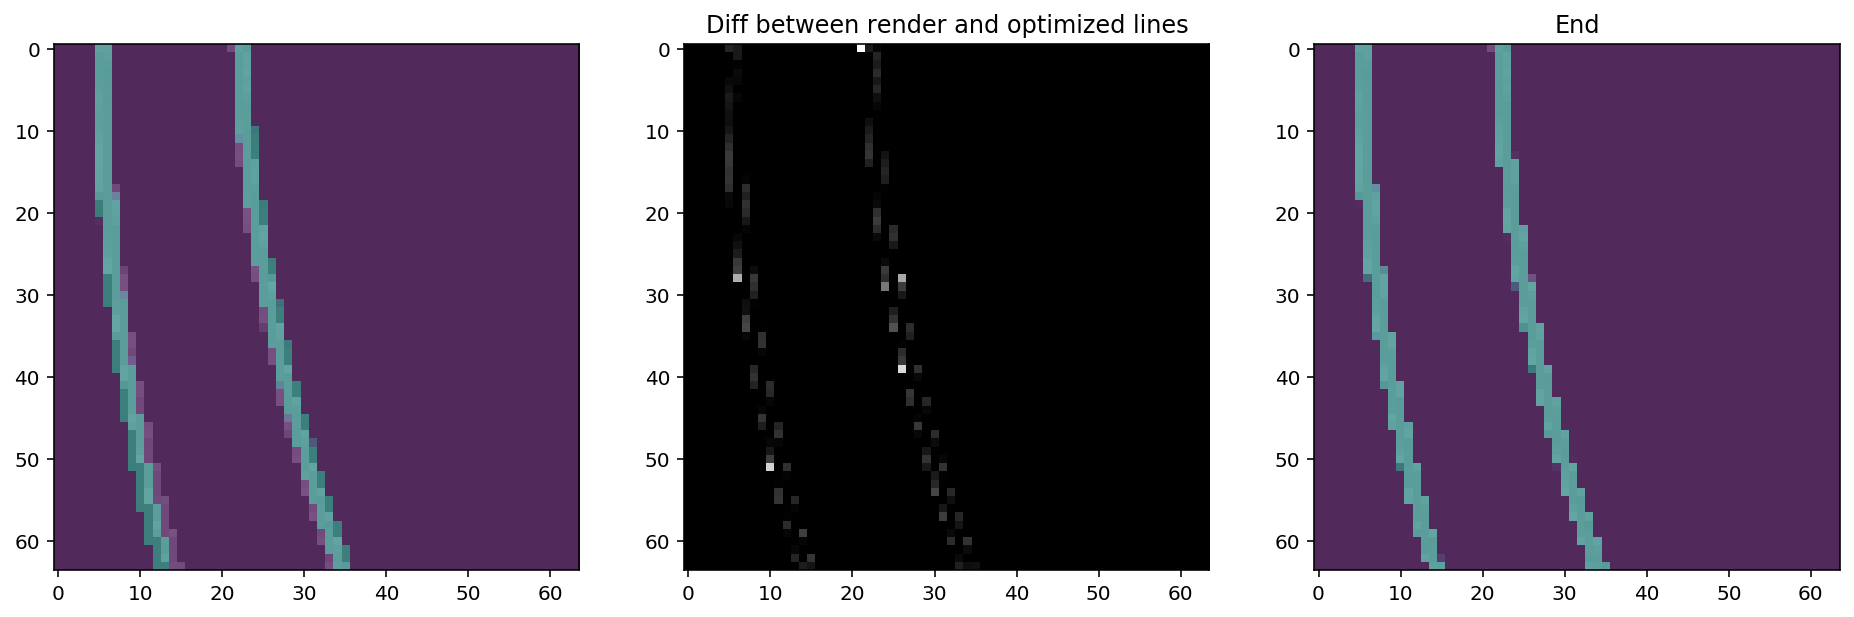

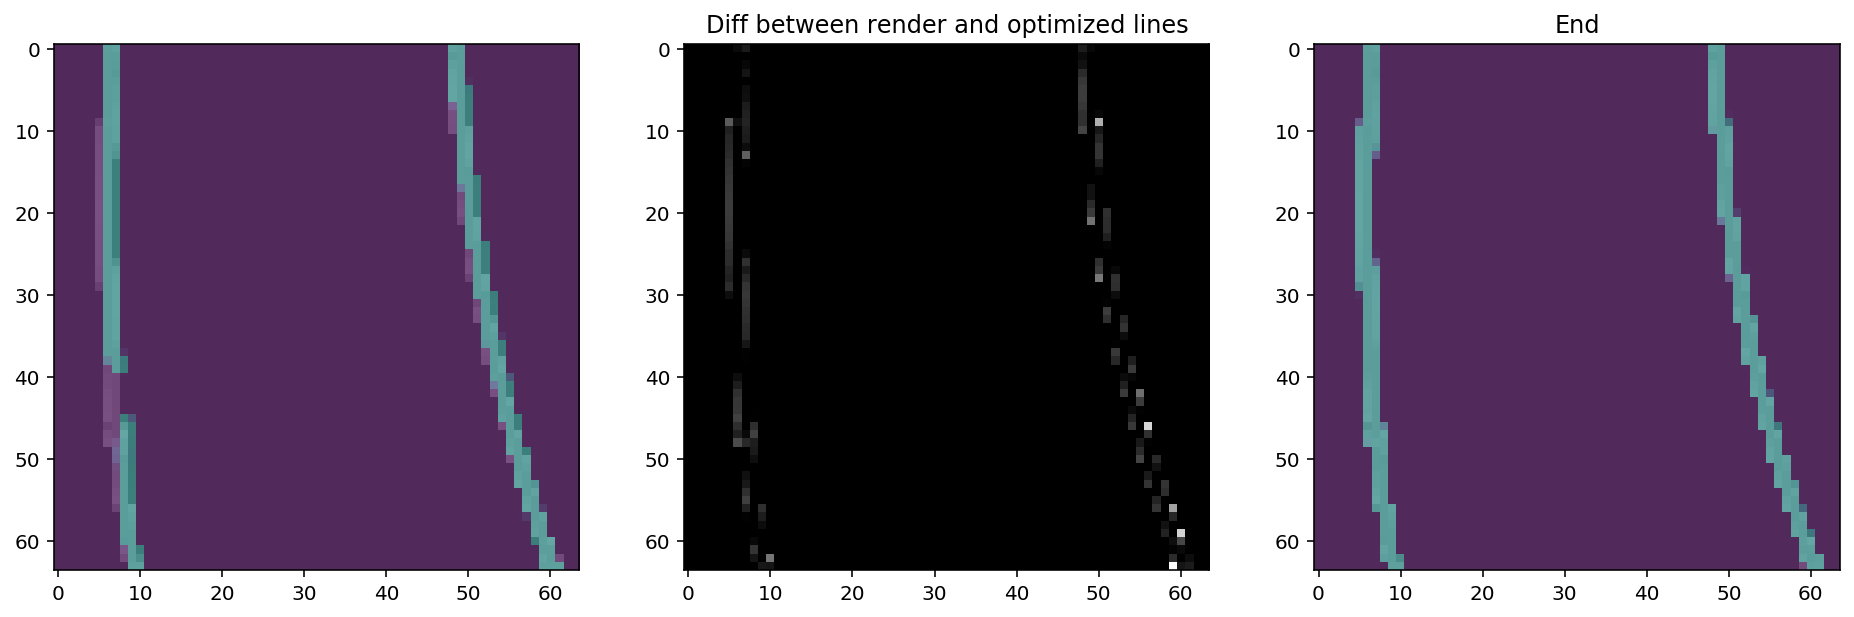

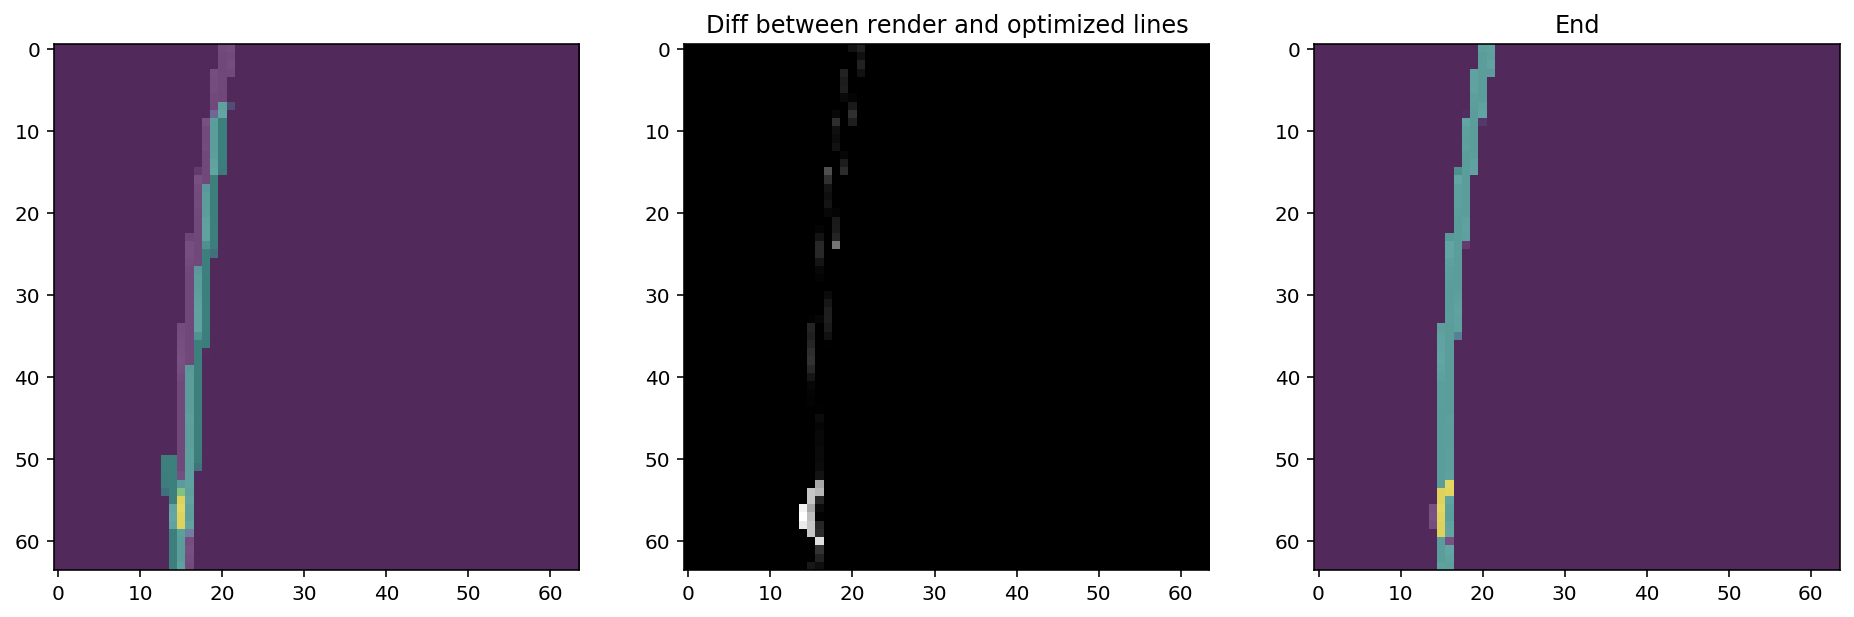

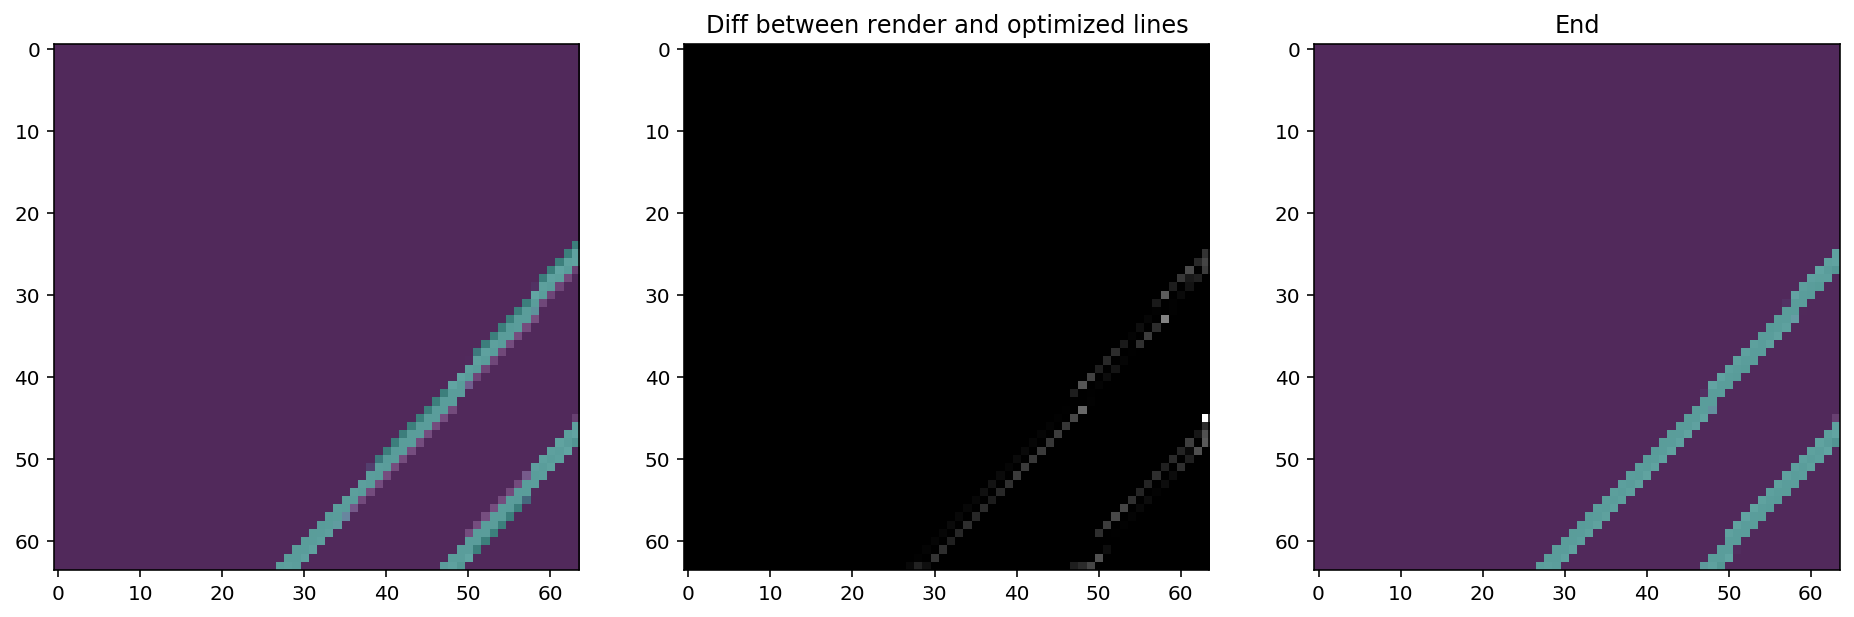

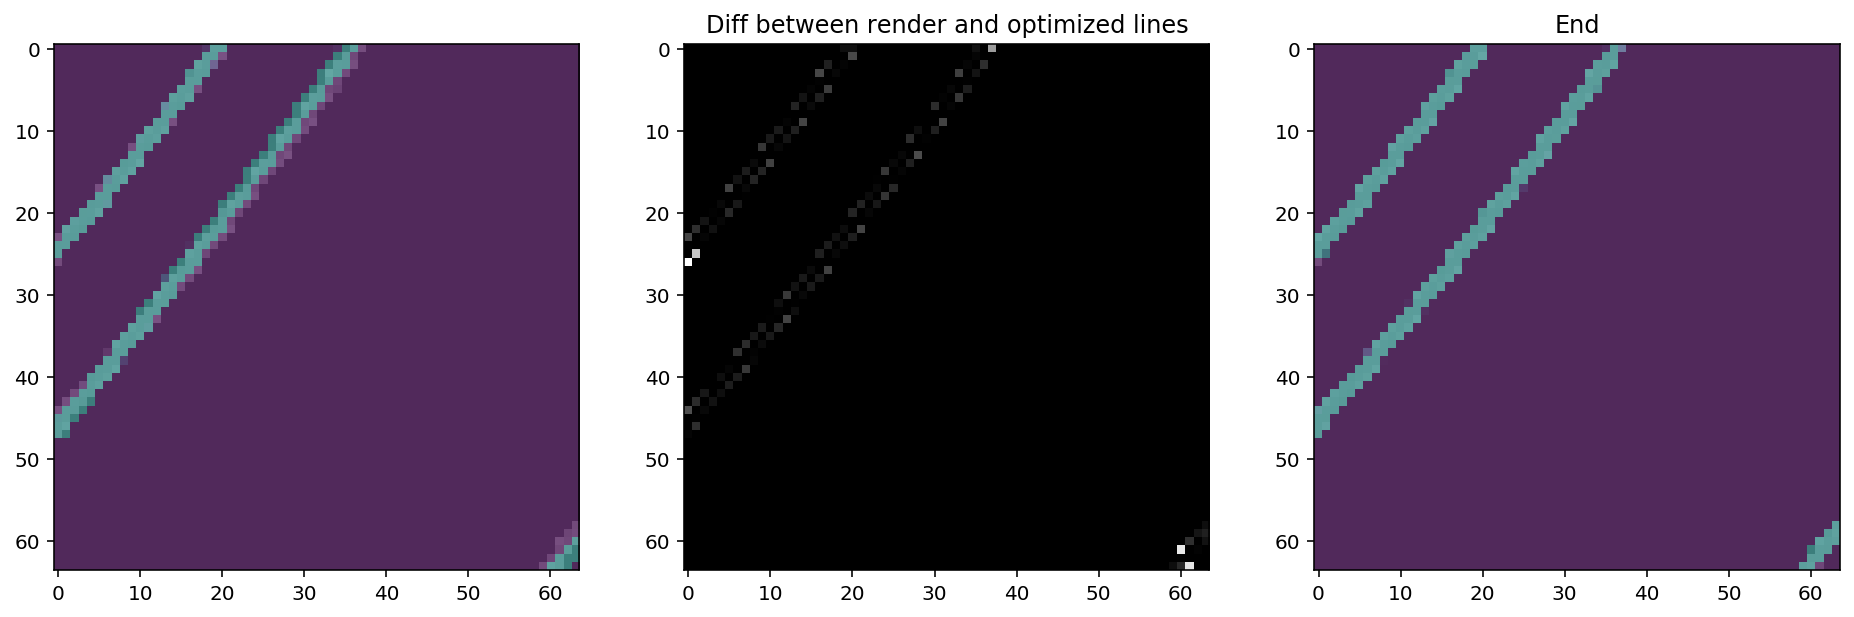

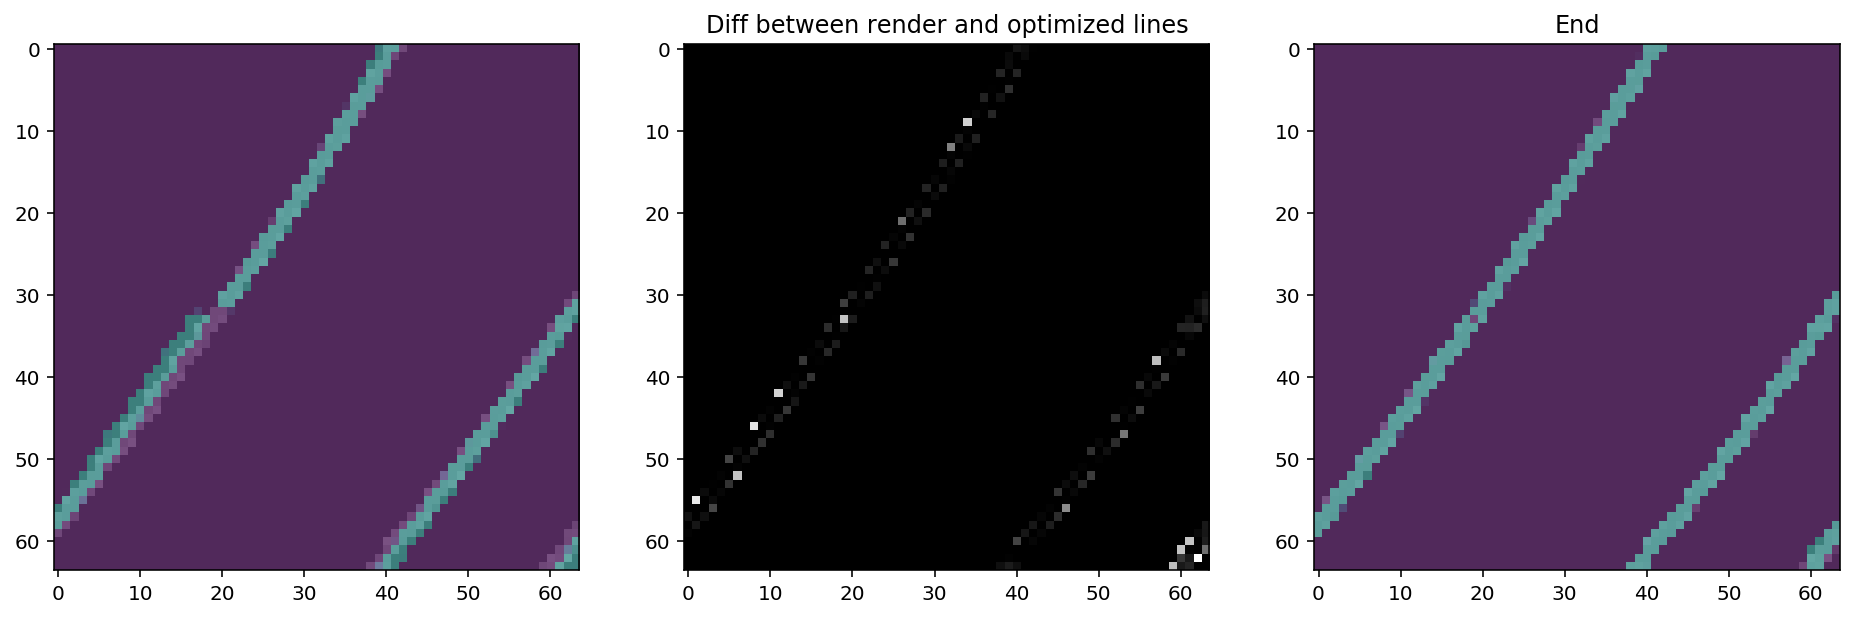

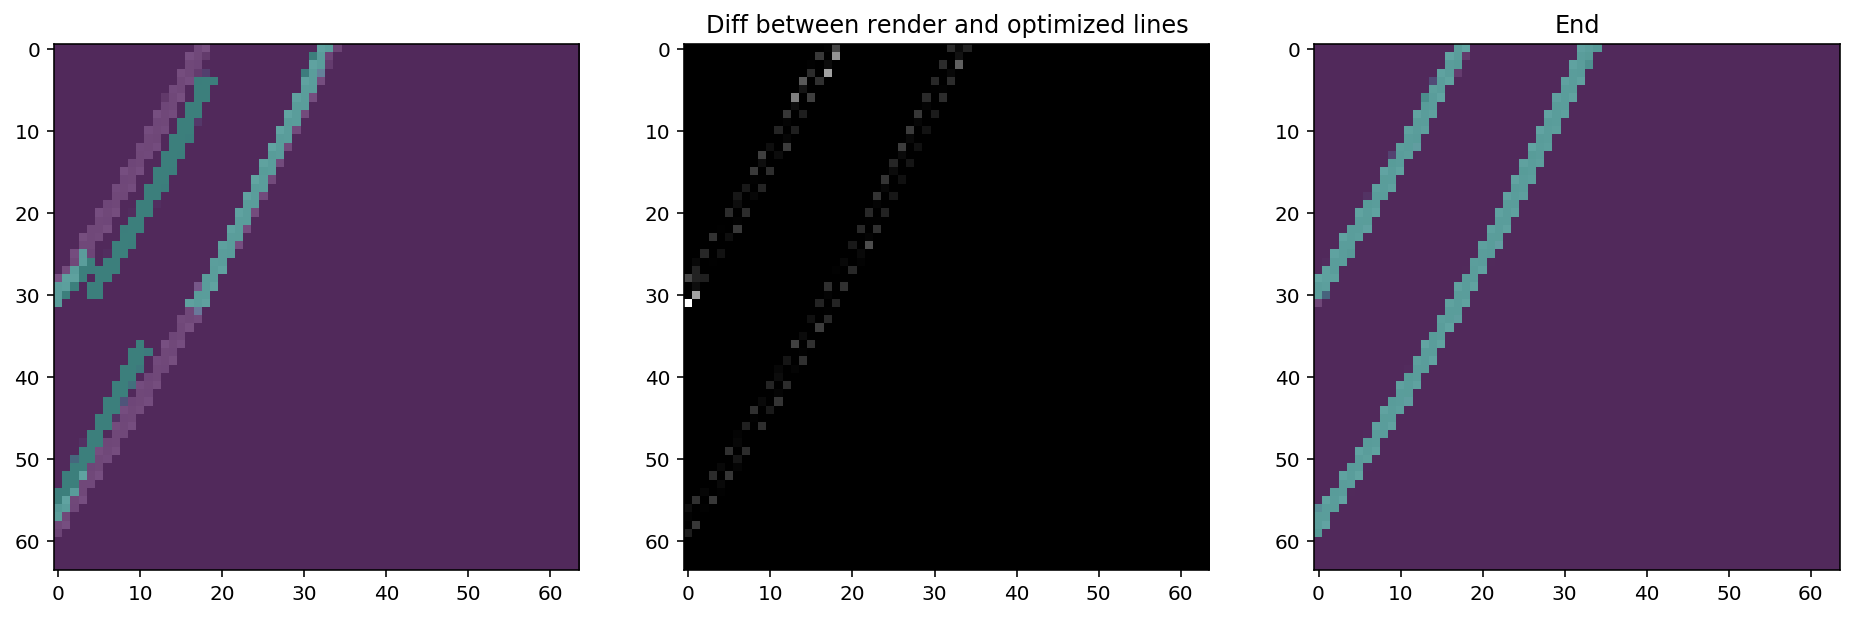

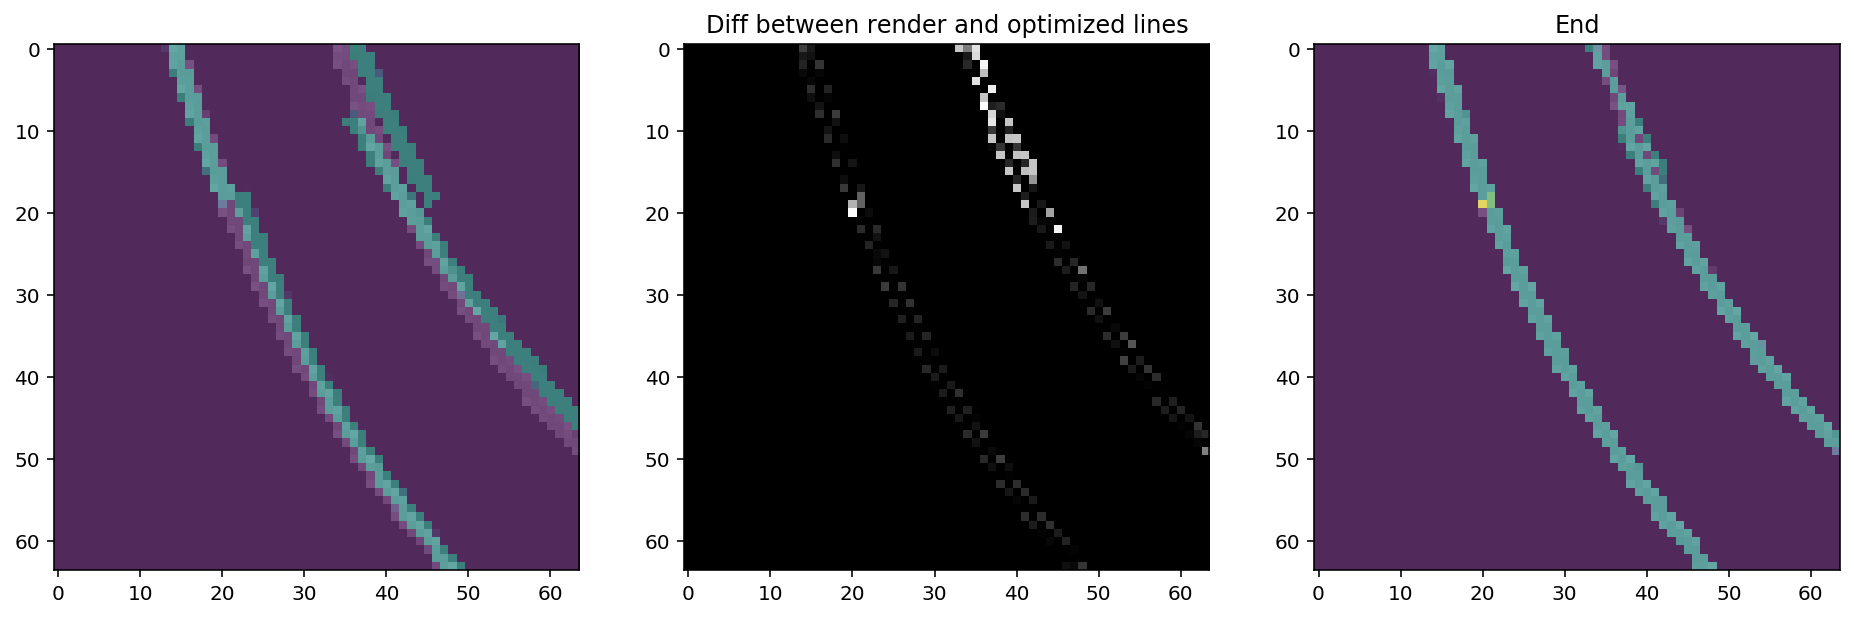

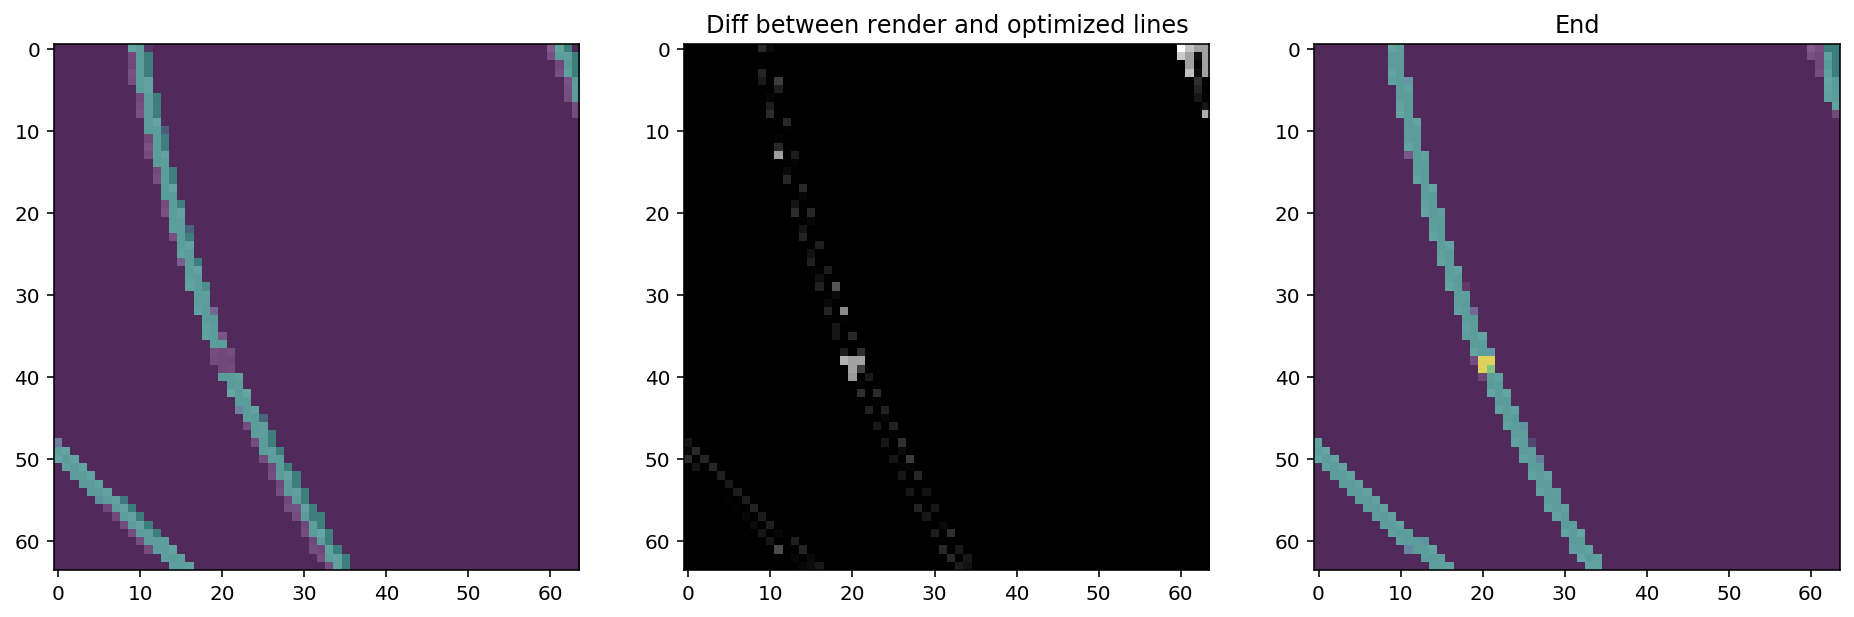

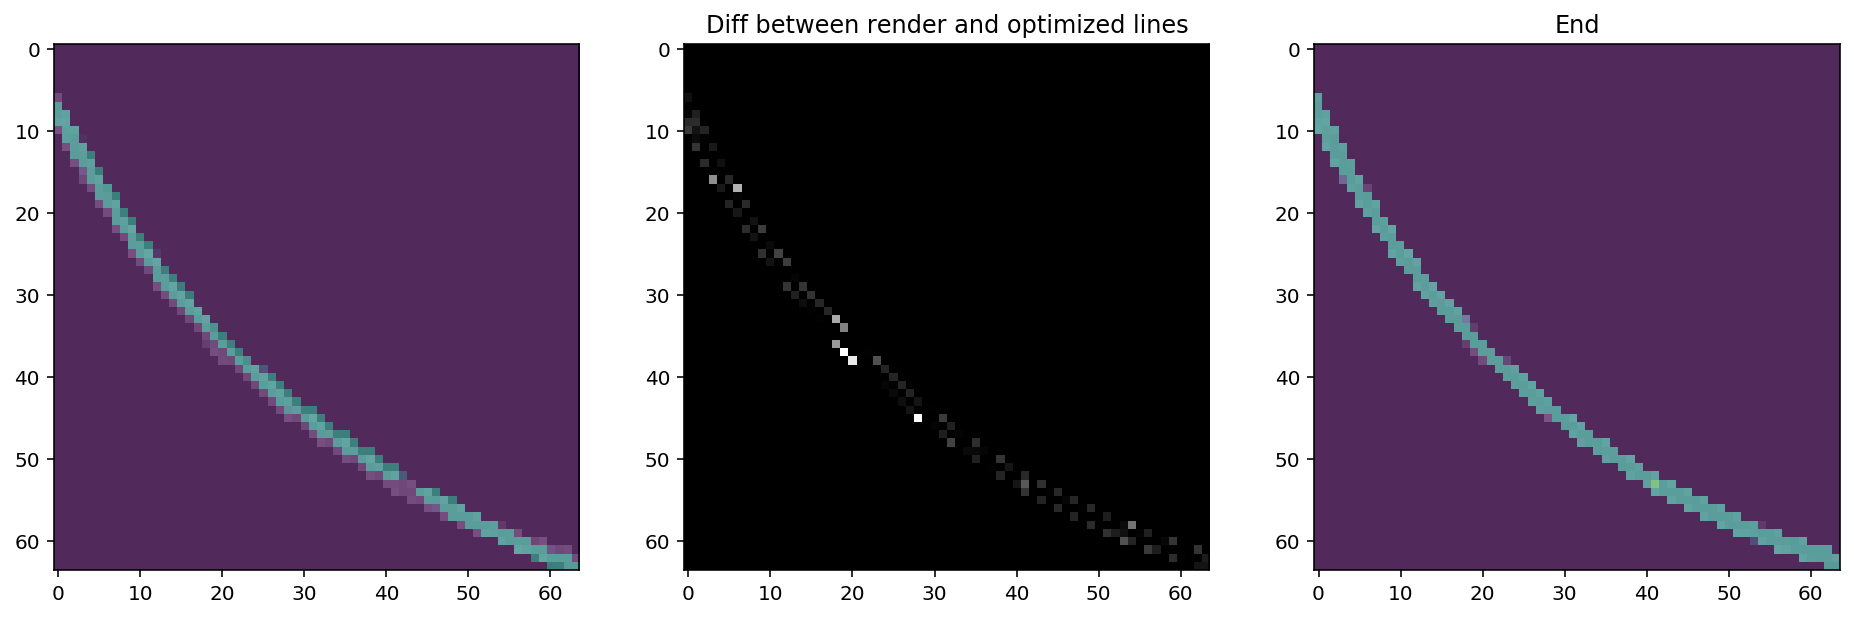

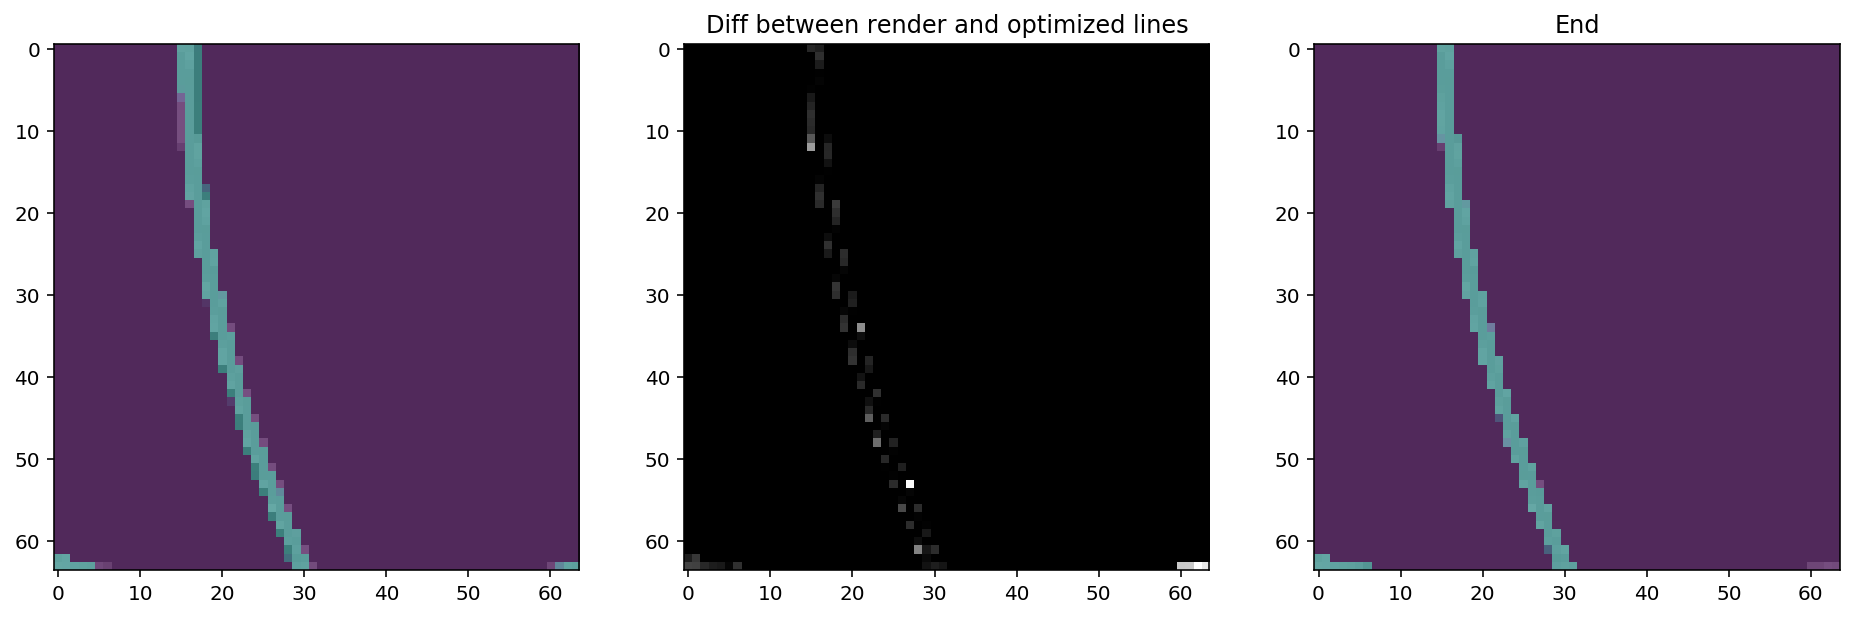

100%|██████████| 500/500 [00:51<00:00,  9.64it/s]


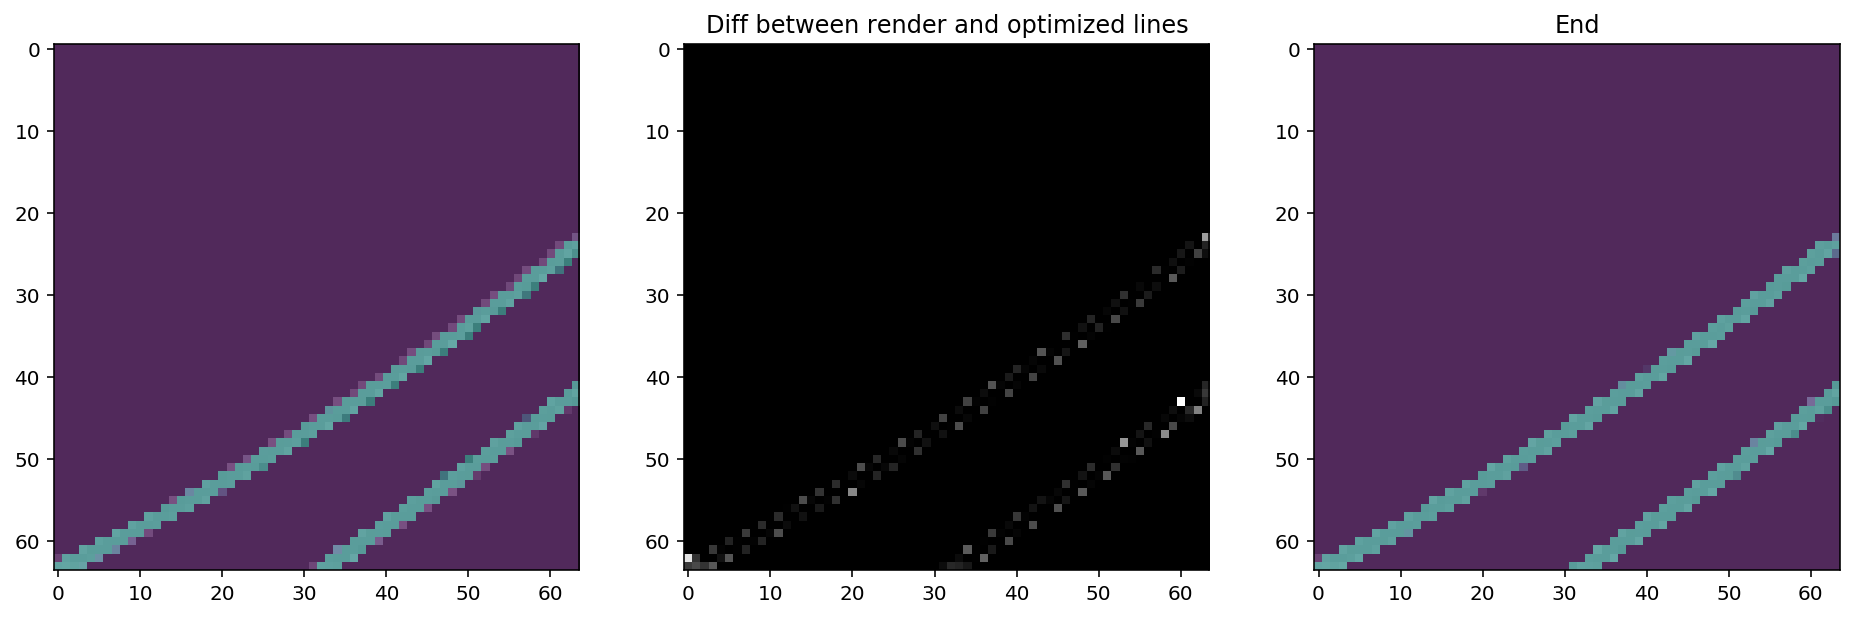

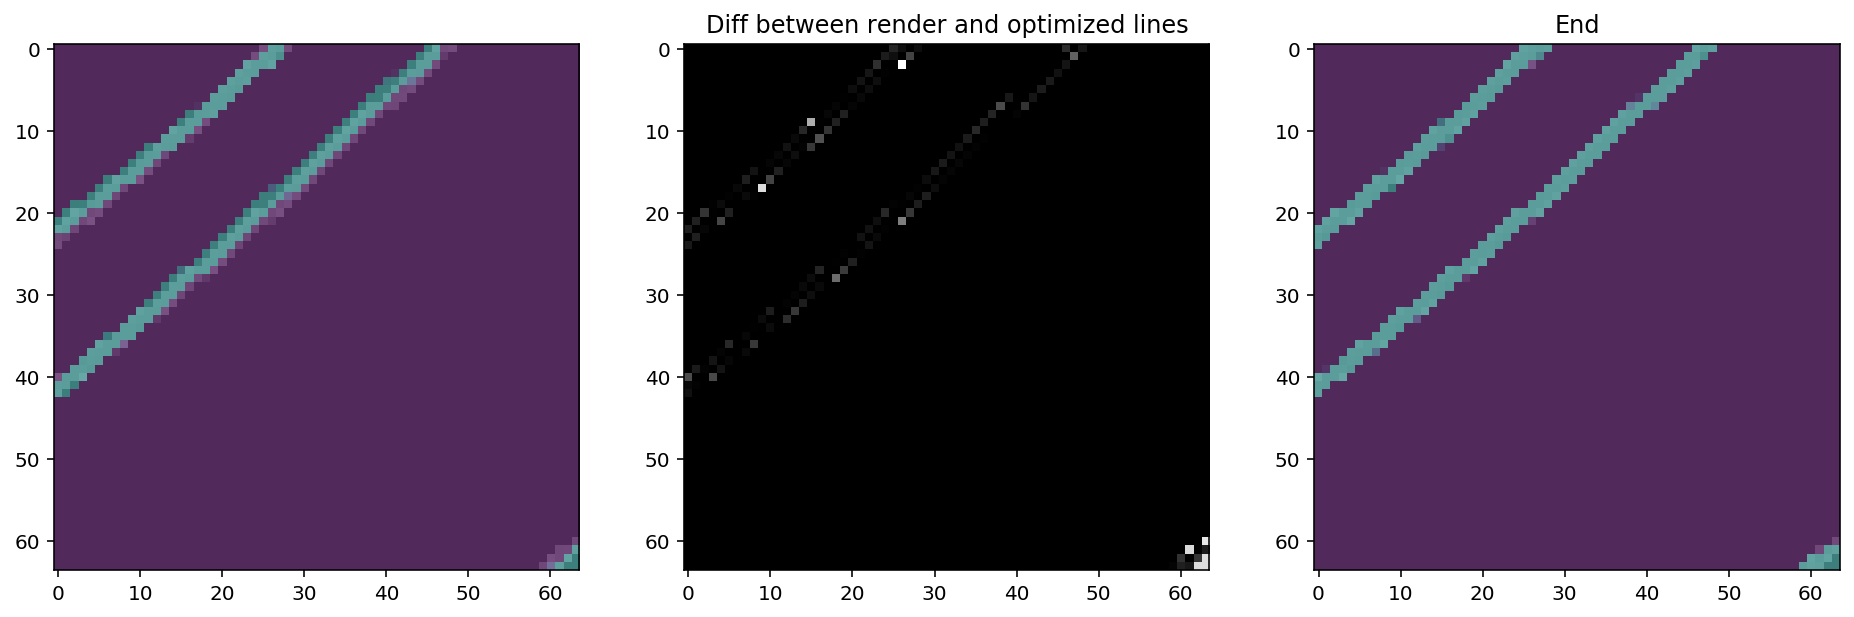

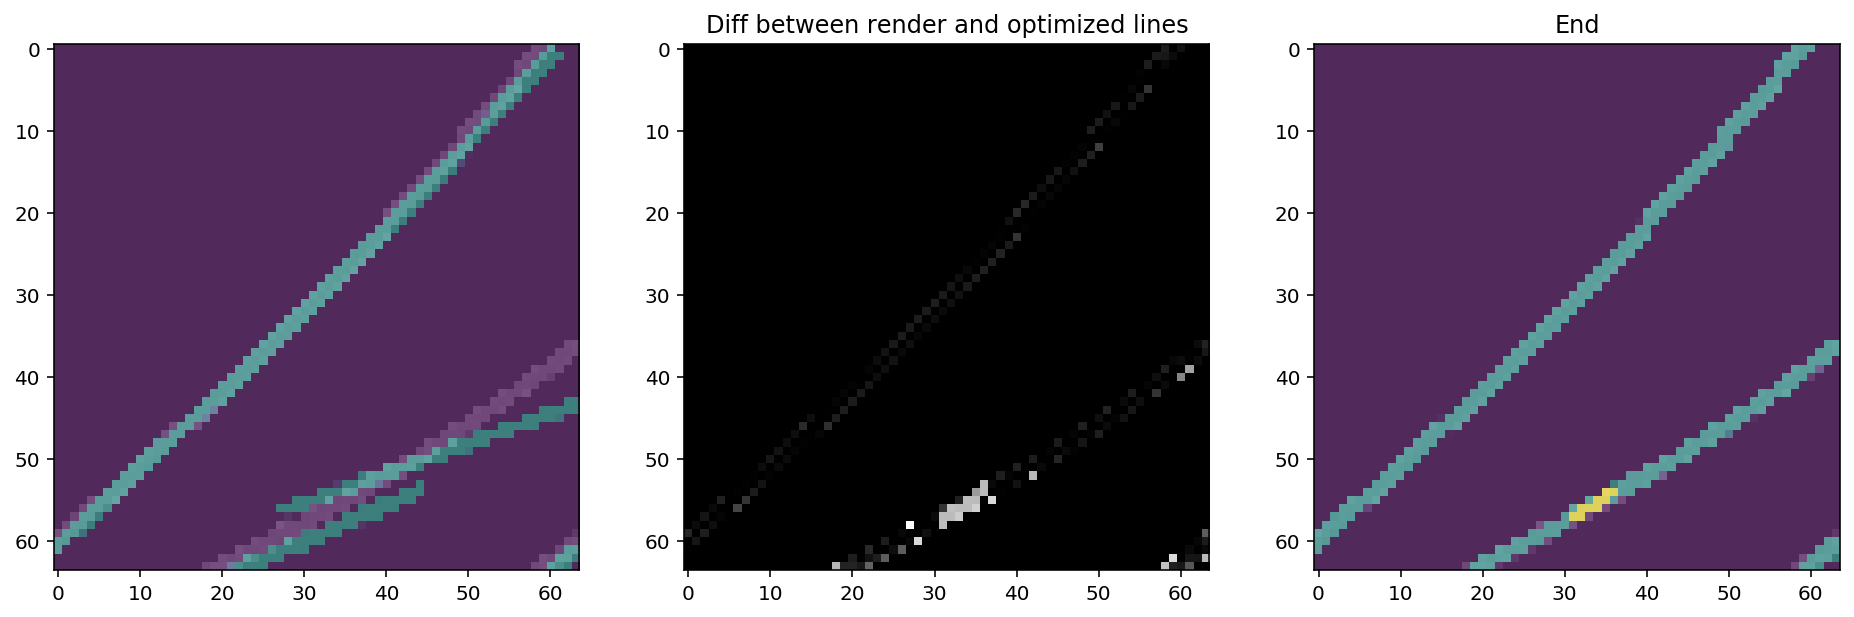

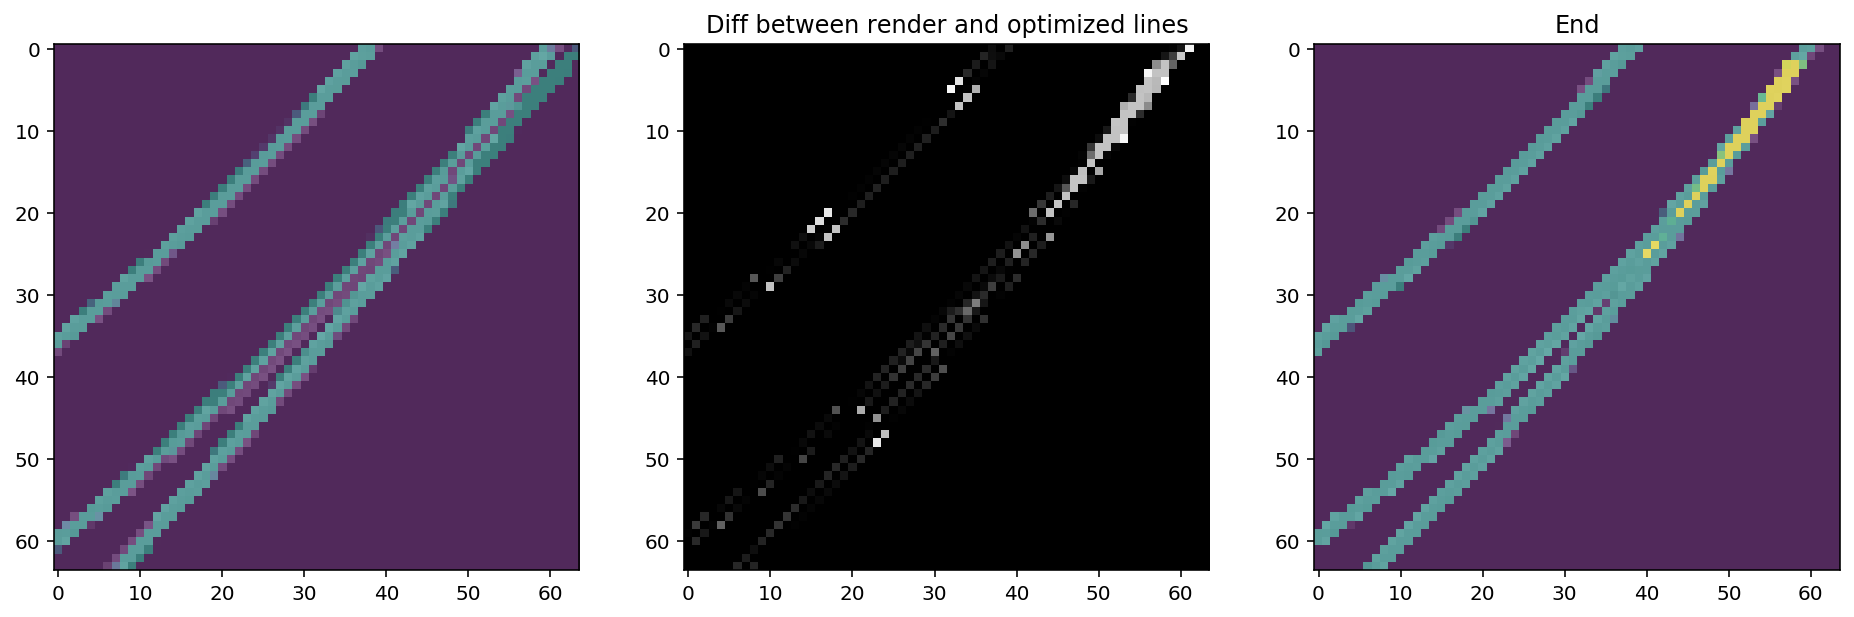

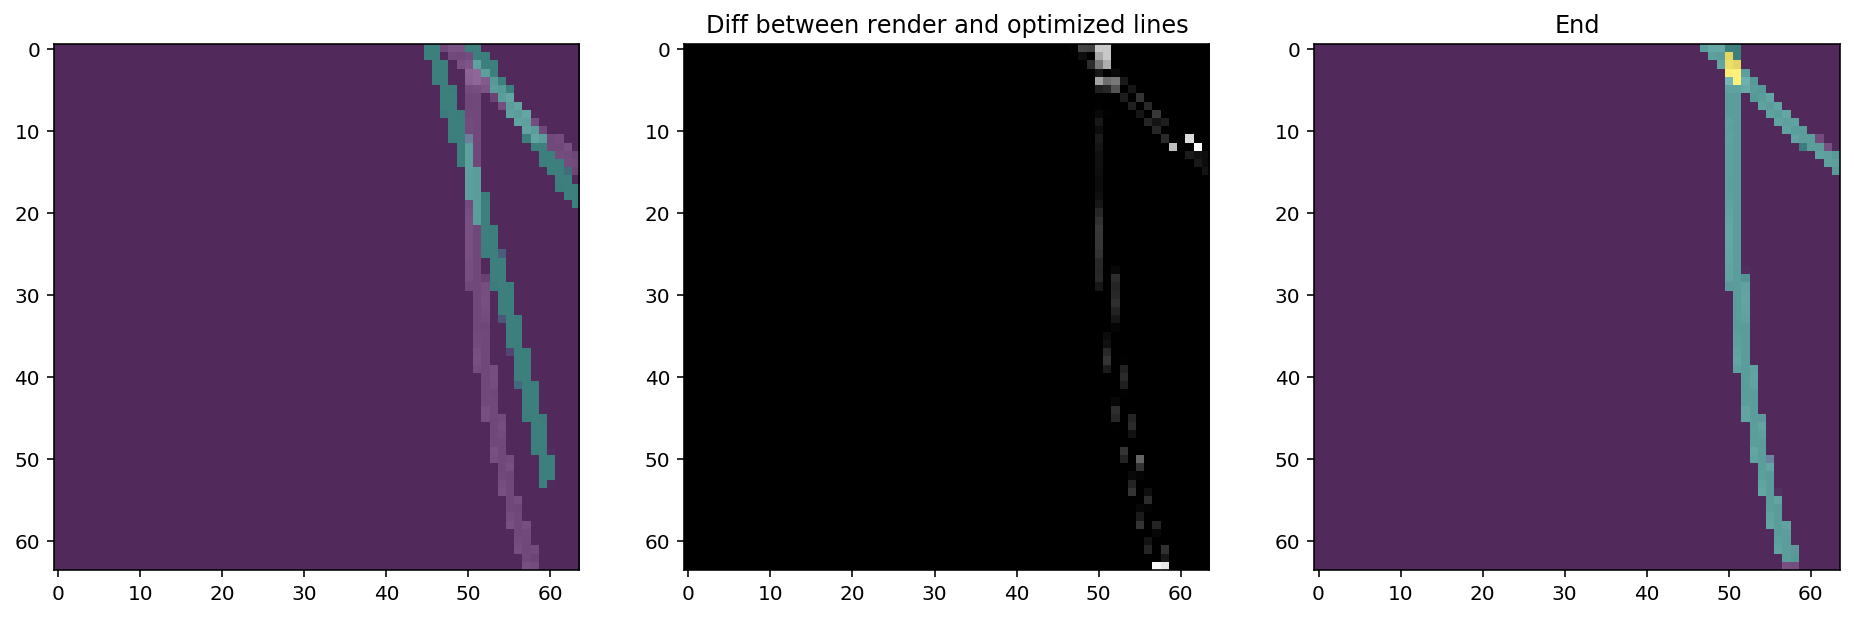

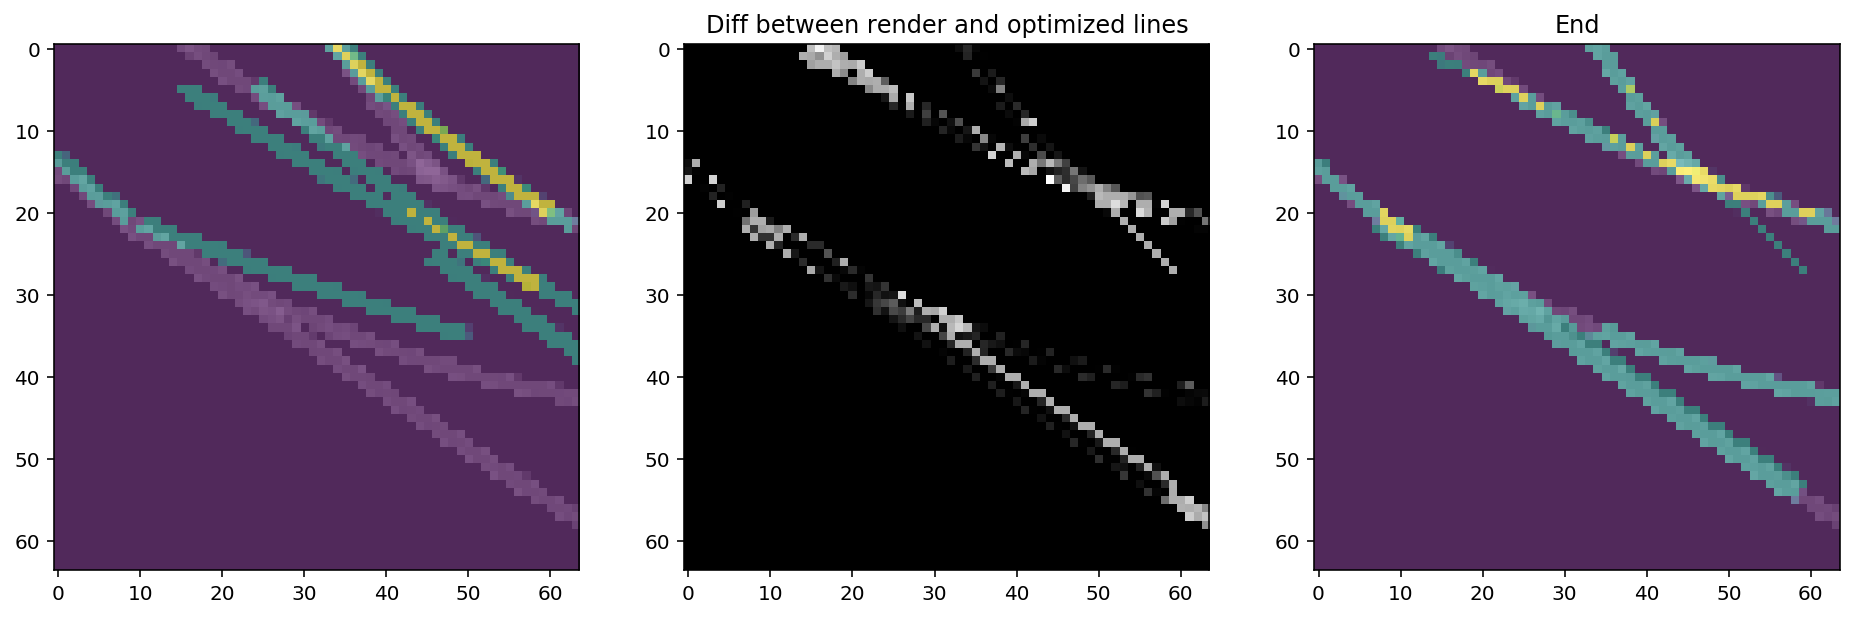

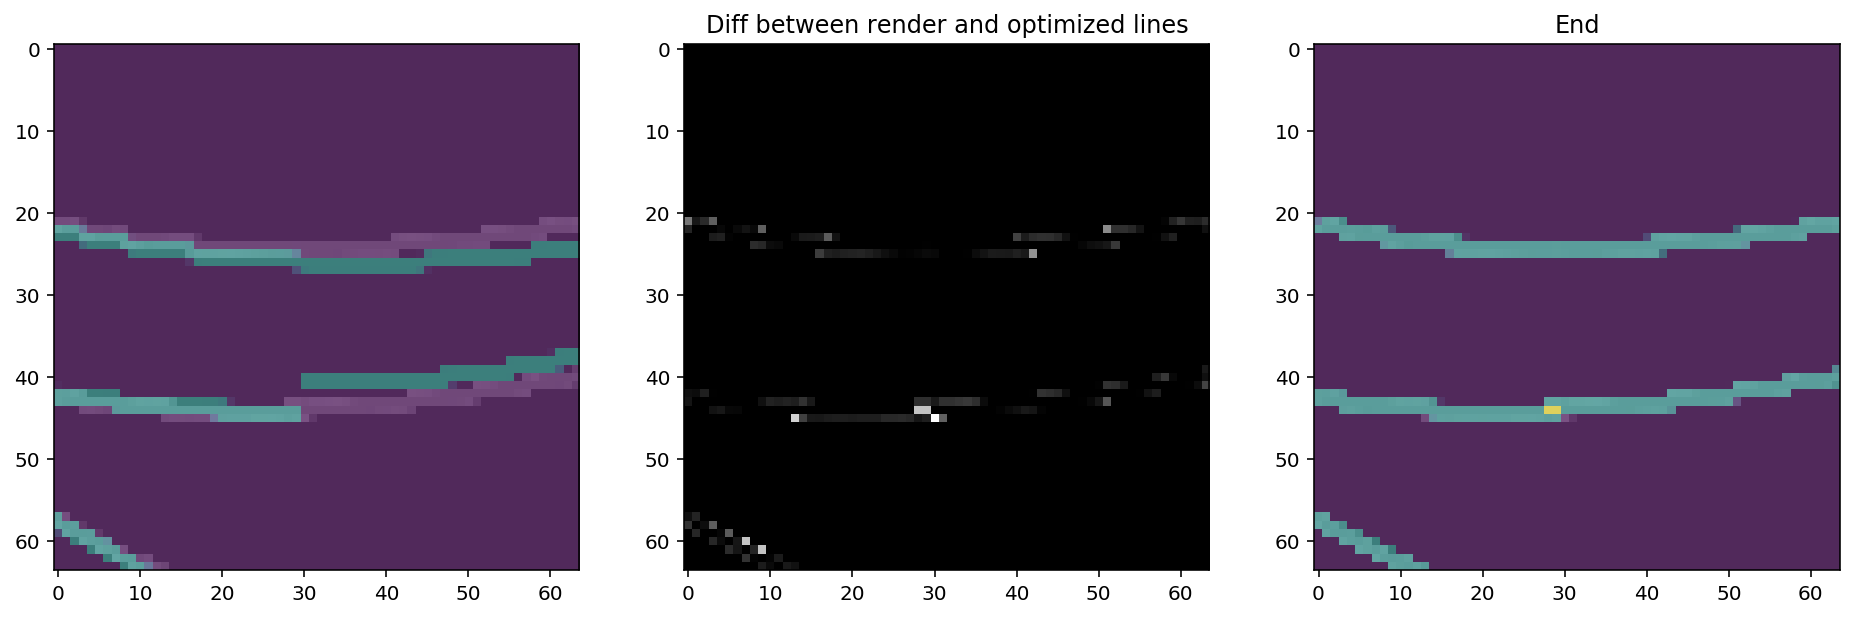

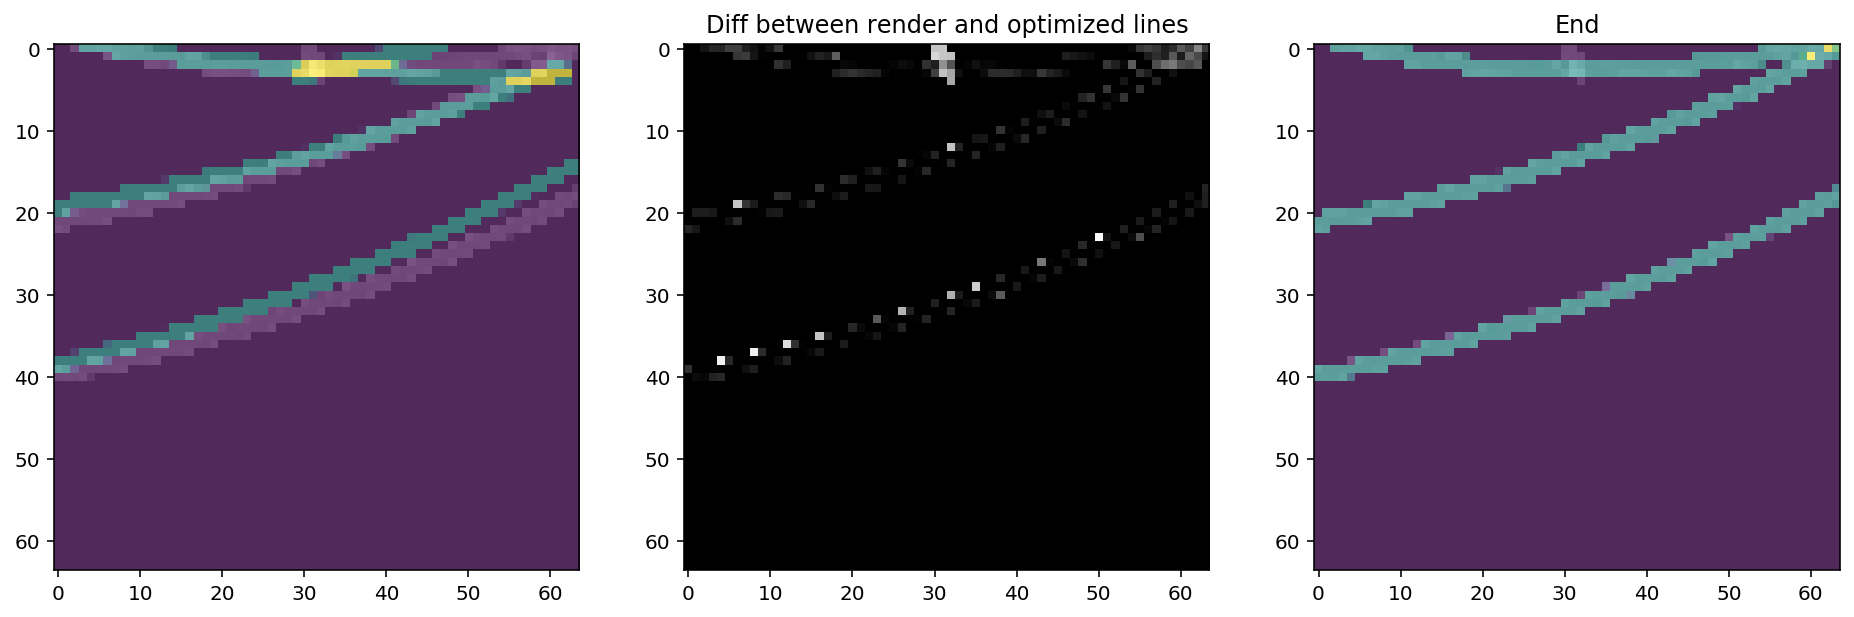

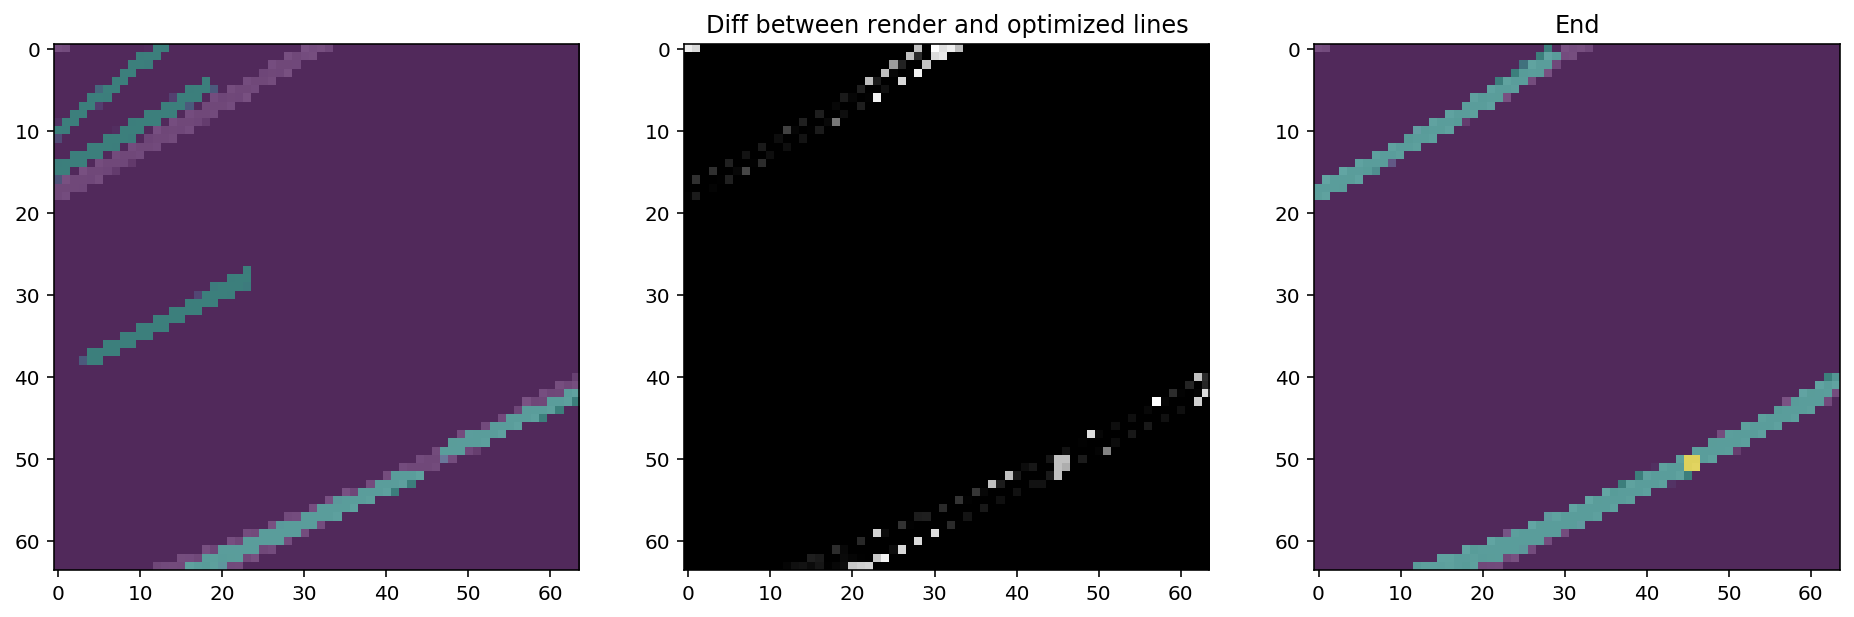

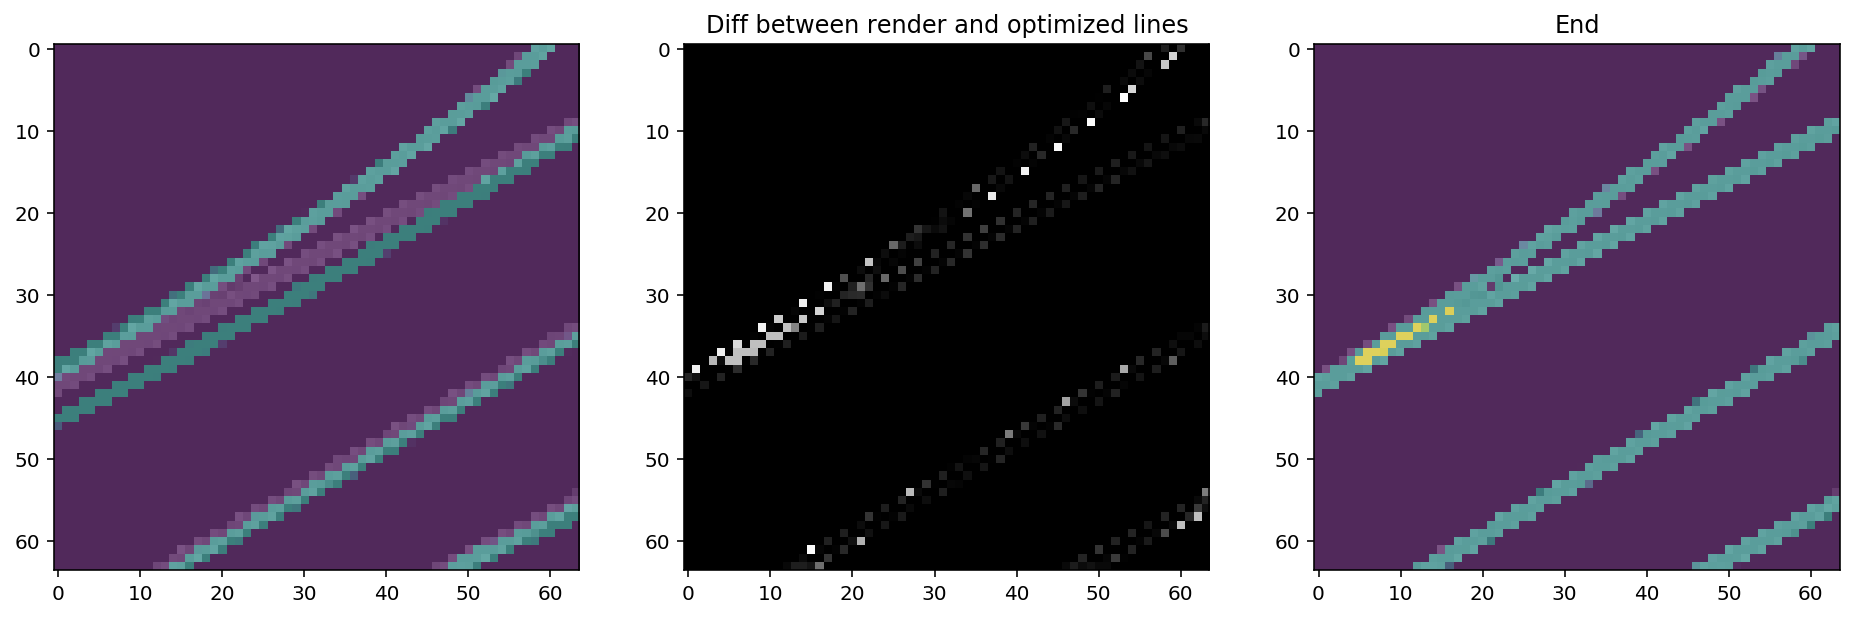

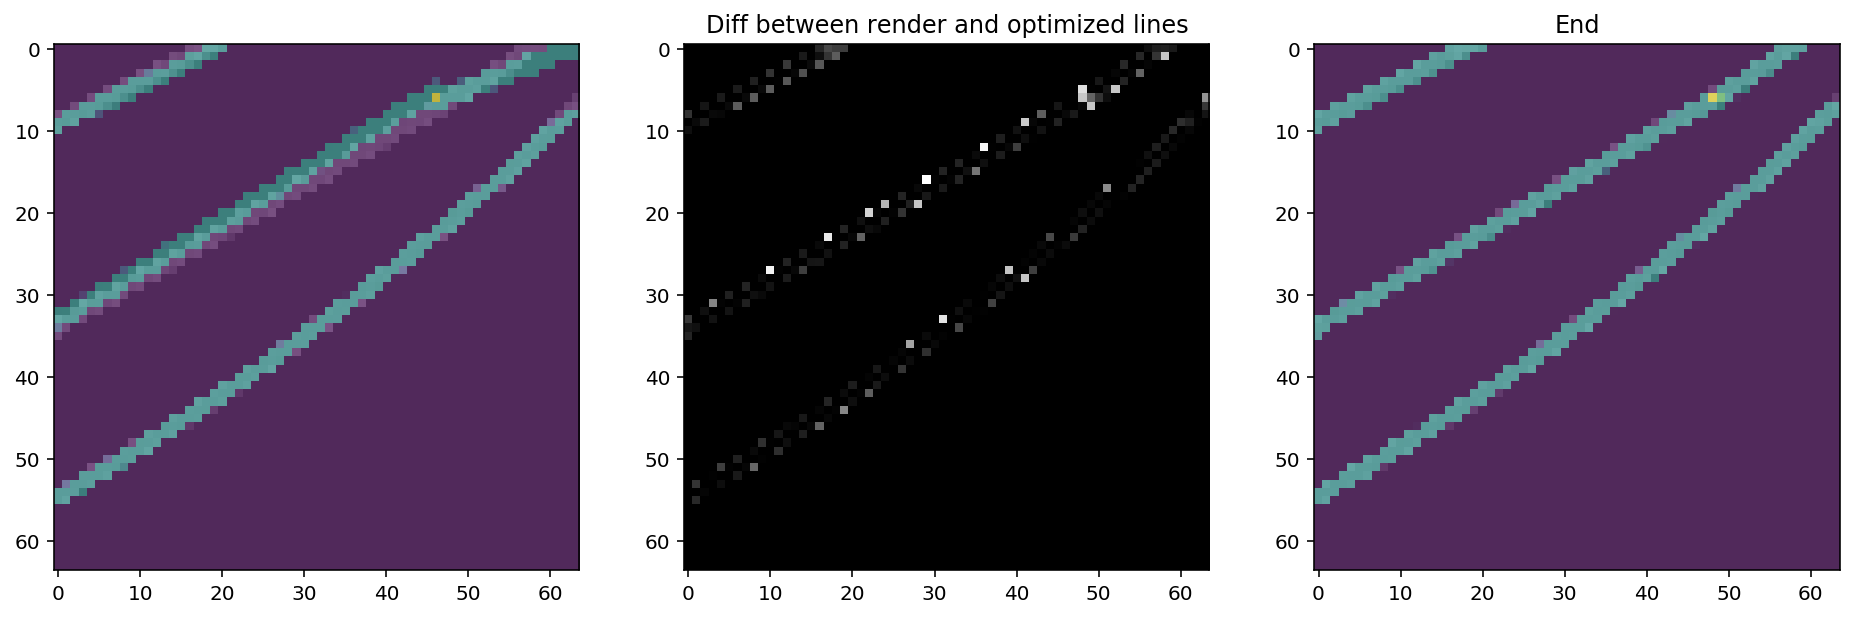

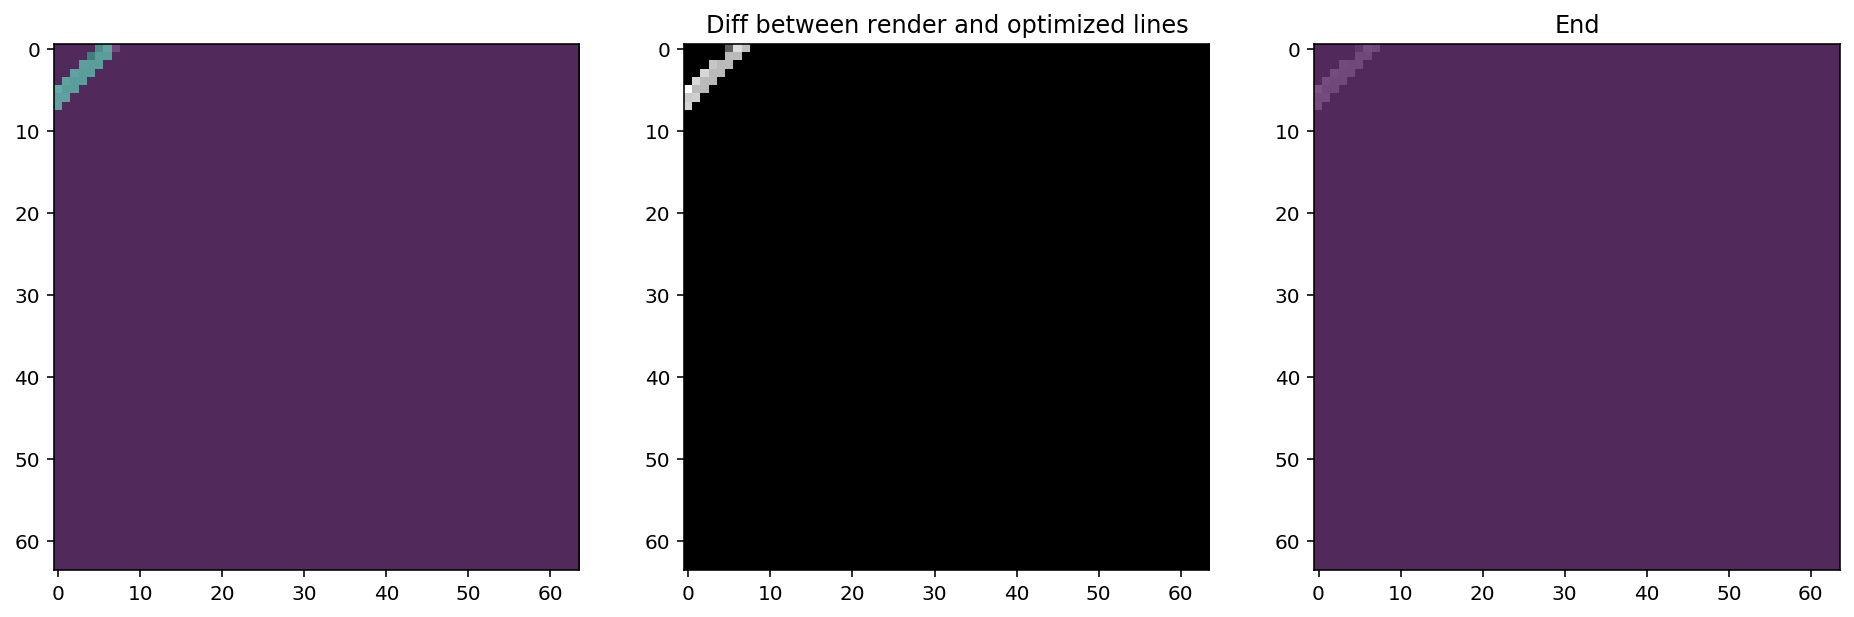

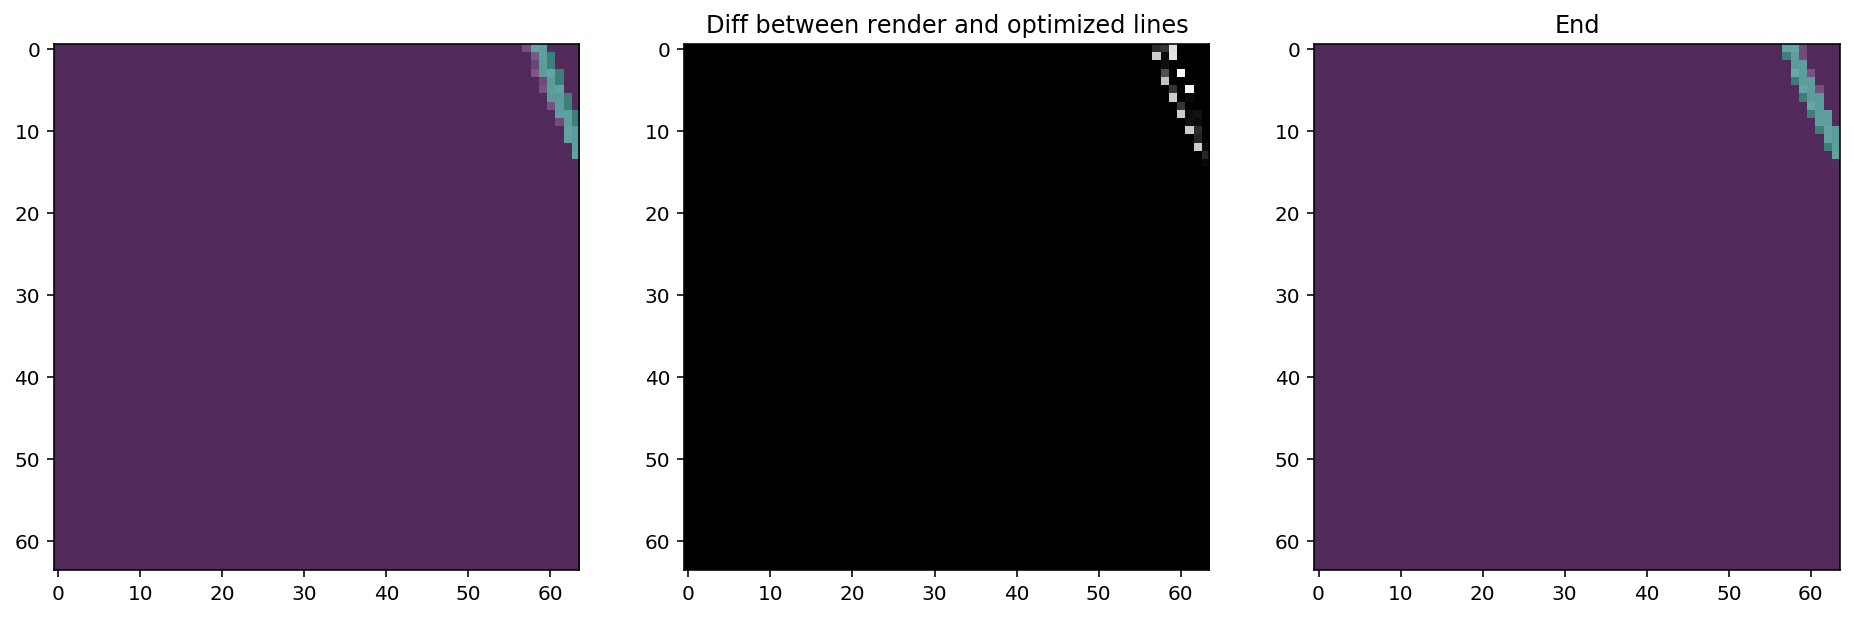

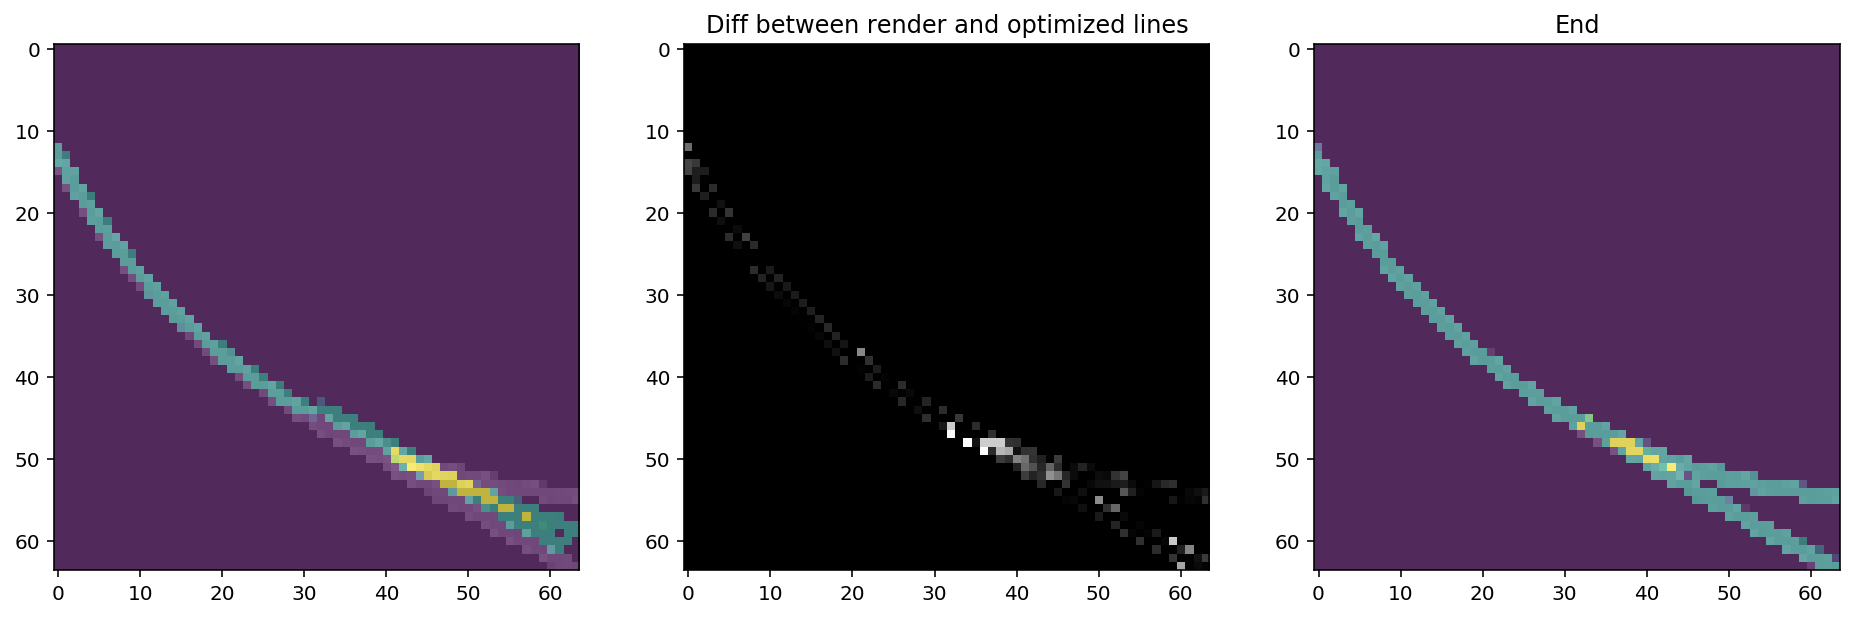

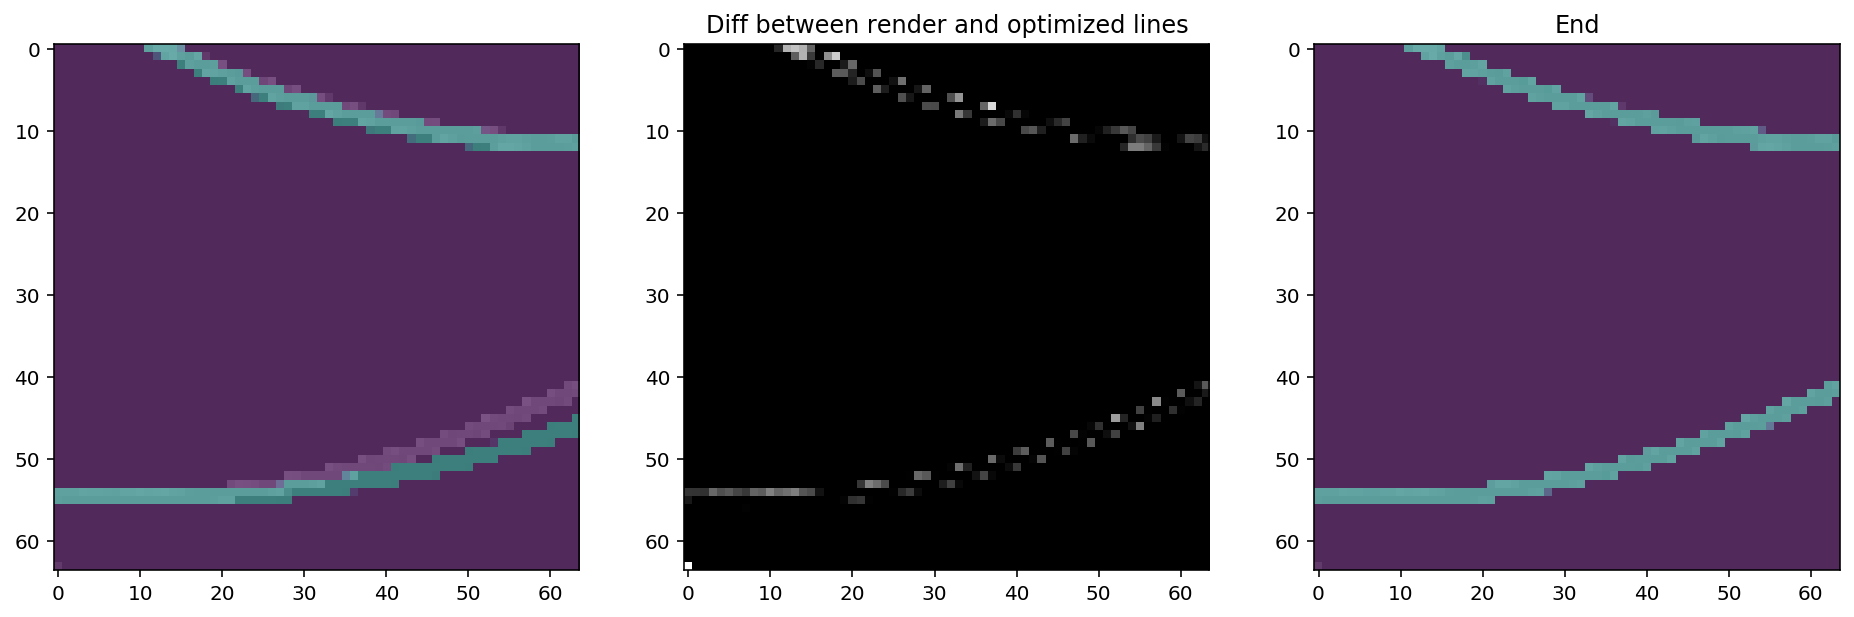

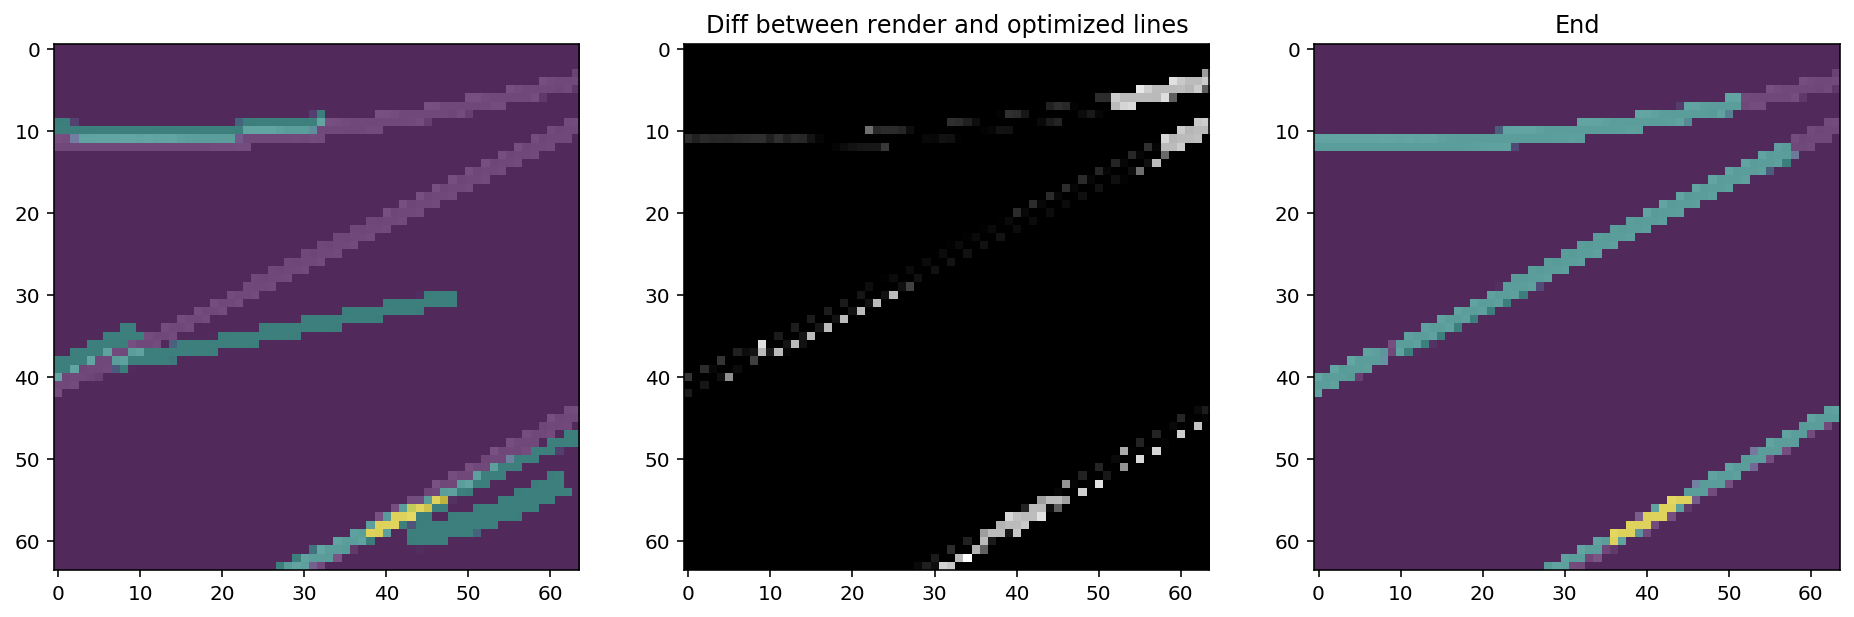

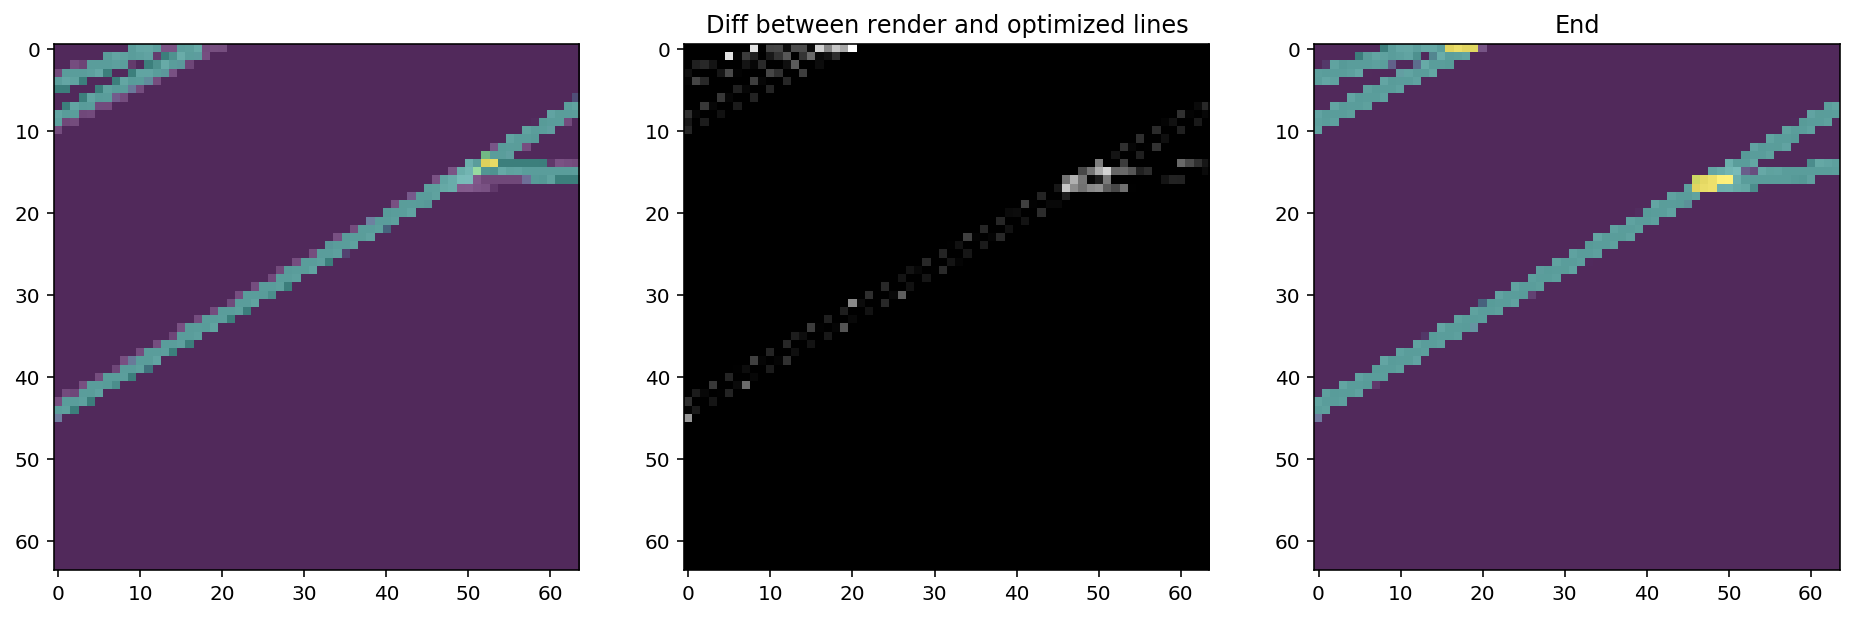

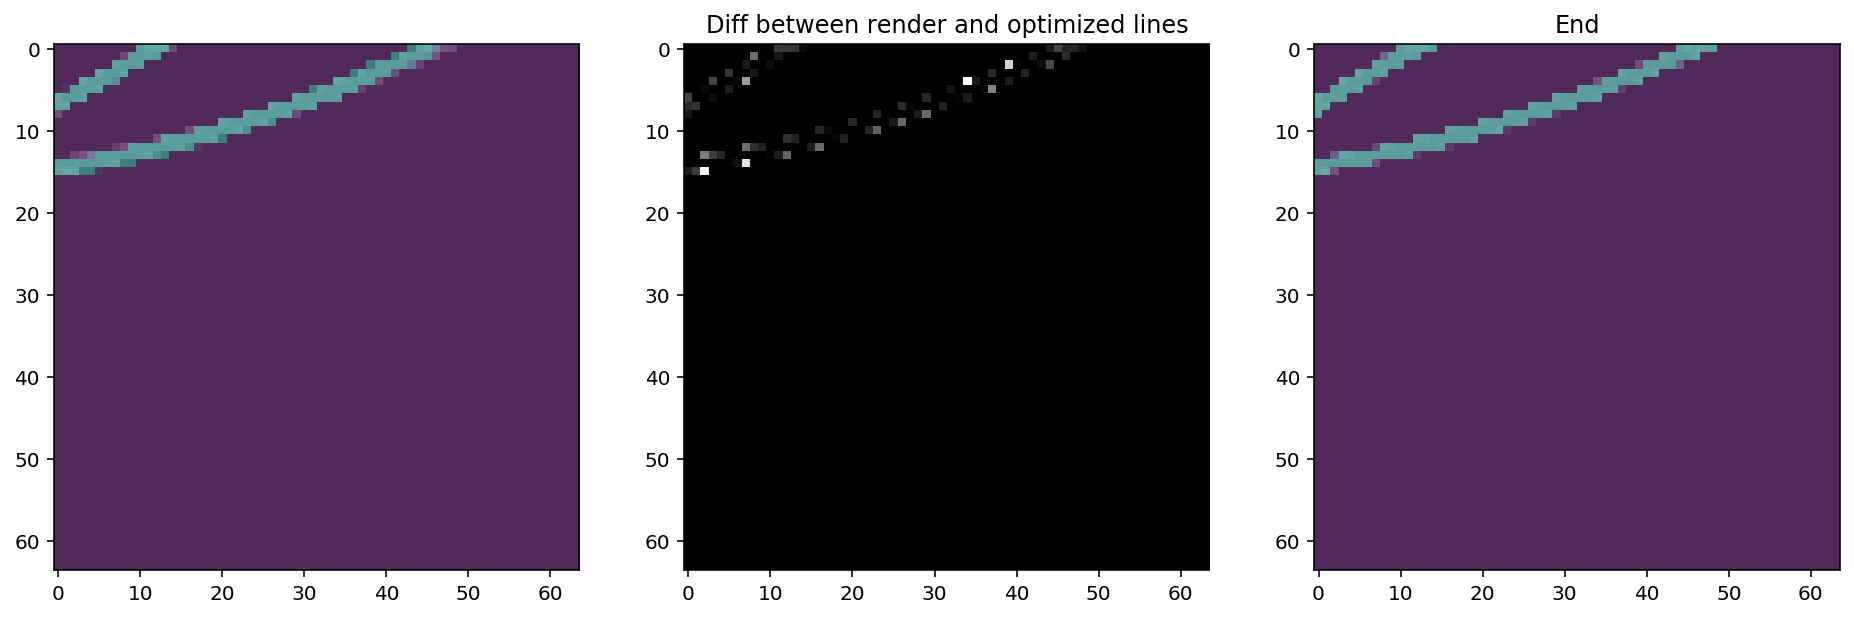

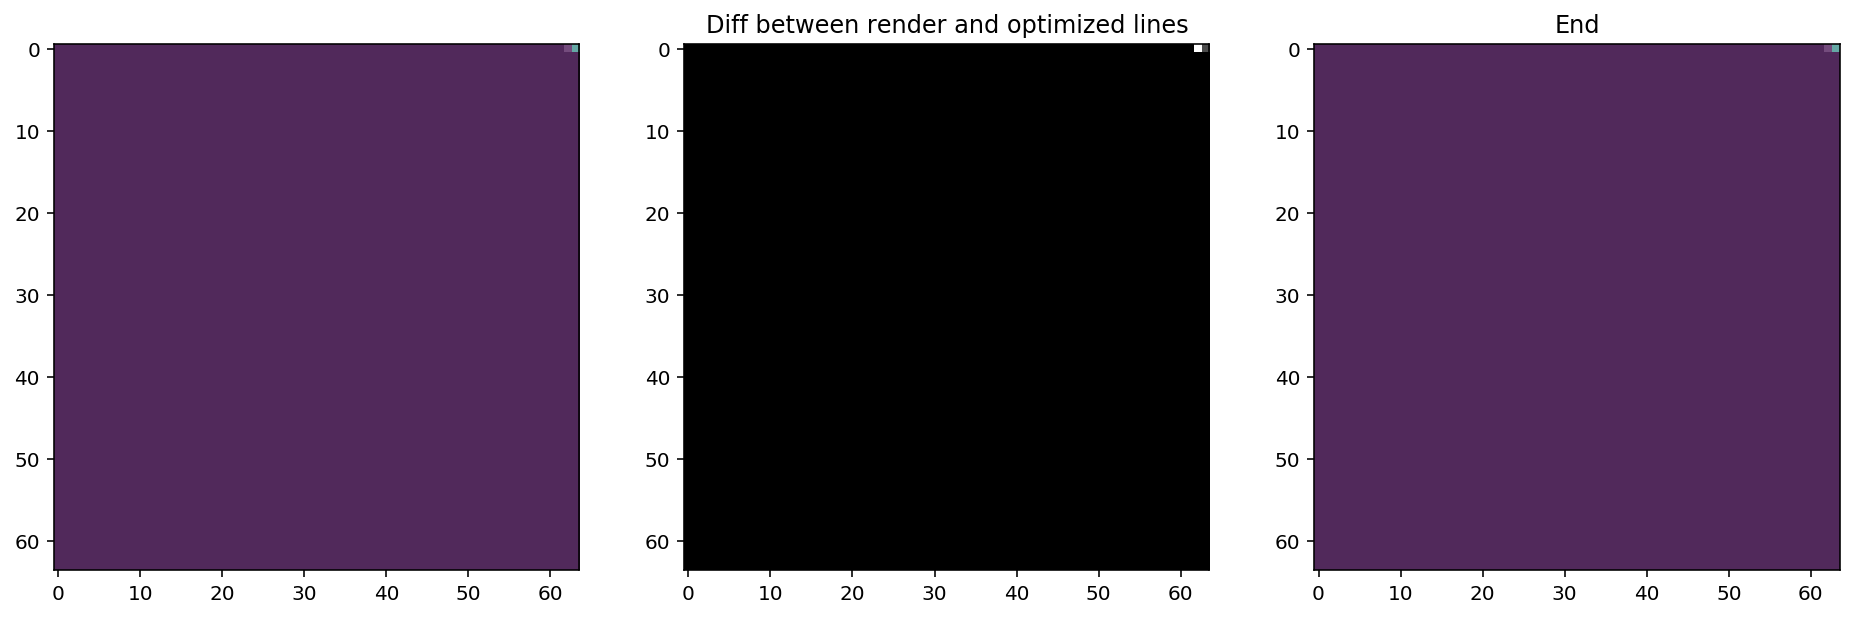

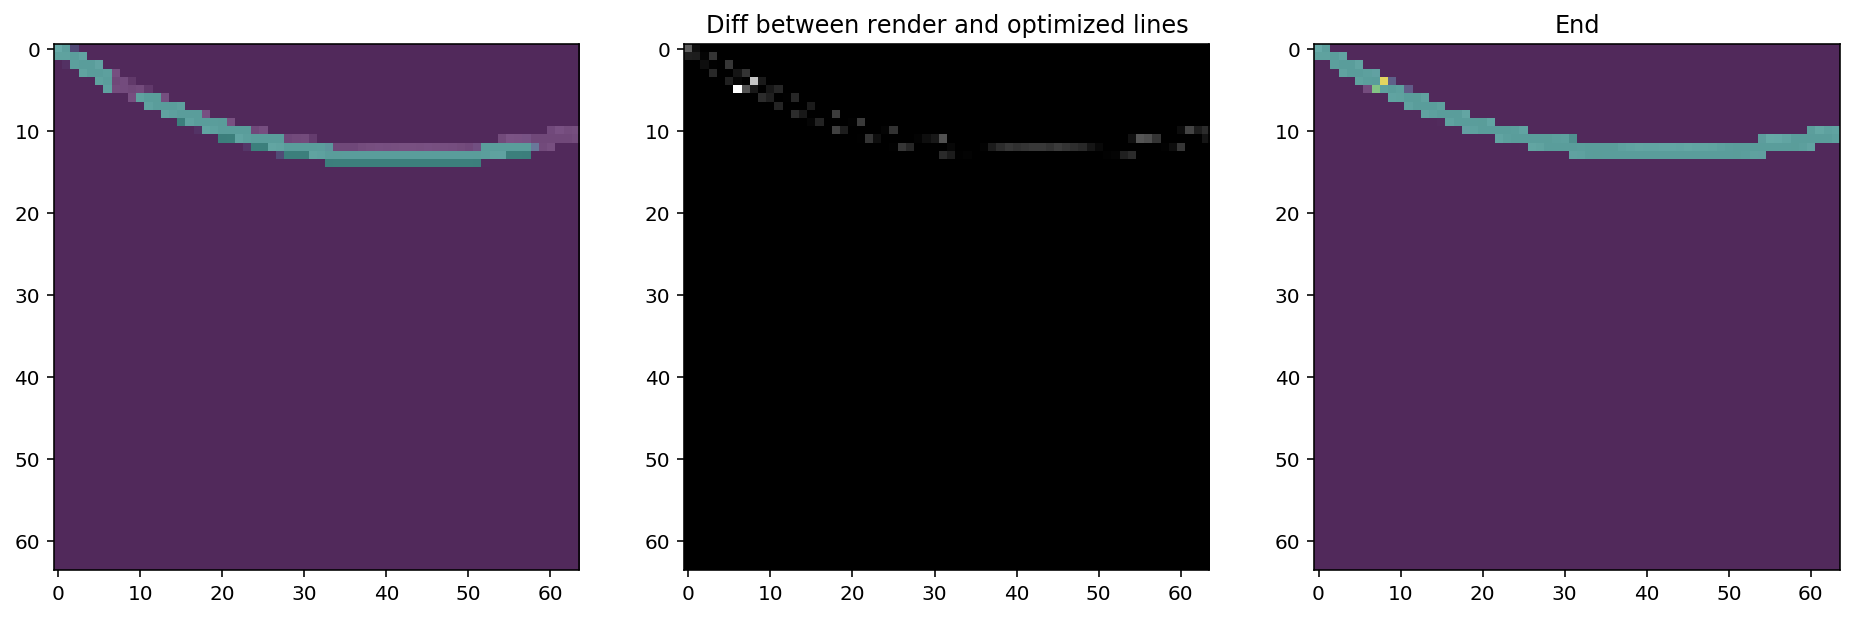

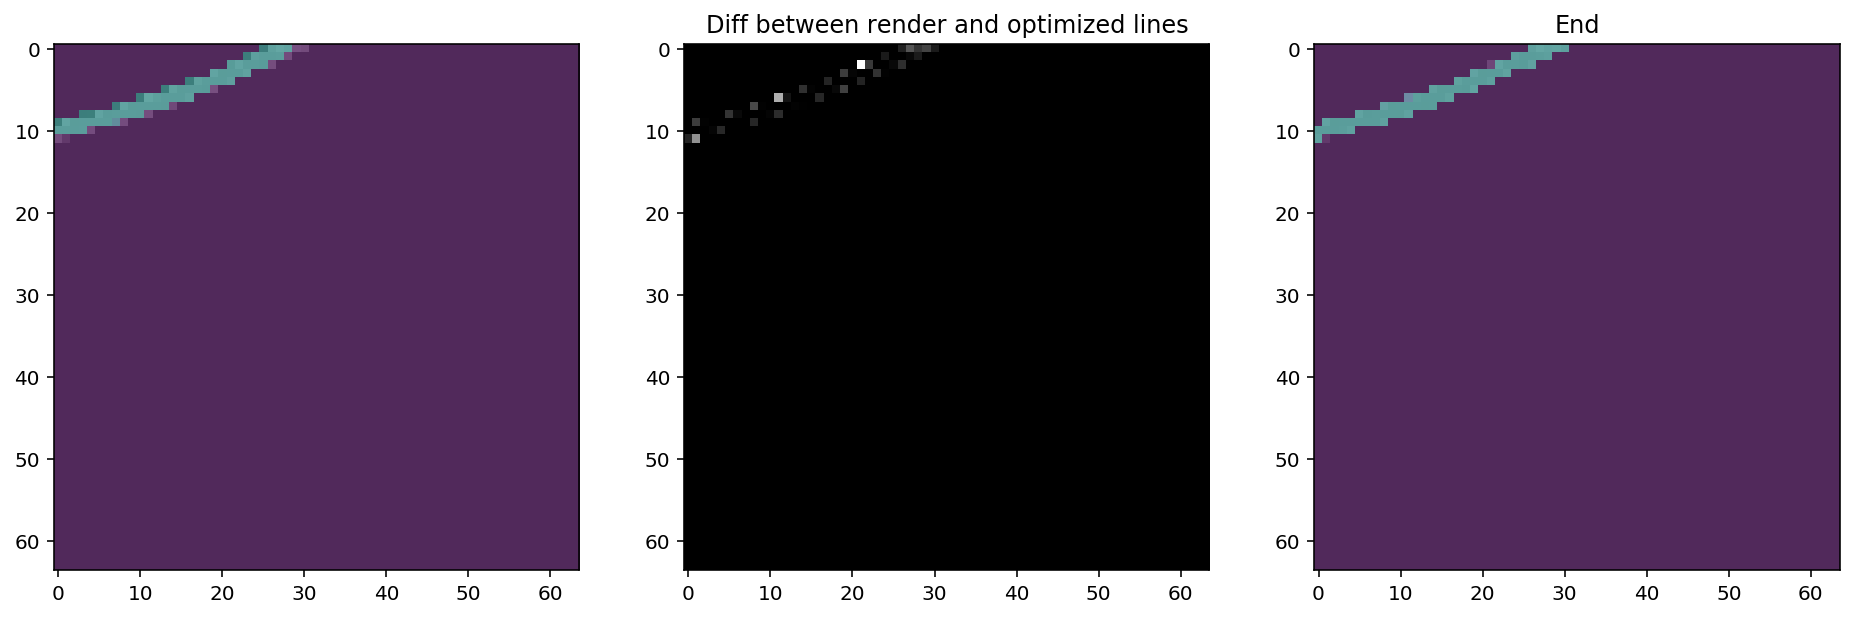

In [8]:
all_rasters = torch.from_numpy(sample['patches_rgb'])
nonempty_patches = (all_rasters.mean(dim=(1, 2)) != 255.).view(-1)
all_rasters = all_rasters[nonempty_patches]
all_rasters = 1. - all_rasters / 255.
all_vectors = sample['patches_vector'][nonempty_patches]

batch_size = 64

for batch_start in range(0, len(all_rasters), batch_size):

    raster = all_rasters[batch_start:batch_start+batch_size].squeeze(3).to(DEVICE).type(torch.float32)
    raster = (0.5 * model.forward(raster.unsqueeze(1)).squeeze(1).detach() + 0.5 * raster) * (raster > 0.5)
#     raster /= 2 * raster.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values

    vector = all_vectors[batch_start:batch_start+batch_size].to(DEVICE).type(torch.float32)
    # important: set half-luminance on all primitives
    vector[:, :, -1] = 0.5

    # zero out primitives outside of the patch
    vector.requires_grad_()
    img_mean = renderer.render(vector).mean()
    img_mean.backward()
    grad = vector.grad
    vector.requires_grad_(False)
    vector[(torch.abs(grad) > 1e-6).sum(dim=2) == 0] = 0.
    
    n_steps = 500

    loss = LossComposition()
    ot_loss = SamplesLoss("sinkhorn", p=2, blur=.01, scaling=.5, reach=5.)
    loss.add(make_default_loss_fn(
        bce_schedule=(lambda state: 0.0),
        ot_loss=ot_loss
    ))
#     loss.add(not_too_thin)
    loss.add(perceptual_bce(model, 3))
    loss.add(perceptual_bce(model, 4))

    grad_transformer = compose(strip_confidence_grads, coords_only_grads(n_steps - 150))

    aligner = StatefulBatchAligner(vector, raster, device=DEVICE)
    init_ot_aligner(aligner, loss_fn=loss, device=DEVICE,
                    optimize_fn=make_default_optimize_fn(
                        aligner, 
                        lr=0.25, 
                        transform_grads=grad_transformer,
                        base_optimizer=optim.Adam,
                    ))

    aligner.add_callback(store_render_difference)

    for _ in tqdm(range(n_steps)):
        aligner.step()
        
    all_vectors[batch_start:batch_start+batch_size] = aligner.state['current_line_batch'].clone().detach().cpu()
    
    sample['patches_vector'][nonempty_patches] = all_vectors
    
    initial_renders = renderer.render(aligner.state['initial_line_batch']).detach().cpu().numpy()

    for i, (raster, render) in enumerate(zip(aligner.state['raster'], aligner.state['render'])):
        raster = raster.detach().cpu().numpy()
        render = render.detach().cpu().numpy()

        plt.figure(figsize=(16, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(raster, alpha=0.6, cmap='gray', vmax=1.0, vmin=0.0)
        initial = initial_renders[i]
        plt.imshow(initial, alpha=0.6, vmax=1.0, vmin=0.0)
        plt.subplot(1, 3, 2)
        plt.title('Diff between render and optimized lines')
        plt.imshow(np.abs(aligner.state['difference'][i].detach().cpu().numpy()), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(raster, alpha=0.6, cmap='gray', vmax=1.0, vmin=0.0)
        plt.title('End')
        plt.imshow(aligner.state['render'][i].detach().cpu().numpy(), alpha=0.6, vmax=1.0, vmin=0.0)
        plt.show()

[autoreload of svgpathtools failed: Traceback (most recent call last):
  File "/home/apankov/miniconda3/envs/apankov/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/apankov/miniconda3/envs/apankov/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/apankov/miniconda3/envs/apankov/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/apankov/miniconda3/envs/apankov/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/apankov/miniconda3/envs/apankov/lib/python3.6/site-packages/svgpathtools/__init__.py", line 11, in <modu

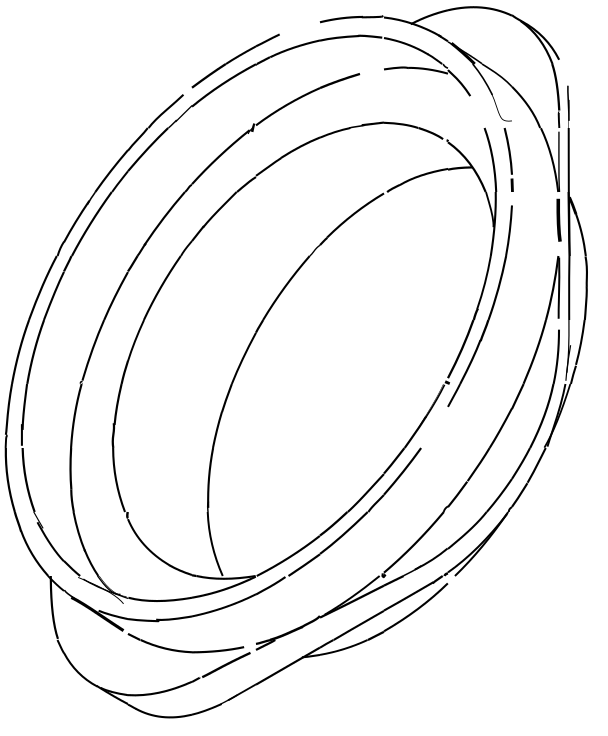

In [9]:
output_vector_image = vector_image_from_patches(
    primitives=sample['patches_vector'],
    patch_offsets=sample['patches_offsets'],
    image_size=sample['cleaned_image_shape'],
    control_points_n=4,
    patch_size=[64, 64],
    pixel_center_coodinates_are_integer=False,
    min_width=.3,
    min_confidence=.5,
    min_length=1.7)

from PIL import Image

Image.fromarray(output_vector_image.render(cairo_render))

In [10]:
sample

dict_keys(['patches_rgb', 'patches_vector', 'patches_offsets', 'cleaned_image_shape', 'options', 'image_name'])

In [23]:
output_vector_image.save('inference/2_pred.svg')

TypeError: complex() first argument must be a string or a number, not 'Path'

In [12]:
output_vector_image.save('inference/1_after.svg')

In [22]:
output_vector_image.adjust_viewbox()

In [11]:
Image.fromarray(output_vector_image.render(cairo_render)).save('predicted___.png')

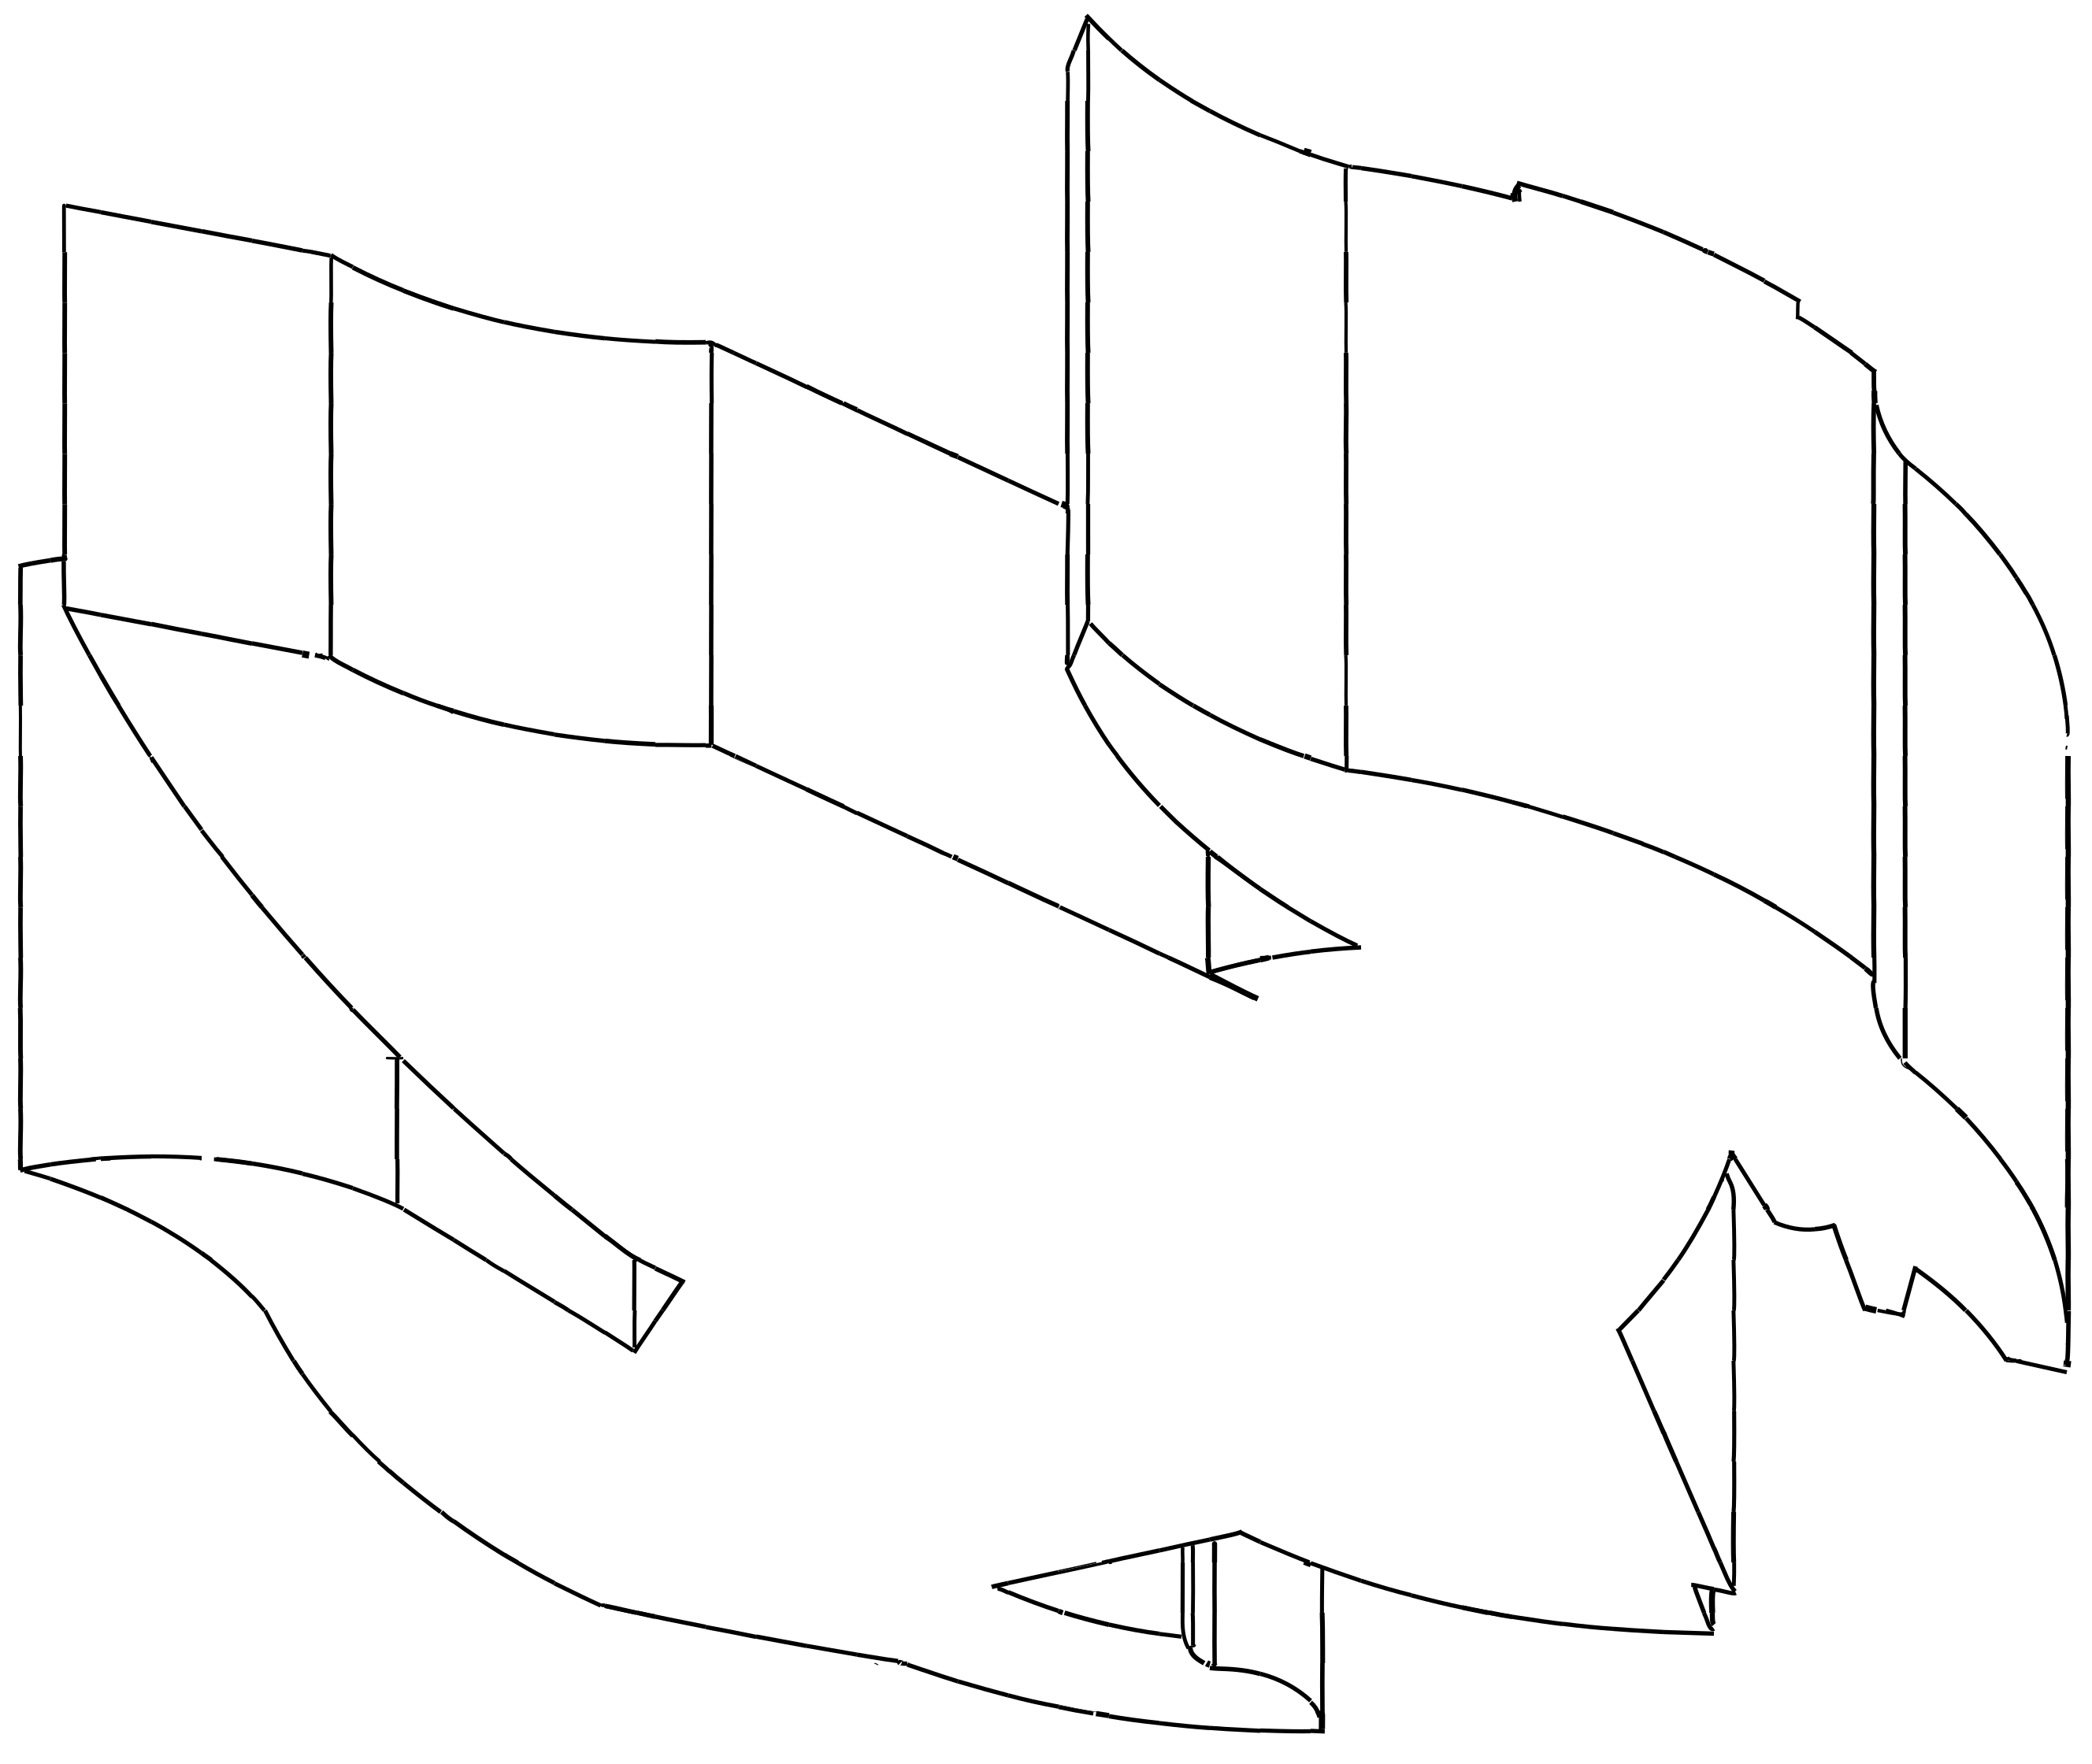

In [9]:
output_vector_image = vector_image_from_patches(
    primitives=sample['patches_vector'],
    patch_offsets=sample['patches_offsets'],
    image_size=sample['cleaned_image_shape'],
    control_points_n=4,
    patch_size=[64, 64],
    pixel_center_coodinates_are_integer=False,
    min_width=.3,
    min_confidence=.5,
    min_length=1.7)

from vectran.renderers.cairo import render
from PIL import Image

Image.fromarray(output_vector_image.render(render))

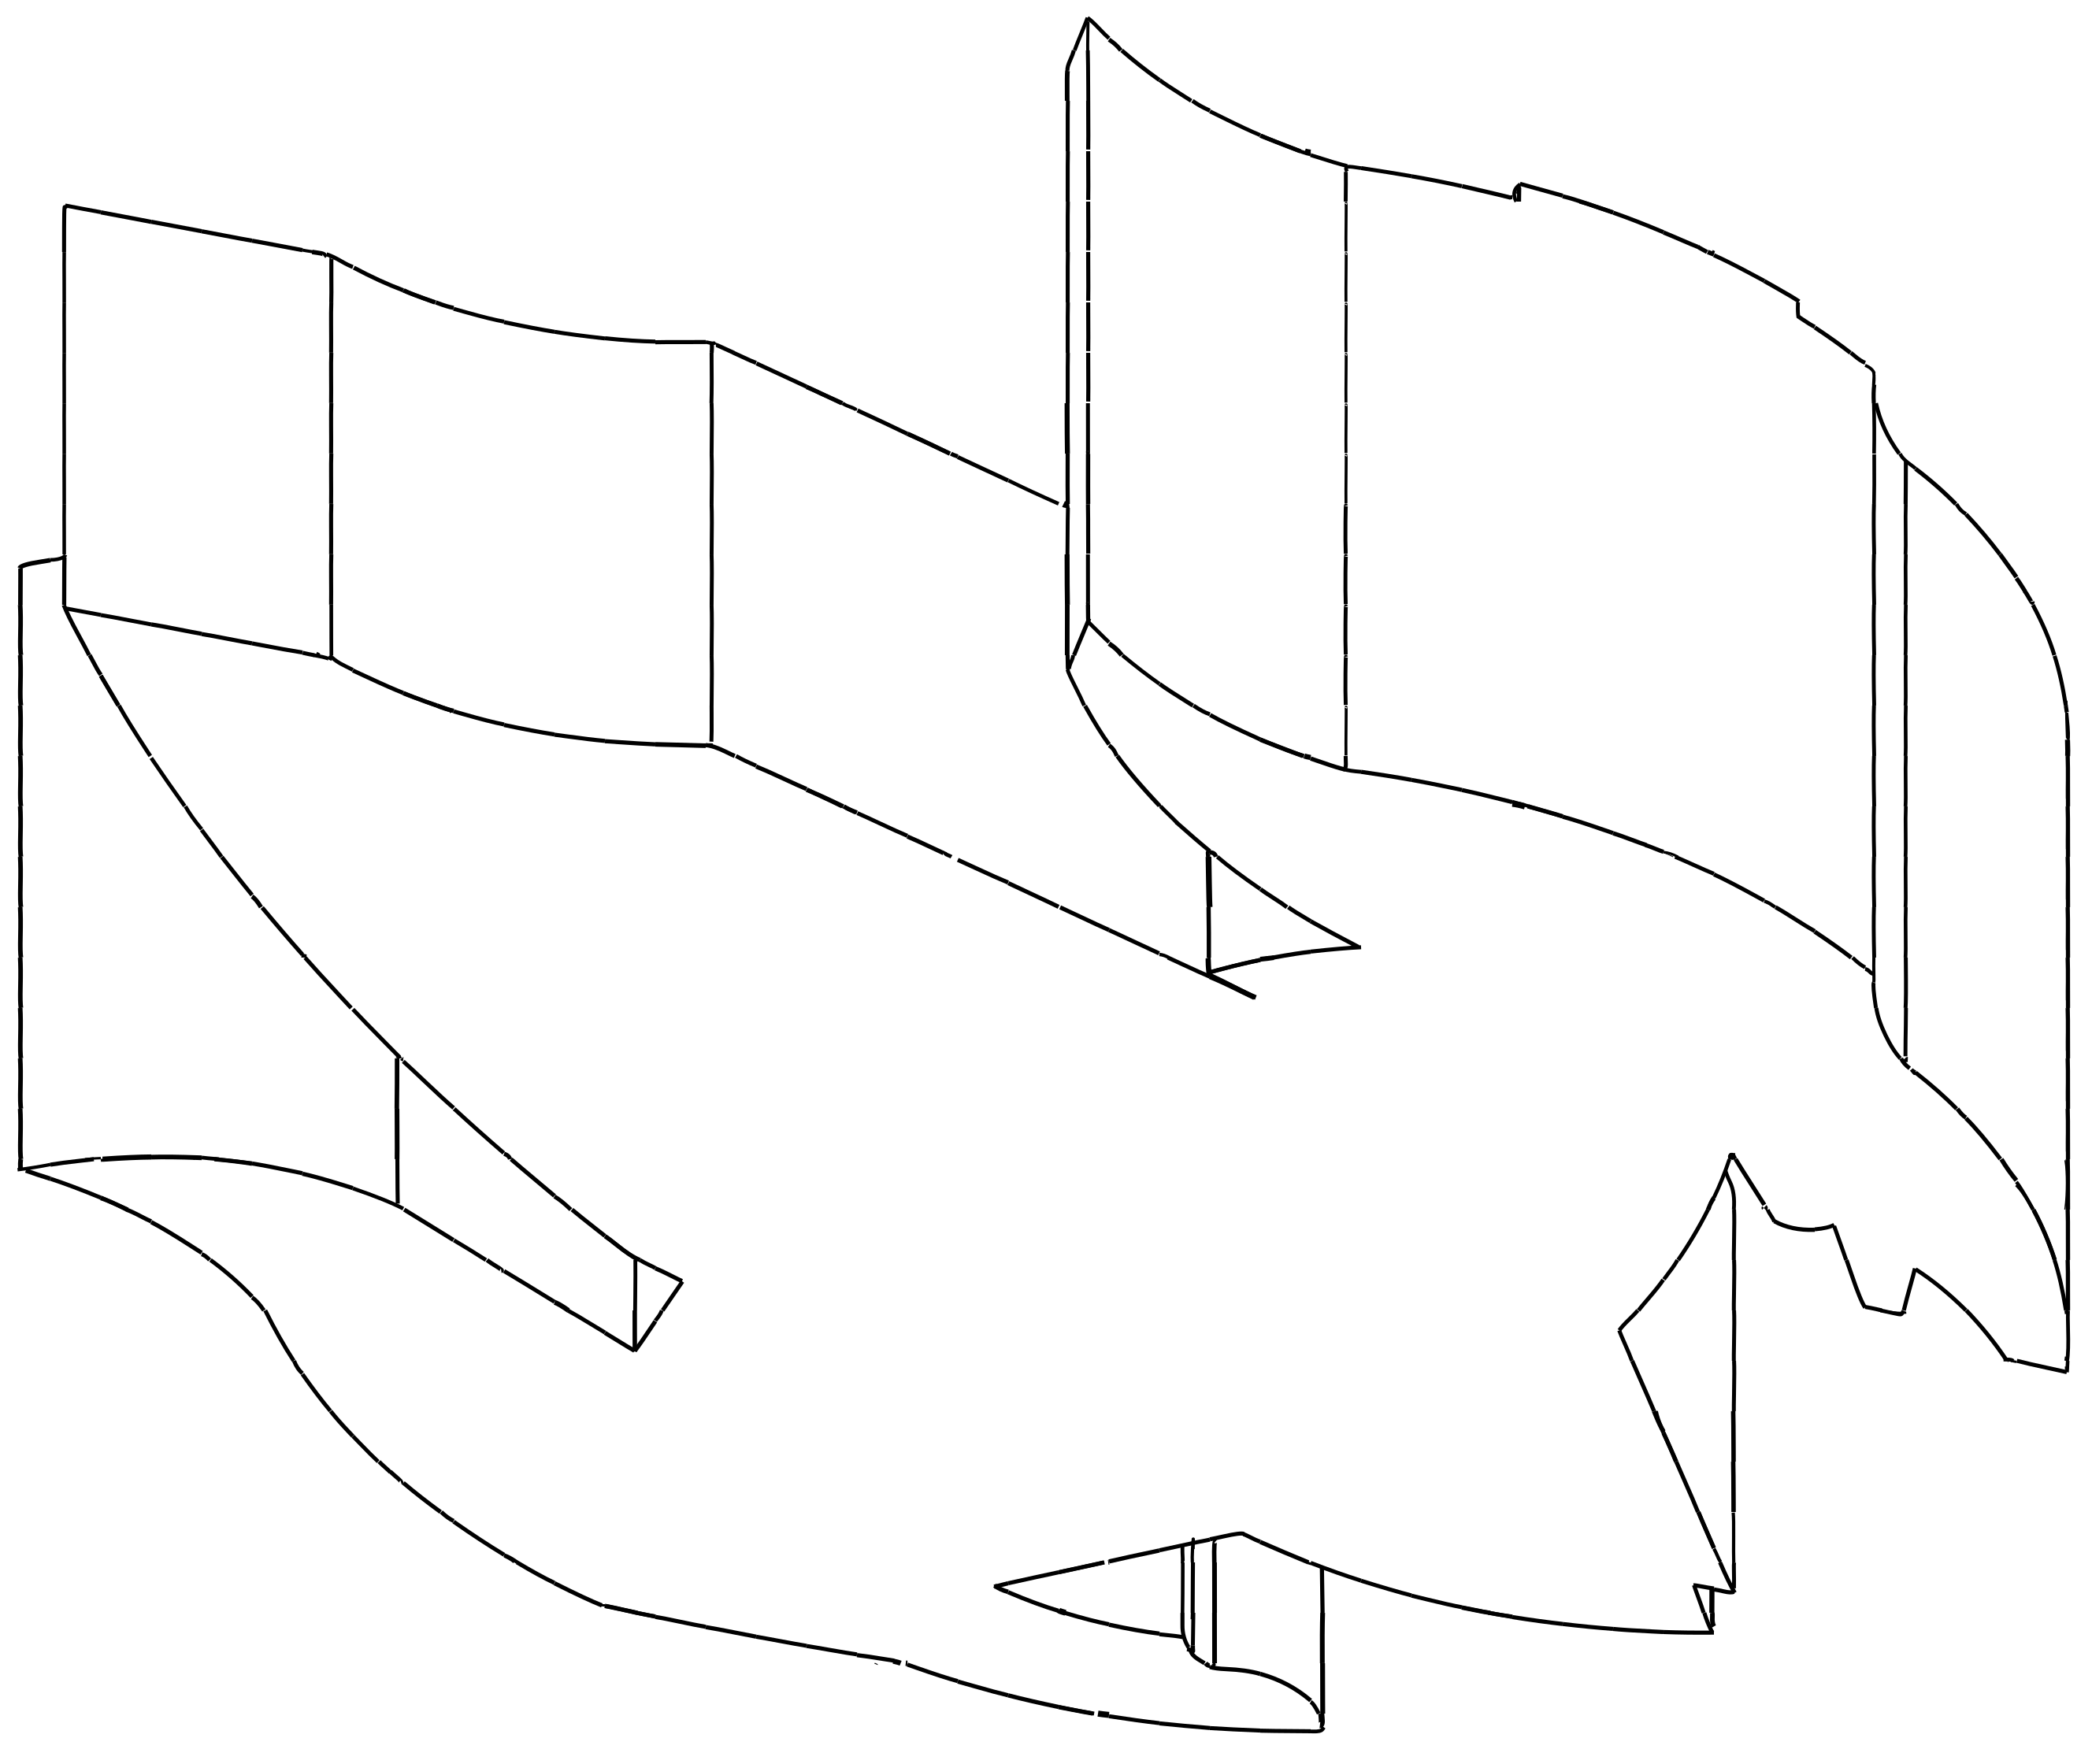

In [9]:
output_vector_image = vector_image_from_patches(
    primitives=sample['patches_vector'],
    patch_offsets=sample['patches_offsets'],
    image_size=sample['cleaned_image_shape'],
    control_points_n=4,
    patch_size=[64, 64],
    pixel_center_coodinates_are_integer=False,
    min_width=.3,
    min_confidence=.5,
    min_length=1.7)

from vectran.renderers.cairo import render
from PIL import Image

Image.fromarray(output_vector_image.render(render))

In [11]:
Image.fromarray(output_vector_image.render(render)).save('predicted.png')